# Figure Generator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import time
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
from PIL import Image, ImageFilter
from scipy.signal import medfilt
import skimage
import skimage.io
import skimage.feature
import skimage.filters
from skimage.transform import hough_circle, hough_circle_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sympy import *
import os
#from skimage.draw import circle_perimeter
mpx = 8/924;
ipc = 1/2.54;
from scipy.stats import ttest_ind

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
#mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 8; fsz=8;
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams["savefig.dpi"] = 300;
dir0 = '../../../../../Dropbox (MIT)/MRE_photos/photos/';

In [3]:
class Colony:
    '''save image as colony information object'''
    def __init__(self, files, center=True, norm=True, thres=0.25):
        if(len(files)==1):
            self.Image = skimage.io.imread(fname=files[0]); 
            self.Image = (self.Image-np.mean(np.sort(self.Image)[:100]) );
            self.Image = self.Image*(self.Image>0);
            self.ImageBW = skimage.io.imread(fname=files[0], as_gray=True);
        elif(len(files)==2):
            img1 = skimage.io.imread(fname=files[0]); 
            #img1 = (img1-np.mean(np.sort(img1)[:100]) );
            #img1 = img1*(img1>0);
            img1 = [1,0,0]*skimage.color.gray2rgb( skimage.img_as_float( img1) );
            img2 = skimage.io.imread(fname=files[1]); 
            #img2 = (img2-np.mean(np.sort(img2)[:100]) );
            #img2 = img2*(img2>0);
            img2 = [0,1,1]*skimage.color.gray2rgb( skimage.img_as_float( img2) );
            if(norm):
                img1 = (img1-np.mean(np.sort(img1)[:100]) )/(np.max(img1)-np.mean(np.sort(img1)[:100]));
                img2 = (img2-np.mean(np.sort(img2)[:100]) )/(np.max(img2)-np.mean(np.sort(img2)[:100]));
                img1 = img1*(img1>0); img2=img2*(img2>0);
            self.Image = img1+img2;
            self.ImageBW = skimage.color.rgb2gray(self.Image)
        self.Edge = skimage.filters.sobel(self.ImageBW);
        if(center):
            self.cx = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=0) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
            self.cy = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=1) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
            self.Image = np.roll(self.Image, -int(self.cy)+512, axis=0);
            self.Image = np.roll(self.Image, -int(self.cx)+512, axis=1);
            self.ImageBW = np.roll(self.ImageBW, -int(self.cy)+512, axis=0);
            self.ImageBW = np.roll(self.ImageBW, -int(self.cx)+512, axis=1);
            self.Edge = np.roll(self.Edge, -int(self.cy)+512, axis=0);
            self.Edge = np.roll(self.Edge, -int(self.cx)+512, axis=1);
            #self.Image = self.Image*(self.Image > 0.35*np.max(self.Image))
        #self.R = (np.sum( self.ImageBW > 0.25*np.max(self.ImageBW) )/np.pi)**0.5; ### 25% threshold
        self.R = (np.sum( self.ImageBW > thres*np.max(self.ImageBW) )/np.pi)**0.5;
        
    def color(self, c):
        filt = [0,0,0]; filt[c*2]=1; filt[c]=1;
        self.Image = filt*skimage.color.gray2rgb( skimage.img_as_float( self.Image) );
        self.Image = self.Image/np.max(self.Image);
    
        
    def bdy(self, sigma=2.0, low_threshold=0.01, high_threshold=0.05):
        self.Edge = filters.sobel(self.ImageBW);
        self.cx = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=0) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
        self.cy = np.sum( np.arange(1024)*np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1, axis=1) )/np.sum(self.ImageBW>np.mean(self.ImageBW)*1.1);
        
    def bdy_detect(self, sigma=2.0, low_threshold=0.01, high_threshold=0.05, rmin = 200, rmax=300):
        '''calculate the boundary and center information, using Canny algorithm in skimage implementation '''
        self.Edge = skimage.feature.canny(image=self.ImageBW, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold);
        hough_radii = np.arange(rmin, rmax, 2);
        hough_res = hough_circle(self.Edge, hough_radii);
        accums, self.cx, self.cy, self.r = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1);
        
    def rtheta(self, thres=0.03):
        '''From the center and boundary data, plot r '''
        # first, pick up points that are considerably away from radius r.
        self.EdgeD = np.copy(self.Edge);
        xs = np.arange(1024); mesh=np.meshgrid(xs,xs);
        rs = np.sqrt( (mesh[0]-self.cx)**2 + (mesh[1]-self.cy)**2  )
        #self.EdgeD = self.EdgeD * (rs < self.r*(1-thres)  )
        # Use arctan to find r-theta
        ys, xs = np.nonzero(self.EdgeD);
        ys -= self.cy; xs -= self.cx;
        self.phi = np.arctan2(ys,xs);
        self.rs = np.sqrt( ys**2 + xs**2 );
        
    ## bdy_detect + rtheta is almost-finished routine for the tapistry view.
    ## However we can also ask: is there any better way to do this?
    ## One key point should be to re-position the dent so that the symmetic axis comes to x=0. How can I do this?
        

In [4]:
def linf(x,a,b):
    return a*x +b
def linfit(xs, ys):
    pop, popt = curve_fit( linf, xs, ys );
    yfit = xs*pop[0]+pop[1];
    return pop[0], yfit, pop[1]

In [5]:
def fitpoly( img0, x10, x20, u, v2, y ):
    ### Get BW image region, fit to 4-pt polygon
    img = img0*0;
    for x2 in np.arange(u+1):
        img[int(x10+(y*x2/u) ):int( x10+(v2*x2/u) ), int(x20-u+x2)]= 1;
        img[int(x10+(y*x2/u) ):int( x10+(v2*x2/u) ), int(x20+u-x2)]= 1;
    return img0-img

In [6]:
def fitshape(img):
    y1 = np.zeros(1024); y2=np.zeros(1024);
    for i in np.arange(1024):
        if( len( np.where( img[:,i] > 0.4*np.max(img) )[0]    ) > 0 ):
            y1[i] = np.min( np.where( img[:,i] > 0.1*np.max(img) ) );
        if( len( np.where( img[:,i] > 0.45*np.max(img) )[0]    ) > 0 ):
            y2[i] = np.max( np.where( img[:,i] > 0.25*np.max(img) ) );
    y = np.max(y1) - np.min(y1[y1>0]  );
    v2 = np.max(y2) - np.min(y1[y1>0] );
    u = np.max( np.where( y1>0 ) ) - np.min( np.where( y1>0 ) ); u = u/2;
    v1 = u*(v2-y)/np.sqrt(u**2+y**2);
    print( u, v2, y )
    print(u/v2, v1/v2)
    
    #x11 = np.min(bdy[0]); x12= np.max(bdy[0]); x21=np.min(bdy[1]); x22=np.max(bdy[1]);
    #u = (x22-x21)/2;
    #v2 = x12-x11;
    #y = np.min( bdy[0][ bdy[1]==int(x21+u) ] )-x11;
    #v1 = u*(v2-y)/np.sqrt(u**2+y**2);
    #print(u/v2, v1/v2)

In [7]:
def coarse(img):
    l = img.shape[0]; l =int(l/2);
    img2 = np.zeros( (l,l) );
    for i in np.arange(l):
        for j in np.arange(l):
            img2[i,j] = np.median(img[i*2:i*2+2, j*2:j*2+2  ]);
    return img2;

In [8]:
vw_expm1=np.array([0.03391664733751731, 0.0340953786268415]);
vm_expm1=np.array([0.022492829541889112, 0.0222423045526467]);
vw_expm1 = np.array([0.033]);
vm_expm1 = np.array([0.020]);
vr_expm1=np.concatenate( [vm_expm1/vw_expm1, vm_expm1/np.flip(vw_expm1) ] )

In [9]:
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
def phis(vw,u):
    return np.arctan(u/vw)
def phiphi(phis, vm2vw):
    u2vw = np.tan(phis);
    return phid(1, vm2vw, u2vw)

## 0707 revision

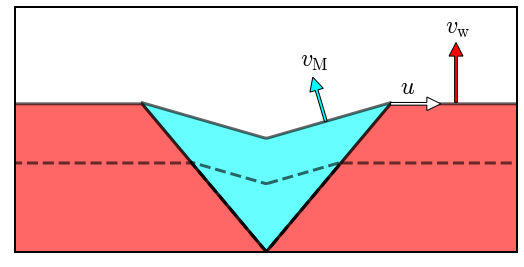

In [60]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-2,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),2,100);
xyw[400:500,0]=np.ones(100)*2; xyw[500:600,0]=np.linspace(2,-2,100); xyw[600:,0]=np.ones(100)*(-2);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);



fig, ax = plt.subplots(figsize=(9,4.5)  )
plt.rcParams.update({'font.size': fsz})
ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=0.6, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.6, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xym*0.6, facecolor='none', alpha=0.6, linewidth=3, linestyle='--', edgecolor='k') )
ax.add_patch(patch.Polygon(xyw*0.6, facecolor='none', alpha=0.6, linewidth=3, linestyle='--', edgecolor='k') )
ax.add_patch(patch.FancyArrow( 0.68,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))

ax.add_patch(patch.FancyArrow( -xym[320,0],xym[320,1],0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1,1.0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( xb[-1],yb[-1],0.18,0, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) ,alpha=1  ))


ax.text(0.64, 0.8, r'$v_{\rm w} $', color=(0,0,0), fontsize=24)
ax.text(0.12, 0.68, r'$v_{\rm M} $', color=(0,0,0), fontsize=24)
ax.text(0.48, 0.58, r'$u$', color=(0,0,0), fontsize=24)
ax.set_xlim(-0.9,0.9)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);
ax.margins(0,0);
fig.savefig('./fig_v1/2a.pdf', bbox_inches='tight')

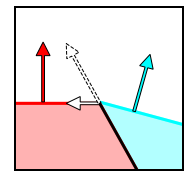

In [137]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.45,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-2,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),2,100);
xyw[400:500,0]=np.ones(100)*2; xyw[500:600,0]=np.linspace(2,-2,100); xyw[600:,0]=np.ones(100)*(-2);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);



fig, ax = plt.subplots(figsize=(3,3)  )
plt.rcParams.update({'font.size': fsz})
ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=0.3, linewidth=3, edgecolor=(0,1,1)) )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.3, linewidth=3, edgecolor=(1,0,0) ))
ax.add_patch(patch.Polygon(xym, facecolor='none', alpha=1, linewidth=3, edgecolor=(0,1,1)) )
ax.add_patch(patch.Polygon(xyw, facecolor='none', alpha=1, linewidth=3, edgecolor=(1,0,0) ))
#x0.4
ax.add_patch(patch.FancyArrow( -0.5,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))
indm=300;
ax.add_patch(patch.FancyArrow( xym[indm,0],xym[indm,1],-0.01/xym[indm,0],0.01/(xym[indm,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1,1.0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],-0.12,0, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],-0.12,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) , linestyle='--', alpha=1  ))
ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],xb[-1],-yb[-1], width=0.006, length_includes_head=True, head_width=0.00, head_length=0.00, facecolor=(0,0,0) ,alpha=1  ))

#ax.text(-0.74, 0.8, r'$v_{\rm w} $', color=(0,0,0), fontsize=24)
#ax.text(-0.22, 0.68, r'$v_{\rm M} $', color=(0,0,0), fontsize=24)
#ax.text(-0.52, 0.68, r'$v_{\rm B} $', color=(0,0,0), fontsize=24)
#ax.text(-0.57, 0.57, r'$u$', color=(0,0,0), fontsize=24)
ax.set_xlim(-0.6,0.)
ax.set_ylim(0.3, 0.9)
ax.set_xticks([]); ax.set_yticks([]);
ax.margins(0,0);
fig.savefig('./fig_v1/2a1.pdf', bbox_inches='tight')

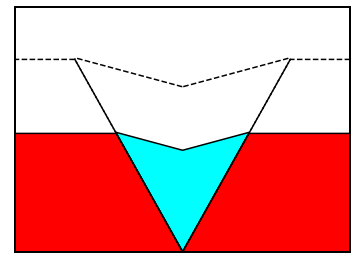

In [142]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.45,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-2,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),2,100);
xyw[400:500,0]=np.ones(100)*2; xyw[500:600,0]=np.linspace(2,-2,100); xyw[600:,0]=np.ones(100)*(-2);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);



fig, ax = plt.subplots(figsize=(6,4.5)  )
plt.rcParams.update({'font.size': fsz})
ax.add_patch(patch.Polygon(xym*0.8, facecolor=(0,1,1), alpha=1, linewidth=1.5, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw*0.8, facecolor=(1.0,0.,0.), alpha=1, linewidth=1.5, edgecolor='k') )
ax.add_patch(patch.Polygon(xym*1.3, facecolor='none', alpha=1, linewidth=1.5, linestyle='--', edgecolor='k') )
ax.add_patch(patch.Polygon(xyw*1.3, facecolor='none', alpha=1, linewidth=1.5, linestyle='--', edgecolor='k') )

#ax.add_patch(patch.FancyArrow( -0.7,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))
#indm=320;
#ax.add_patch(patch.FancyArrow( xym[indm,0],xym[indm,1],-0.01/xym[indm,0],0.01/(xym[indm,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1,1.0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],-0.18,0, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],-0.18,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,0.1,1.) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],xb[-1],-yb[-1], width=0.015, length_includes_head=True, head_width=0.00, head_length=0.00, facecolor=(1.,0.1,1.) ,alpha=1  ))

#ax.text(-0.74, 0.8, r'$v_{\rm w} $', color=(0,0,0), fontsize=24)
#ax.text(-0.22, 0.68, r'$v_{\rm M} $', color=(0,0,0), fontsize=24)
#ax.text(-0.52, 0.68, r'$v_{\rm B} $', color=(0,0,0), fontsize=24)
#ax.text(-0.57, 0.57, r'$u$', color=(0,0,0), fontsize=24)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);
ax.margins(0,0);
fig.savefig('./fig_v1/2a2.pdf', bbox_inches='tight')

# 0628 Talk prep

In [10]:
dest1 = dir0+'1017/COMP01/WM11_1_1.tif';
dest2 = dir0+'1017/COMP01/WM11_2_1.tif';
comp = Colony([dest1,dest2]);
dest = dir0+'1017/MONO1/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO1/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

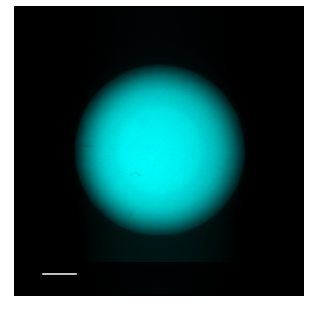

In [19]:
fig, ax = plt.subplots(figsize=(4,4));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( m01.Image)
#ax.text(412,100,'Wildtype', color=(1,1,1));

#ax.imshow( m01.Image)
#ax.text(422,100,'Mutant', color=(1,1,1));
ax.plot( np.linspace(0, 1/mpx, 10)+100, np.ones(10)*950, color=(1,1,1) )
#ax.text( 90, 910, '1mm', color=(1,1,1) )


In [25]:
dr = dir0+'0914/n2_1/A1.tif' 
r = Colony([dr]); #r.color(0);
#dc = dir0+'0914/n2_1/A2.tif'   #'0901R1/A2.tif';
#c = Colony([dc]); #c.color(1);

In [28]:
img = np.copy(c.Image);
#img[:512] = np.copy(r.Image[:512]);
#img = np.flip(img, axis=0);

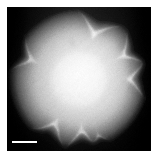

In [31]:
fig, ax = plt.subplots(figsize=(2,2));
margin = 150;
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.imshow(img, cmap=plt.get_cmap('Greys_r'));
ax.set_xlim(1024-margin,margin);
ax.set_ylim(margin,1024-margin);
ax.set_axis_off(); ax.margins(0,0);
ax.plot( np.linspace(0, 1/mpx, 10)+880-margin, np.ones(10)*44+margin, color=(1,1,1), linewidth=2 )
#fig.savefig('./fig_v1/1a1c.pdf', bbox_inches='tight')

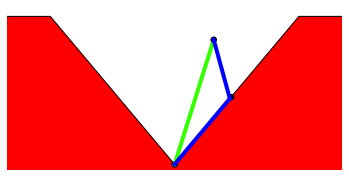

In [55]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-2,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),2,100);
xyw[400:500,0]=np.ones(100)*2; xyw[500:600,0]=np.linspace(2,-2,100); xyw[600:,0]=np.ones(100)*(-2);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);

i=45; j=65;

fig, ax = plt.subplots(figsize=(6,3)  )
plt.rcParams.update({'font.size': fsz})
#ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=1, linewidth=1, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=1, linewidth=1, edgecolor='k') )
ax.plot( xb[:i], yb[:i], color=(0,0,1), linewidth=4, zorder=20  );
xp = xps[i]; yp = yps[i]; 
xs = np.linspace( xp, xb[i-1], 10 ); ys = np.linspace( yp, yb[i-1], 10 );
ax.plot( xs, ys, color=(0,0,1), linewidth=4, zorder=20  );
xs = np.linspace( 0, xp, 10 ); ys = np.linspace( 0, yp, 10 );
ax.plot( xs, ys, color=(0.2,1,0), linewidth=4, zorder=10);
ax.add_patch(patch.Circle((xps[i],yps[i]),0.01, color='k', zorder=20))
ax.add_patch(patch.Circle((xb[i],yb[i]),0.01, color='k', zorder=20))


#ax.plot( -xb[:j], yb[:j], color=(0,0,1), linewidth=4, zorder=20  );
#xp = xps[j]; yp = yps[j]; 
#xs = np.linspace( xp, xb[j-1], 10 ); ys = np.linspace( yp, yb[j-1], 10 );
#ax.add_patch(patch.Circle((-xps[j],yps[j]),0.01, color='k'))
#ax.add_patch(patch.Circle((-xb[j],yb[j]),0.01, color='k'))
#ax.plot( -xs, ys, color=(0,0,1), linewidth=4, zorder=20  );

#ax.add_patch(patch.Circle((xb[-1],yb[-1]),0.01, color='k'))
#ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
#ax.add_patch(patch.Circle((0,yps[xps>0][0]),0.01, color='k'))
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.02, 0.58)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_axis_off(); ax.margins(0,0);
#fig.savefig('./fig_v1/geom2.pdf', bbox_inches='tight')

# 0427 Error bar

In [69]:
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C2.tif';
comp1 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C2.tif';
comp2 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C2.tif';
comp3 = Colony([dest1,dest2]);
t0= os.path.getmtime(dir0+'2020/0704/razor/start.txt');  
t = os.path.getmtime(dest1);  
print((t-t0)/3600)
#C:\Users\Hyun\Dropbox (MIT)\MRE_photos\photos\2020\0704\razor\T4\A1A2M_OD0001\10X

47.97888888888889


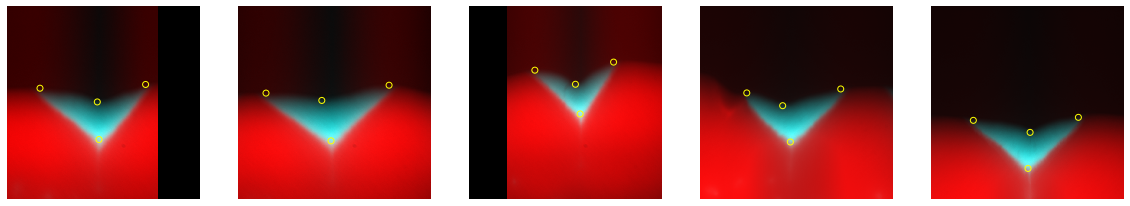

In [240]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);
fig, ax = plt.subplots(1,5, figsize=(20,5))

for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #i=1;
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0]; # 0.7
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0]; # 0.6
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);
    comp = Colony([dest[i+5],dest[i]], center=False); 
    img = comp.Image; #img = np.flip(img, axis=0);
    if(i==0):
        img = np.flip(img, axis=0); img[:,800:]=0;
    if(i==1):
        img = np.flip(img, axis=0);
    if(i==2):
        img = np.flip(img, axis=0); img[:,:200]=0;
    ax[i].imshow(img);
    ax[i].scatter(xl,yl, color='none', edgecolor='yellow');
    ax[i].scatter(xr,yr, color='none', edgecolor='yellow');
    ax[i].scatter(xu,yu, color='none', edgecolor='yellow');
    ax[i].scatter(xd,yd, color='none', edgecolor='yellow');
    ax[i].set_xticks([]); ax[i].set_yticks([]);
    ax[i].set_axis_off(); ax[i].margins(0,0);


In [241]:
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )

In [242]:
phid_expm4 = np.arctan( u/y )*180/np.pi
phis_expm4 = np.arctan( u/v2)*180/np.pi

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 

In [243]:
np.average(s1), np.average(s2), np.std(s1), np.std(s2), np.average(s2-s1)-(np.std(s1)+np.std(s2))/(10**0.5)

(70.39224006917497,
 73.93159318744634,
 1.023765139459667,
 3.81075461707544,
 2.0105437358979863)

# 0403 Supp Figures

### S1

In [454]:
os.listdir(dir0+'0919/M1')

['A1.tif',
 'A1m.tif',
 'A2.tif',
 'A2m.tif',
 'AA1.tif',
 'AA2.tif',
 'AAm1.tif',
 'AAm2.tif',
 'AmA1.tif',
 'AmA2.tif',
 'AmAm1.tif',
 'AmAm2.tif',
 'B1.tif',
 'B1m.tif',
 'B2.tif',
 'B2m.tif',
 'BB1.tif',
 'BB2.tif',
 'BBm1.tif',
 'BBm2.tif',
 'BmB1.tif',
 'BmB2.tif',
 'BmBm1.tif',
 'BmBm2.tif']

In [40]:
# Figure S1. Wildtype colonies reproducibly developed dents on fronts
# 1. Find wildtype monoculture replicate images
# either 2020/0704/Circle (3 reps), 0914/n1_1, 0914/n2_1, 0914/M1_1, 0914/M2, 
# 2. Plot as in Fig. 1a

In [452]:
imgs = np.zeros([2,11,1024,1024,3]);
for i in np.arange(2):
    for j in np.arange(9):
        if(j<3):
            dest = dir0+'2020/0704/Circle/';
            dest = dest + 'A'+str(i+1)+'_T4_'+str(j+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
            print(c.R*mpx)
        elif(j==3):
            dest = dir0+'0914/n1_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==4):
            dest = dir0+'0914/n2_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==5):
            dest = dir0+'0914/M1_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==6):
            dest = dir0+'0914/M2_1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==7):
            dest = dir0+'0919/N1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==8):
            dest = dir0+'0919/N2/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==9):
            dest = dir0+'0919/M1/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;
        elif(j==10):
            dest = dir0+'0919/M2/';
            dest = dest + 'A'+str(i+1)+'.tif';
            c = Colony([dest]); c.color(i);
            imgs[i,j] = c.Image;

3.3180707302227157
3.345456808252846
3.3169451186959886
3.3892092087956445
3.449230876200335
3.399054771556792


In [447]:
imgs2 = np.zeros([2,4,1024,1024,3]);
imgs2[0] = imgs[0, 3:7];
imgs2[1] = imgs[1, 3:7];

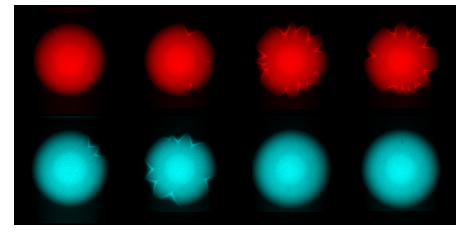

In [457]:
fig, ax = plt.subplots(2, 4, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(7.9,4) );
for i in np.arange(2):
    for j in np.arange(4):
        ax[i,j].imshow(imgs2[i,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('./fig_v1/s1a.pdf', bbox_inches='tight')

### S2?

In [384]:
imgs = np.zeros([2,12,1024,1024,3]);
str1 = ['A','B','C','D','E','W']
for i in np.arange(2):
    for j in np.arange(12):
        if(j<6):
            dest = dir0+'2020/0229/R1/';
            dest1 = dest + 'A'+str(i+1)+str1[j]+'_F_1.tif';
            dest2 = dest + 'A'+str(i+1)+str1[j]+'_F_2.tif';
            c = Colony([dest1, dest2], center=False);
            imgs[i,j] = c.Image;
        else:
            dest = dir0+'2020/0229/R2/';
            dest1 = dest + 'A'+str(i+1)+str1[j-6]+'_F_1.tif';
            dest2 = dest + 'A'+str(i+1)+str1[j-6]+'_F_2.tif';
            c = Colony([dest2]);  c.color(1);
            imgs[i,j] = c.Image;
        

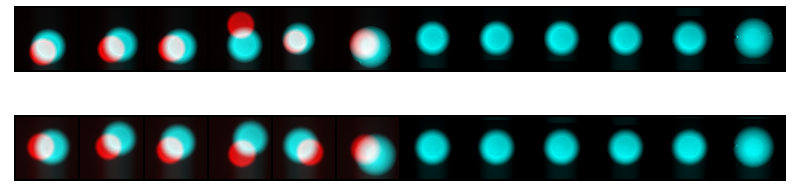

In [385]:
fig, ax = plt.subplots(2, 12, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(13.8,4) );
for i in np.arange(2):
    for j in np.arange(12):
        ax[i,j].imshow(imgs[i,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
#fig.savefig('./fig_v1/s1a.pdf', bbox_inches='tight')

### S2

In [41]:
# Figure S2. expansion rates are different between colors, but mutants are always slow growers

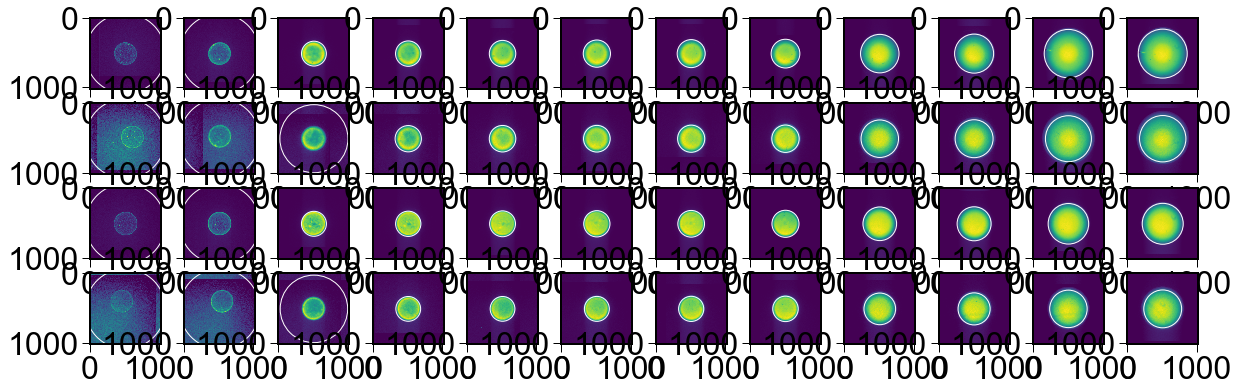

In [390]:
rs1 = np.zeros((4,8+2+2)); # from rep 1 folder, 0:wt1, 1:wt2, 2:mut1, 3: mut2
ts1 = np.zeros(12);
#rs2 = np.zeros((2, 6));
#ts2 = np.zeros(6);
fig, ax = plt.subplots(4,12, figsize=(20,6));
for i in np.arange(12): # first deal with rep1
    t = 0;
    if(i < 8):
        dw1 = dir0+'1015/MONO1/W1_01_'+str(i+1)+'.tif';
        dw2 = dir0+'1015/MONO1/W2_01_'+str(i+1)+'.tif';
        dm1 = dir0+'1015/MONO1/M1_01_'+str(i+1)+'.tif';
        dm2 = dir0+'1015/MONO1/M2_01_'+str(i+1)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; 
        ax[0,i].imshow(w1.Image); ax[0,i].add_patch(patch.Circle( (512,512), w1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[1,i].imshow(w2.Image); ax[1,i].add_patch(patch.Circle( (512,512), w2.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[2,i].imshow(m1.Image); ax[2,i].add_patch(patch.Circle( (512,512), m1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[3,i].imshow(m2.Image); ax[3,i].add_patch(patch.Circle( (512,512), m2.R, facecolor='None', edgecolor=(1,1,1) ))
        ts1[i] = t;
    elif(i in [8,9]):
        dw1 = dir0+'1016/MONO1/W1_01_'+str(i-7)+'.tif';
        dw2 = dir0+'1016/MONO1/W2_01_'+str(i-7)+'.tif';
        dm1 = dir0+'1016/MONO1/M1_01_'+str(i-7)+'.tif';
        dm2 = dir0+'1016/MONO1/M2_01_'+str(i-7)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; 
        ax[0,i].imshow(w1.Image); ax[0,i].add_patch(patch.Circle( (512,512), w1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[1,i].imshow(w2.Image); ax[1,i].add_patch(patch.Circle( (512,512), w2.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[2,i].imshow(m1.Image); ax[2,i].add_patch(patch.Circle( (512,512), m1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[3,i].imshow(m2.Image); ax[3,i].add_patch(patch.Circle( (512,512), m2.R, facecolor='None', edgecolor=(1,1,1) ))
        ts1[i] = t;
    else:
        dw1 = dir0+'1017/MONO1/W1_01_'+str(i-9)+'.tif';
        dw2 = dir0+'1017/MONO1/W2_01_'+str(i-9)+'.tif';
        dm1 = dir0+'1017/MONO1/M1_01_'+str(i-9)+'.tif';
        dm2 = dir0+'1017/MONO1/M2_01_'+str(i-9)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; 
        ax[0,i].imshow(w1.Image); ax[0,i].add_patch(patch.Circle( (512,512), w1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[1,i].imshow(w2.Image); ax[1,i].add_patch(patch.Circle( (512,512), w2.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[2,i].imshow(m1.Image); ax[2,i].add_patch(patch.Circle( (512,512), m1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[3,i].imshow(m2.Image); ax[3,i].add_patch(patch.Circle( (512,512), m2.R, facecolor='None', edgecolor=(1,1,1) ))
        ts1[i] = t;
#ts1 = ts1 - ts1[0];
ts1 = ts1 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

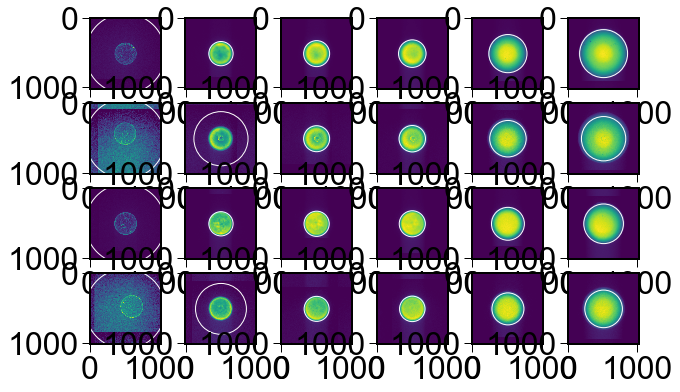

In [391]:
rs2 = np.zeros((4, 6));
ts2 = np.zeros(6);
fig, ax = plt.subplots(4,6, figsize=(10,6));
for i in np.arange(6): # first deal with rep1
    t = 0;
    if(i < 4):
        dw1 = dir0+'1015/MONO2/W1_01_'+str(i*2+1)+'.tif';
        dw2 = dir0+'1015/MONO2/W2_01_'+str(i*2+1)+'.tif';
        dm1 = dir0+'1015/MONO2/M1_01_'+str(i*2+1)+'.tif';
        dm2 = dir0+'1015/MONO2/M2_01_'+str(i*2+1)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; 
        ax[0,i].imshow(w1.Image); ax[0,i].add_patch(patch.Circle( (512,512), w1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[1,i].imshow(w2.Image); ax[1,i].add_patch(patch.Circle( (512,512), w2.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[2,i].imshow(m1.Image); ax[2,i].add_patch(patch.Circle( (512,512), m1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[3,i].imshow(m2.Image); ax[3,i].add_patch(patch.Circle( (512,512), m2.R, facecolor='None', edgecolor=(1,1,1) ))
        ts2[i] = t;
    elif(i ==4 ):
        dw1 = dir0+'1016/MONO2/W1_01_'+str(i-3)+'.tif';
        dw2 = dir0+'1016/MONO2/W2_01_'+str(i-3)+'.tif';
        dm1 = dir0+'1016/MONO2/M1_01_'+str(i-3)+'.tif';
        dm2 = dir0+'1016/MONO2/M2_01_'+str(i-3)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; 
        ax[0,i].imshow(w1.Image); ax[0,i].add_patch(patch.Circle( (512,512), w1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[1,i].imshow(w2.Image); ax[1,i].add_patch(patch.Circle( (512,512), w2.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[2,i].imshow(m1.Image); ax[2,i].add_patch(patch.Circle( (512,512), m1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[3,i].imshow(m2.Image); ax[3,i].add_patch(patch.Circle( (512,512), m2.R, facecolor='None', edgecolor=(1,1,1) ))
        ts2[i] = t;
    else:
        dw1 = dir0+'1017/MONO2/W1_01_'+str(i-4)+'.tif';
        dw2 = dir0+'1017/MONO2/W2_01_'+str(i-4)+'.tif';
        dm1 = dir0+'1017/MONO2/M1_01_'+str(i-4)+'.tif';
        dm2 = dir0+'1017/MONO2/M2_01_'+str(i-4)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; 
        ax[0,i].imshow(w1.Image); ax[0,i].add_patch(patch.Circle( (512,512), w1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[1,i].imshow(w2.Image); ax[1,i].add_patch(patch.Circle( (512,512), w2.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[2,i].imshow(m1.Image); ax[2,i].add_patch(patch.Circle( (512,512), m1.R, facecolor='None', edgecolor=(1,1,1) ))
        ax[3,i].imshow(m2.Image); ax[3,i].add_patch(patch.Circle( (512,512), m2.R, facecolor='None', edgecolor=(1,1,1) ))
        ts2[i] = t;
#ts2 = ts2 - ts2[0];
ts2 = ts2 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

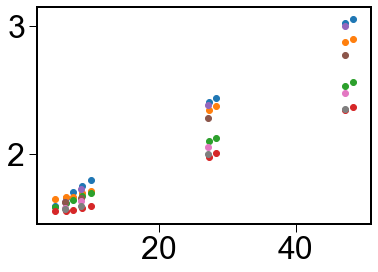

In [392]:
for i in np.arange(4):
    plt.scatter(ts1[3:]-ts1[0], rs1[i,3:]*mpx)
for i in np.arange(4):
    plt.scatter(ts2[2:]-ts2[0], rs2[i,2:]*mpx)

In [290]:
rs1.shape

(4, 12)

In [407]:
ys1 = np.zeros((4,6));
ys2 = np.zeros((4,3));
yf = np.zeros((4,10));
xs1 = ts1[-6:]-ts1[0];
xs2 = ts2[-3:]-ts2[0];
for i in np.arange(4):
    ys1[i] = (rs1[i]*mpx)[-6:];
    ys2[i] = (rs2[i]*mpx)[-3:];
ys = np.concatenate([ys1, ys2], axis=-1);
xs = np.concatenate([xs1, xs2], axis=-1);
print(ys.shape)
for i in np.arange(4):
    sol = curve_fit(linf, xdata=xs, ydata=ys[i])
    yf[i] = np.linspace(0, 50, 10)*sol[0][0]+sol[0][1];
    print(sol[0][0], sol[1][0,0])

(4, 9)
0.03303634194847795 3.07809131975606e-07
0.030162623561544 1.5798744523832765e-06
0.022330397816478026 2.9286793667577705e-07
0.019917588615530803 2.488794067000923e-07


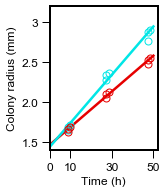

In [419]:
fig, ax = plt.subplots(figsize=(1.5,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.margins(0,0);
plt.setp(ax.get_yticklabels(), Fontsize=fsz);
plt.setp(ax.get_xticklabels(), Fontsize=fsz);

#ax.errorbar(xs, ys[0], linestyle='none', marker='o', mfc='none', markersize=10, color=(0.9,0,0));
ax.errorbar(xs, ys[1], linestyle='none', marker='o', mfc='none', markersize=7, color=(0,0.9,0.9));
ax.errorbar(xs, ys[2], linestyle='none', marker='o', mfc='none', markersize=7, color=(0.9,0,0));
#ax.errorbar(xs, ys[3], linestyle='none', marker='o', mfc='none', markersize=10, color=(0,0.9,0.9));
ax.plot(np.linspace(0,50,10), yf[2], color=(0.9,0,0), linewidth=2.5);
ax.plot(np.linspace(0,50,10), yf[1], color=(0,0.9,0.9), linewidth=2.5);
ax.set_xlim( 0,52 )
ax.set_ylim(1.4,3.2)
ax.set_xlabel('Time (h)',fontsize=fsz*1.5)
ax.set_yticks([1.5,2.,2.5,3]); ax.set_yticklabels([1.5,2.,2.5,3],fontsize=fsz*1.5)
ax.set_xticks([0,10,30,50]); ax.set_xticklabels([0,10,30,50],fontsize=fsz*1.5);
ax.set_ylabel('Colony radius (mm)',fontsize=fsz*1.5)
#ax.legend([r'$34\ \mu m/hr$',r'$0.022\ {\rm mm/hr}$'], fontsize=fsz)

fig.savefig('./fig_v1/s2.pdf', bbox_inches='tight')

### S3

In [341]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
timages = np.zeros((10,3,1024,1024,3))
ts = np.zeros(10);
for i in np.arange(10):
    t = 0;
    if(i<5):
        dm = dir0+'1015/COMP01/WM991_2_'+str(i+1)+'.tif';
        dw = dir0+'1015/COMP01/WM991_1_'+str(i+1)+'.tif';
        w = Colony([dw]); t = os.path.getmtime(dw); 
        ts[i] = t/3600;
        continue;
    if(i<8):
        for j in np.arange(2):
            dm = dir0+'1015/COMP01/WM991_2_'+str(i+1)+'.tif';
            dw = dir0+'1015/COMP01/WM991_1_'+str(i+1)+'.tif';
            w = Colony([dw]); t= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    elif(i<9):
         for j in np.arange(2):
            dm = dir0+'1016/COMP01/WM991_2_1.tif';
            dw = dir0+'1016/COMP01/WM991_1_1.tif';
            w = Colony([dw]); t= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    else:
         for j in np.arange(2):
            dm = dir0+'1017/COMP01/WM991_2_1.tif';
            dw = dir0+'1017/COMP01/WM991_1_1.tif';
            w = Colony([dw]); t= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    ts[i] = t/3600;

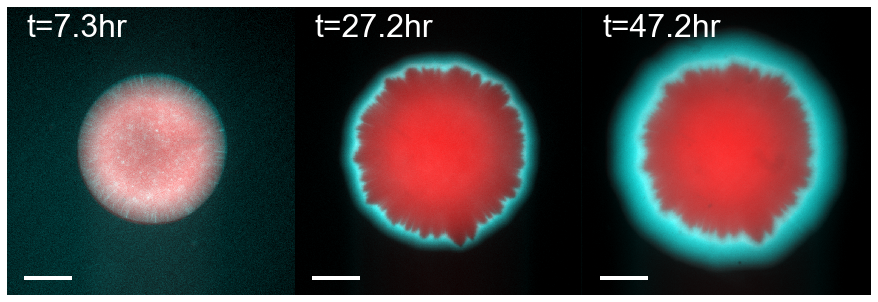

In [347]:
fig, ax = plt.subplots(1,3, figsize=(1*12, 1*4));
#plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 130;


#img = np.zeros((1024,1024,3));
#for i in np.arange(3):
#    img[:,:,i] = comp0.Image[:,:,i]*filt
inds = [5,8,9];
for i in np.arange(3):
    ax[i].set_xlim(margin,1024-margin); ax[i].set_ylim(1024-margin,margin);
    ax[i].set_xticks([]); ax[i].set_yticks([]);
    ax[i].imshow(timages[inds[i],0]/np.max(timages[inds[i],0])+timages[inds[i],1]/np.max(timages[inds[i],1]))
    ax[i].set_axis_off()
    ax[i].plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=4 )
    ax[i].margins(0,0)
    ax[i].text( 50+margin, 80+margin, 't='+str(ts[inds[i]]-ts[0])[:3+inds[i]//7]+'hr', color=(1,1,1) )

fig.savefig('./fig_v1/s3c.pdf', bbox_inches='tight')


### S3

In [166]:
# competition outcome robust under color exchange

In [352]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91','WM11','WM19','WM199'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

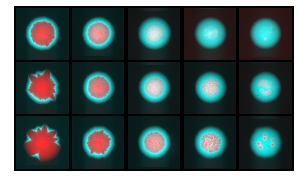

In [353]:
fig, ax = plt.subplots(3, 5, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(5,3) );
for i in np.arange(3):
    for j in np.arange(5):
        ax[i,j].imshow(comps[i,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('./fig_v1/s4.pdf', bbox_inches='tight')

### S5

In [166]:
# competition outcome robust under color exchange

In [424]:
str1 = ['01','001','0001'];
str2 = ['MW199','MW19','MW11','MW91','MW991'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif'], norm=False).Image;

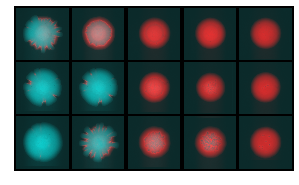

In [425]:
fig, ax = plt.subplots(3, 5, gridspec_kw={'wspace':0.,'hspace':0.}, figsize=(5,3) );
imgs = np.copy(comps);
imgs[:,:,:,:,1:]*=4;
for i in np.arange(3):
    for j in np.arange(5):
        ax[i,j].imshow(imgs[i,j]*4);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('./fig_v1/s5.pdf', bbox_inches='tight')

### S7

In [188]:
os.listdir(dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X')

['1_C1.tif',
 '1_C2.tif',
 '2_C1.tif',
 '2_C2.tif',
 '3_C1.tif',
 '3_C2.tif',
 '4_C1.tif',
 '4_C2.tif']

In [314]:
dest1 = dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X/1_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X/1_C2.tif';
comp1 = Colony([dest1,dest2], center=False, norm=False);
dest1 = dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X/2_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X/2_C2.tif';
comp2 = Colony([dest1,dest2], center=False, norm=False);
dest1 = dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X/3_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A2A1M_OD0001/40X/3_C2.tif';
comp3 = Colony([dest1,dest2], center=False, norm=False);
t0= os.path.getmtime(dir0+'2020/0704/razor/start.txt');  
t = os.path.getmtime(dest1);  
print((t-t0)/3600)
#C:\Users\Hyun\Dropbox (MIT)\MRE_photos\photos\2020\0704\razor\T4\A1A2M_OD0001\10X

48.388888888888886


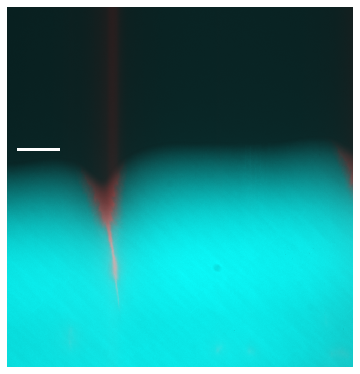

In [321]:
fig, ax = plt.subplots(1,1, figsize=(5, 5));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 20;
ax.set_xlim(margin,1024-margin); 
ax.set_ylim(0,1024);
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow(comp3.Image*3)
ax.set_axis_off()
ax.plot( np.linspace(0, 1/mpx, 10)+50, np.ones(10)*620, color=(1,1,1), linewidth=3)
ax.set_axis_off(); ax.margins(0,0);
#fig.savefig('./fig_v1/3a1.pdf', bbox_inches='tight')

# 0223 Main Figures again

## Fig. 1a

### 1a1

In [220]:
dr = dir0+'0914/n2_1/A1.tif' 
r = Colony([dr]); r.color(0);
dc = dir0+'0914/n2_1/A2.tif'   #'0901R1/A2.tif';
c = Colony([dc]); c.color(1);

In [225]:
img = np.copy(c.Image);
img[:512] = np.copy(r.Image[:512]);
img = np.flip(img, axis=0);

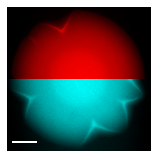

In [236]:
fig, ax = plt.subplots(figsize=(2,2));
margin = 150;
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.imshow(img, cmap=plt.get_cmap('Greys_r'));
ax.set_xlim(1024-margin,margin);
ax.set_ylim(margin,1024-margin);
ax.set_axis_off(); ax.margins(0,0);
ax.plot( np.linspace(0, 1/mpx, 10)+880-margin, np.ones(10)*44+margin, color=(1,1,1), linewidth=2 )
fig.savefig('./fig_v1/1a1c.pdf', bbox_inches='tight')

### 1a2, 1a3

In [20]:
dest = dir0+'1017/MONO2/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO2/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

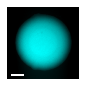

In [65]:
fig, ax = plt.subplots(1,1, figsize=(1, 1));
#plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
margin = 130;
ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.set_axis_off(); ax.margins(0,0);
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=2 )
#ax.imshow(w01.Image)
#fig.savefig('./fig_v1/1a2.pdf', bbox_inches='tight')
#ax.imshow(m01.Image)
#fig.savefig('./fig_v1/1a3.pdf', bbox_inches='tight')

### 1a4

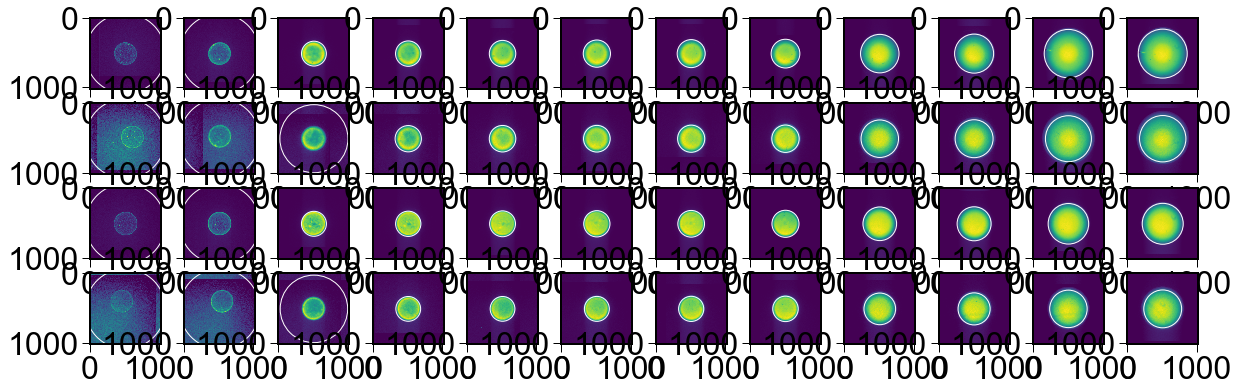

In [390]:
rs1 = np.zeros((4,8+2+2)); # from rep 1 folder, 0:wt1, 1:wt2, 2:mut1, 3: mut2
ts1 = np.zeros(12);
#rs2 = np.zeros((2, 6));
#ts2 = np.zeros(6);
fig, ax = plt.subplots(4,12, figsize=(20,6));
for i in np.arange(12): # first deal with rep1
    t = 0;
    if(i < 8):
        dw1 = dir0+'1015/MONO1/W1_01_'+str(i+1)+'.tif';
        dw2 = dir0+'1015/MONO1/W2_01_'+str(i+1)+'.tif';
        dm1 = dir0+'1015/MONO1/M1_01_'+str(i+1)+'.tif';
        dm2 = dir0+'1015/MONO1/M2_01_'+str(i+1)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; ts1[i] = t;
    elif(i in [8,9]):
        dw1 = dir0+'1016/MONO1/W1_01_'+str(i-7)+'.tif';
        dw2 = dir0+'1016/MONO1/W2_01_'+str(i-7)+'.tif';
        dm1 = dir0+'1016/MONO1/M1_01_'+str(i-7)+'.tif';
        dm2 = dir0+'1016/MONO1/M2_01_'+str(i-7)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; ts1[i] = t;
    else:
        dw1 = dir0+'1017/MONO1/W1_01_'+str(i-9)+'.tif';
        dw2 = dir0+'1017/MONO1/W2_01_'+str(i-9)+'.tif';
        dm1 = dir0+'1017/MONO1/M1_01_'+str(i-9)+'.tif';
        dm2 = dir0+'1017/MONO1/M2_01_'+str(i-9)+'.tif';
        w1 = Colony([dw1]); rs1[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs1[1,i]=w2.R; 
        m1 = Colony([dm1]); rs1[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs1[3,i]=m2.R; ts1[i] = t;
#ts1 = ts1 - ts1[0];
ts1 = ts1 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

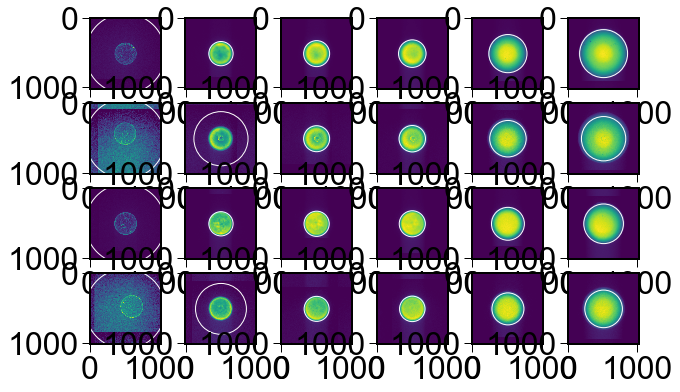

In [391]:
rs2 = np.zeros((4, 6));
ts2 = np.zeros(6);
for i in np.arange(6): # first deal with rep1
    t = 0;
    if(i < 4):
        dw1 = dir0+'1015/MONO2/W1_01_'+str(i*2+1)+'.tif';
        dw2 = dir0+'1015/MONO2/W2_01_'+str(i*2+1)+'.tif';
        dm1 = dir0+'1015/MONO2/M1_01_'+str(i*2+1)+'.tif';
        dm2 = dir0+'1015/MONO2/M2_01_'+str(i*2+1)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; ts2[i] = t;
    elif(i ==4 ):
        dw1 = dir0+'1016/MONO2/W1_01_'+str(i-3)+'.tif';
        dw2 = dir0+'1016/MONO2/W2_01_'+str(i-3)+'.tif';
        dm1 = dir0+'1016/MONO2/M1_01_'+str(i-3)+'.tif';
        dm2 = dir0+'1016/MONO2/M2_01_'+str(i-3)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; ts2[i] = t;
    else:
        dw1 = dir0+'1017/MONO2/W1_01_'+str(i-4)+'.tif';
        dw2 = dir0+'1017/MONO2/W2_01_'+str(i-4)+'.tif';
        dm1 = dir0+'1017/MONO2/M1_01_'+str(i-4)+'.tif';
        dm2 = dir0+'1017/MONO2/M2_01_'+str(i-4)+'.tif';
        w1 = Colony([dw1]); rs2[0,i]=w1.R; t+= os.path.getmtime(dw1)/3600; 
        w2 = Colony([dw2], thres=0.5); rs2[1,i]=w2.R; 
        m1 = Colony([dm1]); rs2[2,i]=m1.R; 
        m2 = Colony([dm2], thres=0.5); rs2[3,i]=m2.R; ts2[i] = t;
#ts2 = ts2 - ts2[0];
ts2 = ts2 - os.path.getmtime(dir0+'1015/start/A1_01.tif')/3600;

In [407]:
ys1 = np.zeros((4,6));
ys2 = np.zeros((4,3));
yf = np.zeros((4,10));
xs1 = ts1[-6:]-ts1[0];
xs2 = ts2[-3:]-ts2[0];
for i in np.arange(4):
    ys1[i] = (rs1[i]*mpx)[-6:];
    ys2[i] = (rs2[i]*mpx)[-3:];
ys = np.concatenate([ys1, ys2], axis=-1);
xs = np.concatenate([xs1, xs2], axis=-1);
print(ys.shape)
for i in np.arange(4):
    sol = curve_fit(linf, xdata=xs, ydata=ys[i])
    yf[i] = np.linspace(0, 50, 10)*sol[0][0]+sol[0][1];
    print(sol[0][0], sol[1][0,0])

(4, 9)
0.03303634194847795 3.07809131975606e-07
0.030162623561544 1.5798744523832765e-06
0.022330397816478026 2.9286793667577705e-07
0.019917588615530803 2.488794067000923e-07


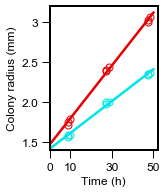

In [420]:
fig, ax = plt.subplots(figsize=(1.5,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.margins(0,0);
plt.setp(ax.get_yticklabels(), Fontsize=fsz);
plt.setp(ax.get_xticklabels(), Fontsize=fsz);

ax.errorbar(xs, ys[0], linestyle='none', marker='o', mfc='none', markersize=7, color=(0.9,0,0));
#ax.errorbar(xs, ys[1], linestyle='none', marker='o', mfc='none', markersize=10, color=(0,0.9,0.9));
#ax.errorbar(xs, ys[2], linestyle='none', marker='o', mfc='none', markersize=10, color=(0.9,0,0));
ax.errorbar(xs, ys[3], linestyle='none', marker='o', mfc='none', markersize=7, color=(0,0.9,0.9));
ax.plot(np.linspace(0,50,10), yf[0], color=(0.9,0,0), linewidth=2.5);
ax.plot(np.linspace(0,50,10), yf[3], color=(0,0.9,0.9), linewidth=2.5);
ax.set_xlim( 0,52 )
ax.set_ylim(1.4,3.2)
ax.set_xlabel('Time (h)',fontsize=fsz*1.5)
ax.set_yticks([1.5,2.,2.5,3]); ax.set_yticklabels([1.5,2.,2.5,3],fontsize=fsz*1.5)
ax.set_xticks([0,10,30,50]); ax.set_xticklabels([0,10,30,50],fontsize=fsz*1.5);
ax.set_ylabel('Colony radius (mm)',fontsize=fsz*1.5)
#ax.legend([r'$34\ \mu m/hr$',r'$0.022\ {\rm mm/hr}$'], fontsize=fsz)

fig.savefig('./fig_v1/1a4.pdf', bbox_inches='tight')

## Fig. 1b

In [52]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91','WM11','WM19','WM199'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

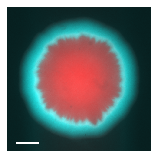

In [128]:
margin = 130;
fig, ax = plt.subplots(figsize=(2,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.imshow(comps[0,0]);
ax.set_axis_off(); ax.margins(0,0);
ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=2 )
fig.savefig('./fig_v1/1b1.pdf', bbox_inches='tight')

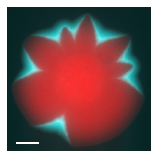

In [129]:
fig, ax = plt.subplots(figsize=(2,2));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
ax.imshow(comps[2,0]);
ax.set_axis_off(); ax.margins(0,0);
ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=2 )
fig.savefig('./fig_v1/1b2.pdf', bbox_inches='tight')

## Fig. 1c

In [85]:
dest1 = dir0+'1017/COMP0001/WM991_1_1.tif';
dest2 = dir0+'1017/COMP0001/WM991_2_1.tif';
comp = Colony([dest1,dest2]);

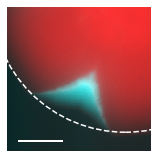

In [135]:
fig, ax = plt.subplots(1,1, figsize=(2, 2));
plt.rcParams.update({'font.size': fsz})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_axis_off()
img = np.copy(np.flip(comp.Image, axis=0));
ax.imshow( img )
ax.add_patch(patch.Circle( (512,512), 353, facecolor='none', edgecolor=(1,1,1),linestyle='--', linewidth=1.5 ))
#ax.add_patch(patch.FancyArrow( 420,340,0,-20, width=1, length_includes_head=True, head_width=2, color=(1,1,1), alpha=1  ))
s = 380;
ax.set_xlim(200,200+s); ax.set_ylim(110,110+s);
ax.plot( np.linspace(0, 1/mpx, 10)+ 230, np.ones(10)*135, color=(1,1,1), linewidth=2 )
#ax.text(350, 345, 'Mutant emerges', color=(1,1,1))
#ax.text(440, 450, 'Wildtype', color=(1,1,1))
fig.savefig('./fig_v1/1c.pdf', bbox_inches='tight')

## Fig. 2a

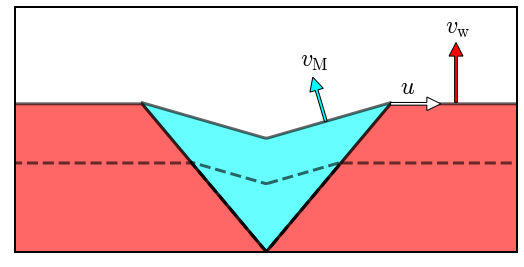

In [420]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-2,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),2,100);
xyw[400:500,0]=np.ones(100)*2; xyw[500:600,0]=np.linspace(2,-2,100); xyw[600:,0]=np.ones(100)*(-2);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);



fig, ax = plt.subplots(figsize=(9,4.5)  )
plt.rcParams.update({'font.size': fsz})
ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=0.6, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.6, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xym*0.6, facecolor='none', alpha=0.6, linewidth=3, linestyle='--', edgecolor='k') )
ax.add_patch(patch.Polygon(xyw*0.6, facecolor='none', alpha=0.6, linewidth=3, linestyle='--', edgecolor='k') )
ax.add_patch(patch.FancyArrow( 0.68,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))

ax.add_patch(patch.FancyArrow( -xym[320,0],xym[320,1],0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1,1.0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( xb[-1],yb[-1],0.18,0, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) ,alpha=1  ))


ax.text(0.64, 0.8, r'$v_{\rm w} $', color=(0,0,0), fontsize=24)
ax.text(0.12, 0.68, r'$v_{\rm M} $', color=(0,0,0), fontsize=24)
ax.text(0.48, 0.58, r'$u$', color=(0,0,0), fontsize=24)
ax.set_xlim(-0.9,0.9)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);
ax.margins(0,0);
fig.savefig('./fig_v1/2a.pdf', bbox_inches='tight')

## Fig. 2b

### 2b1

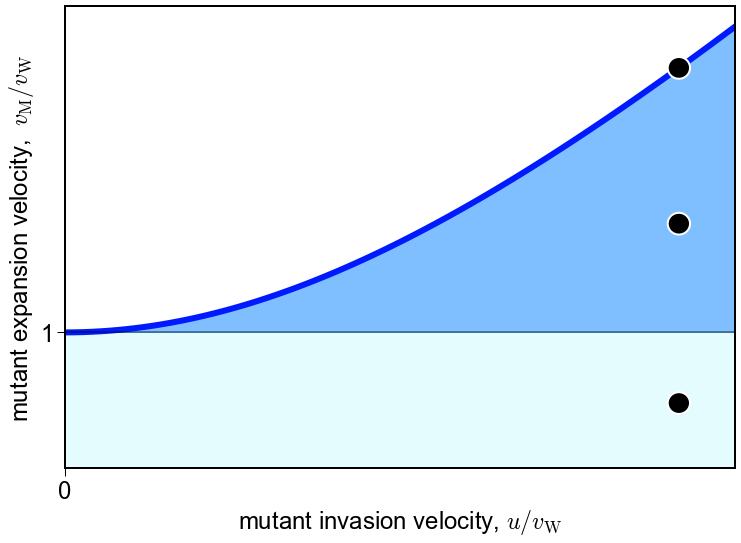

In [467]:
fig, ax = plt.subplots(figsize = (12,8.5) );

xs = np.linspace(0,1.6**2-1,100);
ys1 = np.sqrt(1 + xs**2);
xyf = np.zeros((300,2));
xyf[:100,0]=xs; xyf[:100,1]=ys1;
xyf[100:200,0]=np.flip(xs); xyf[100:200,1]=np.ones(100)*ys1[-1];
xyf[200:,0]=0; xyf[200:,1]=np.flip(ys1);

xy2 = np.zeros((300,2));
xy2[:100,0]=xs; xy2[:100,1]=ys1;
xy2[100:200,0]=np.ones(100)*xs[-1]; xy2[100:200,1]=np.flip(ys1);
xy2[200:,0]=np.flip(xs); xy2[200:,1]=np.ones(100)*1;

ax.add_patch(patch.Polygon(xyf,  facecolor=(1.,1.,1.), alpha=1) )
ax.add_patch(patch.Polygon(xy2, color=(0,0.5,1.), alpha=0.5) )
ax.add_patch(patch.Rectangle( (0,0.75),1.2,0.25 , color=(0,0.9,1.), alpha=0.1) )
#ax.add_patch(patch.Rectangle( (-0.5,0),0.5,10 , fill=False) )
ax.plot(xs, ys1, color=(0.,0.1,1.0), alpha=1, linewidth=6)
ax.plot(xs, xs*0+1, color='k', alpha=0.5)
ax.add_patch( patch.Circle( ( 1.1, (1+1.1**2)**0.5 ), 0.02, facecolor='k', edgecolor='w', linewidth=2, zorder=10 )  );
ax.add_patch( patch.Circle( ( 1.1, 1.2 ), 0.02, facecolor='k', edgecolor='w', linewidth=2 ) );
ax.add_patch( patch.Circle( ( 1.1, 0.87 ), 0.02, facecolor='k', edgecolor='w', linewidth=2 ) );

ax.set_xlim(0.0,1.2);
ax.set_ylim(0.75,1.6);
ax.set_xlabel('mutant invasion velocity, '+r'$u/v_{\rm W}$', fontsize=24);
ax.set_ylabel('mutant expansion velocity,  '+r'$v_{\rm M}/v_{\rm W}$', fontsize=24);

ax.set_yticks([1]); ax.set_xticks([0]); #ax.set_yticklabels([r'$v_{\rm W}$'])
plt.setp(ax.get_yticklabels(), Fontsize=24);
plt.setp(ax.get_xticklabels(), Fontsize=24);
ax.margins(0,0);
fig.savefig('./fig_v1/2b.pdf', bbox_inches='tight')

### 2b2

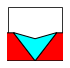

In [59]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xym1 = np.copy(xym);
xywl = np.zeros((400,2));
xywl[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl[200:300,0] = np.linspace(0,-0.5,100); xywl[300:400,0]=np.ones(100)*(-0.5);
xywl[:100,1]=np.ones(100)*np.max(yb); xywl[100:200,1]=np.linspace(np.max(yb),0,100);
xywl[200:300,1] = np.zeros(100); xywl[300:400,1]=np.linspace(0,np.max(yb),100);
xywr = np.copy(xywl); xywr[:,0]=xywr[:,0]*(-1);

fig, ax = plt.subplots(figsize=(1,1)  )
rs=1.3; p0=(0.5,0); a=1;
ax.set_axis_off(); ax.margins(0,0);
ax.add_patch(patch.Rectangle( (0.01,0),0.98,0.99 , facecolor=(1,1,1), edgecolor='k', alpha=0.8  ) )
ax.add_patch(patch.Polygon(xywl*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xym*rs+p0, facecolor=(0,1,1), edgecolor='k', alpha=a ) )
#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )
fig.savefig('./fig_v1/2b2.pdf', bbox_inches='tight')

### 2b3

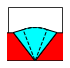

In [60]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
r=0.47;
param = (0.3,r,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );


l1 = len(xps[xps>0]);  l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2+l3 ) * 2,2));
xym[:l2,0] = xr2[xr2<min(xps)]; xym[l2:l2+l1,0] = xps[xps>0]; xym[l2+l1:l2+l1+l3,0] = np.flip(xb);
xym[-l1-l2-l3:-l1-l2,0] = -xb; xym[-l2-l1:-l2,0] = -np.flip(xps[xps>0]); xym[-l2:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l2,1] = yr2[xr2<min(xps)]; xym[l2:l2+l1,1] = yps[xps>0]; xym[l2+l1:l2+l1+l3,1] = np.flip(yb);
xym[-l2:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l2,1] = np.flip(yps[xps>0]); xym[-l2-l1-l3:-l2-l1,1] = yb;
xym2 = np.copy(xym);

fig, ax = plt.subplots(figsize=(1,1)  )
rs=1.3; p0=(0.5,0); a=1;
ax.set_axis_off(); ax.margins(0,0);
ax.add_patch(patch.Rectangle( (0.01,0),0.98,0.99 , facecolor='w', edgecolor='k', alpha=0.8  ) )
ax.add_patch(patch.Polygon(xywl*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Wedge( p0, r*rs, np.arctan(4/3)*180/np.pi, 180-np.arctan(4/3)*180/np.pi, facecolor=(0,1,1), edgecolor='k', alpha=1 )  )
ax.add_patch(patch.Polygon(xym*rs+p0, facecolor=(0,1,1), edgecolor='k', alpha=a ) )
ax.add_patch(patch.Wedge( p0, r*rs, np.arctan(8/3)*180/np.pi, 180-np.arctan(8/3)*180/np.pi, facecolor=(0,1,1), edgecolor='k', linestyle='--', alpha=1 )  )
#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )
fig.savefig('./fig_v1/2b3.pdf', bbox_inches='tight')

### 2b4

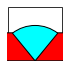

In [57]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.55,0.4);
param2 = ((0.55**2-0.4**2)**0.5,0.55,0.4);

xps, yps = xyp(1, np.arange(100)/100, param2 )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param2[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

fig, ax = plt.subplots(figsize=(1,1)  )
rs=1.3; p0=(0.5,0); a=1;
ax.set_axis_off(); ax.margins(0,0);
ax.add_patch(patch.Rectangle( (0.01,0),0.98,0.99 , facecolor='w', edgecolor='k', alpha=0.8  ) )
ax.add_patch(patch.Polygon(xywl*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Wedge( p0, 0.5*rs, np.arctan(5/4)*180/np.pi, 180-np.arctan(5/4)*180/np.pi, facecolor=(0,1,1), edgecolor='k', alpha=1 )  )

#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )
fig.savefig('./fig_v1/2b4.pdf', bbox_inches='tight')

## Fig. 3a

### 3a1

In [132]:
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C2.tif';
comp1 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C2.tif';
comp2 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C2.tif';
comp3 = Colony([dest1,dest2]);
t0= os.path.getmtime(dir0+'2020/0704/razor/start.txt');  
t = os.path.getmtime(dest1);  
print((t-t0)/3600)
#C:\Users\Hyun\Dropbox (MIT)\MRE_photos\photos\2020\0704\razor\T4\A1A2M_OD0001\10X

47.97888888888889


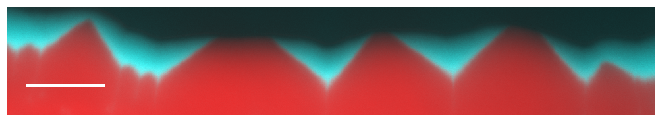

In [133]:
fig, ax = plt.subplots(1,1, figsize=(9, 1.5));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 20;
ax.set_xlim(margin,1024-margin); 
ax.set_ylim(575,575+(1024-margin*2)/6);
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow(comp2.Image)
ax.set_axis_off()
ax.plot( np.linspace(0, 1/mpx, 10)+50, np.ones(10)*620, color=(1,1,1), linewidth=3)
ax.set_axis_off(); ax.margins(0,0);
#fig.savefig('./fig_v1/3a1.pdf', bbox_inches='tight')

In [10]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);

for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        #inds2 = np.nonzero( img1[:,j]>0.1 )[0];
        #if( len(inds2)>0 ):
        #    b2[j] = np.max(inds2);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);


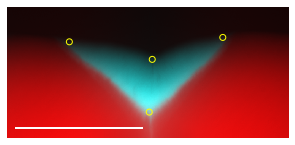

In [11]:
i=4;
fig, ax = plt.subplots(figsize=(5.1,5.17*7/15))
#ax.plot( np.arange(L), b1 );
#ax.plot( np.arange(L), b2 );
#ax.plot( np.arange(L), b3 );
#ax.plot( np.arange(L), b4 );
comp = Colony([dest[i+5],dest[i]], center=False); 
img = comp.Image; #img = np.flip(img, axis=0);
ax.imshow(img);
#ax.imshow(img2, cmap=plt.cm.gray);
pol = np.zeros((5,2)); pol[0]=[xl,yl]; pol[1]=[xu,yu]; pol[2]=[xr,yr]; pol[3]=[xd,yd]; pol[4]=[xl,yl];
#ax.add_patch(patch.Polygon(pol, facecolor='none',edgecolor=(1,1,1), linestyle='--') )

ax.scatter(xl,yl, color='none', edgecolor='yellow');
ax.scatter(xr,yr, color='none', edgecolor='yellow');
ax.scatter(xu,yu, color='none', edgecolor='yellow');
ax.scatter(xd,yd, color='none', edgecolor='yellow');

#ax.plot( np.ones(10)*517, np.linspace(750,900,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+910; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
#ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,770,r'$\phi_{\rm B}$', color=(1,1,1), fontsize=fsz*4)
#ax.plot( np.ones(10)*517, np.linspace(550,700,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+750; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
#ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,620,r'$\phi_{\rm D}$', color=(1,1,1), fontsize=fsz*4)
#ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
#r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
#ys = ys[:95]; xs = xs[:95];
#ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_{\rm d}$', fontsize=16)
#ax.text(-0.04,3/15,'Mutant')
#ax.text(-0.05,-1/15,'Wildtype')
ax.plot( np.linspace(0, 4/mpx, 10)+30, np.ones(10)*920, color=(1,1,1), linewidth=2 )

ax.set_xticks([]); ax.set_yticks([]);
ax.set_ylim(1024*14/15,1024*7/15)
ax.set_axis_off(); ax.margins(0,0);
#fig.savefig('./fig_v1/3a2.pdf', bbox_inches='tight')
#fig.savefig('1201_3c2_newc.png',bbox_inches='tight')

In [12]:
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
phid_expm4 = np.arctan( u/y )*180/np.pi
phis_expm4 = np.arctan( u/v2)*180/np.pi

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 

In [29]:
(20/33)**2/2-1

-0.8163452708907254

70.392$\pm$1.023 0.323742962977247
73.931$\pm$3.810 1.205066419396117


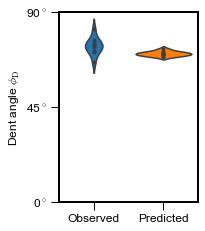

In [285]:
#####
mpl.rcParams['font.size'] = fsz*1.5;

fig, ax = plt.subplots(1,1,  figsize=(2.5, 3.5) )

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 
xs = np.concatenate([s2*0+1,s1*0+2]);
sns.violinplot( x=xs, y=np.concatenate([s2,s1]), inner='point', saturation=1, ax=ax )
print(np.str( np.average(s1) )[:6]+'$\pm$'+np.str( np.std(s1) )[:5], np.std(s1)/(10**0.5))
print(np.str( np.average(s2) )[:6]+'$\pm$'+np.str( np.std(s2) )[:5], np.std(s2)/(10**0.5))
#ax.text(1.6, 40, '70.4'+'$\pm$'+'1.0',fontsize=fsz*1.5)
#ax.text(0.6, 40, '73.9'+'$\pm$'+'3.8',fontsize=fsz*1.5)
ax.set_xticks([0,1]);
ax.set_xticklabels(['Observed','Predicted'] ,fontsize=fsz*1.5)
ax.set_xlim(-0.5,1.5)
ax.set_ylim(0,90)
ax.set_ylabel('Dent angle '+r'$\phi_\mathrm{D}$', fontsize=fsz*1.5)
ax.set_yticks([0,45,90]);
ax.set_yticklabels(['0'+r'$^\circ$','45'+r'$^\circ$','90'+r'$^\circ$']);
ax.margins(0,0);
fig.savefig('./fig_v1/3c_b.pdf', bbox_inches='tight')

71.06$\pm$1.237
73.93$\pm$3.810


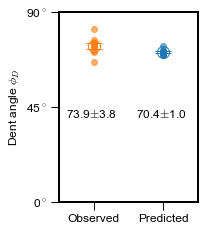

In [160]:
#####
mpl.rcParams['font.size'] = fsz*1.5;

fig, ax = plt.subplots(1,1,  figsize=(2.5, 3.5) )

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 
#s1=v1/v2; s2 = vr_expm1; 
sns.violinplot( x=s1*0+1, y=s1 )
ax.scatter(s1*0+2, s1, marker='o', alpha=0.6 );
ax.scatter(s2*0+1, s2, marker='o', alpha=0.6 );
#pol = np.zeros((5,2)); pol[0]=[0,np.average(s1)+np.std(s1)/(10**0.5)]; pol[1]=[0,np.average(s1)-np.std(s1)/(10**0.5)]; pol[2]=[3,np.average(s1)-np.std(s1)/(10**0.5)]; pol[3]=[3,np.average(s1)+np.std(s1)/(10**0.5)]; pol[4]=pol[0];
#ax.add_patch(patch.Polygon(pol, facecolor=(0,0.5,1), alpha=0.1) )
#pol = np.zeros((5,2)); pol[0]=[0,np.average(s2)+np.std(s2)/(10**0.5)]; pol[1]=[0,np.average(s2)-np.std(s2)/(10**0.5)]; pol[2]=[3,np.average(s2)-np.std(s2)/(10**0.5)]; pol[3]=[3,np.average(s2)+np.std(s2)/(10**0.5)]; pol[4]=pol[0];
#ax.add_patch(patch.Polygon(pol, facecolor=(1,0.,0), alpha=0.1) )
ax.errorbar(2, np.average(s1), yerr=np.std(s1)/(10**0.5), marker='o', mfc='none', ms=12, capsize=8 );
ax.errorbar(1., np.average(s2), yerr=np.std(s2)/(10**0.5), marker='o', mfc='none', ms=12, capsize=8 );
print(np.str( np.average(s1) )[:5]+'$\pm$'+np.str( np.std(s1) )[:5])
print(np.str( np.average(s2) )[:5]+'$\pm$'+np.str( np.std(s2) )[:5])
ax.text(1.6, 40, '70.4'+'$\pm$'+'1.0',fontsize=fsz*1.5)
ax.text(0.6, 40, '73.9'+'$\pm$'+'3.8',fontsize=fsz*1.5)
ax.set_xticks([1,2]);
ax.set_xticklabels(['Observed','Predicted'] ,fontsize=fsz*1.5)
ax.set_xlim(0.5,2.5)
ax.set_ylim(0,90)
ax.set_ylabel('Dent angle '+r'$\phi_D$', fontsize=fsz*1.5)
ax.set_yticks([0,45,90]);
ax.set_yticklabels(['0'+r'$^\circ$','45'+r'$^\circ$','90'+r'$^\circ$']);
ax.margins(0,0);
#fig.savefig('./fig_v1/3c_b.pdf', bbox_inches='tight')
#ax.set_ylim(0.,1.)
#ax.set_ylabel('$v_m / v_w$')

In [ ]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(2*4,1.5*4)  )
plt.rcParams.update({'font.size': fsz*4})
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xym, facecolor=(0,1.,1), alpha=0.7, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.7, linewidth=3, edgecolor='k') )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Wedge( (0,0), 0.55, np.arcsin(4/5.5)*180/np.pi, 180-np.arcsin(4/5.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
ax.add_patch(patch.FancyArrow( -0.48,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.48,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))

ax.add_patch(patch.FancyArrow( xym[320,0],xym[320,1],-0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1.,1.0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( -xym[320,0],xym[320,1],0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1.,1.0) ,alpha=1  ))

#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
ax.text(-0.52, 0.8, r'$v_{\rm w} $', color=(0,0,0))
ax.text(-0.19, 0.68, r'$v_{\rm M} $', color=(0,0,0))
#ax.text(0.44, 0.8, r'$v_{\rm w} $', color=(0,0,0))
#ax.text(0.12, 0.68, r'$v_{\rm M} $', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
#ax.text(-0.17, -0.1, 'Wildtype', color=(1,1,1))
#ax.text(-0.13, 0.3, 'Mutant')
#ax.plot( np.linspace(-np.max(xb), np.max(xb), 100), np.max(yb)+0*np.linspace(-1, 1, 100), 'k--', linewidth=1);

#ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
#ax.text(0.23,0.03,' Mutant emerges\n at t=0', color=(1,1,1))

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))

#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.23,10), color=(0.,0.,0), linestyle='--' )
r = 0.08; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.15,r'$\phi_B$', fontsize=32)
ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.25,10), color=(0.,0.,0), linestyle='--' )
r = 0.13; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
ys = ys[:95]; xs = xs[:95];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.032,0.6,r'$\phi_D=f(\frac{v_M}{v_W}, \phi_B)$', fontsize=32)


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('1201_fig3a.png', bbox_inches='tight')

## 0312 Supps

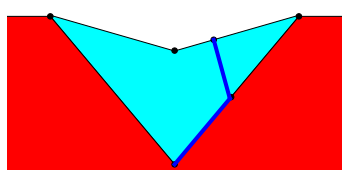

In [68]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-2,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),2,100);
xyw[400:500,0]=np.ones(100)*2; xyw[500:600,0]=np.linspace(2,-2,100); xyw[600:,0]=np.ones(100)*(-2);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);

i=45; j=65;

fig, ax = plt.subplots(figsize=(6,3)  )
plt.rcParams.update({'font.size': fsz})
ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=1, linewidth=1, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=1, linewidth=1, edgecolor='k') )
ax.plot( xb[:i], yb[:i], color=(0,0,1), linewidth=4, zorder=20  );
xp = xps[i]; yp = yps[i]; 
xs = np.linspace( xp, xb[i-1], 10 ); ys = np.linspace( yp, yb[i-1], 10 );
ax.add_patch(patch.Circle((xps[i],yps[i]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[i],yb[i]),0.01, color='k'))
ax.plot( xs, ys, color=(0,0,1), linewidth=4, zorder=20  );


#ax.plot( -xb[:j], yb[:j], color=(0,0,1), linewidth=4, zorder=20  );
#xp = xps[j]; yp = yps[j]; 
#xs = np.linspace( xp, xb[j-1], 10 ); ys = np.linspace( yp, yb[j-1], 10 );
#ax.add_patch(patch.Circle((-xps[j],yps[j]),0.01, color='k'))
#ax.add_patch(patch.Circle((-xb[j],yb[j]),0.01, color='k'))
#ax.plot( -xs, ys, color=(0,0,1), linewidth=4, zorder=20  );

ax.add_patch(patch.Circle((xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
ax.add_patch(patch.Circle((0,yps[xps>0][0]),0.01, color='k'))
ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.02, 0.58)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_axis_off(); ax.margins(0,0);
fig.savefig('./fig_v1/geom2.pdf', bbox_inches='tight')

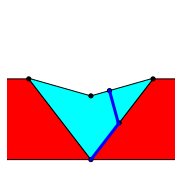

In [26]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xym1 = np.copy(xym);
xywl = np.zeros((400,2));
xywl[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl[200:300,0] = np.linspace(0,-0.5,100); xywl[300:400,0]=np.ones(100)*(-0.5);
xywl[:100,1]=np.ones(100)*np.max(yb); xywl[100:200,1]=np.linspace(np.max(yb),0,100);
xywl[200:300,1] = np.zeros(100); xywl[300:400,1]=np.linspace(0,np.max(yb),100);
xywr = np.copy(xywl); xywr[:,0]=xywr[:,0]*(-1);

fig, ax = plt.subplots(figsize=(3,3)  )
rs=1.; p0=(0.,0); a=1;
ax.set_axis_off(); ax.margins(0,0);
#ax.add_patch(patch.Rectangle( (0.01,0),0.98,0.99 , facecolor=(1,1,1), edgecolor='k', alpha=0.8  ) )
ax.add_patch(patch.Polygon(xywl*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xym*rs+p0, facecolor=(0,1,1), edgecolor='k', alpha=a ) )

i=45;
ax.plot( xb[:i], yb[:i], color=(0,0,1), linewidth=3, zorder=20  );
xp = xps[i]; yp = yps[i]; 
xs = np.linspace( xp, xb[i-1], 10 ); ys = np.linspace( yp, yb[i-1], 10 );
ax.add_patch(patch.Circle((xps[i],yps[i]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[i],yb[i]),0.01, color='k'))
ax.plot( xs, ys, color=(0,0,1), linewidth=3, zorder=20  );
ax.add_patch(patch.Circle((xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
ax.add_patch(patch.Circle((0,yps[xps>0][0]),0.01, color='k'))

ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.05, .75)
#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )
fig.savefig('./fig_v1/geom3a.pdf', bbox_inches='tight')

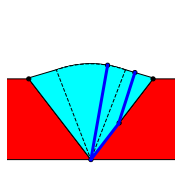

In [35]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
r=0.47;
param = (0.3,r,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );


l1 = len(xps[xps>0]);  l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2+l3 ) * 2,2));
xym[:l2,0] = xr2[xr2<min(xps)]; xym[l2:l2+l1,0] = xps[xps>0]; xym[l2+l1:l2+l1+l3,0] = np.flip(xb);
xym[-l1-l2-l3:-l1-l2,0] = -xb; xym[-l2-l1:-l2,0] = -np.flip(xps[xps>0]); xym[-l2:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l2,1] = yr2[xr2<min(xps)]; xym[l2:l2+l1,1] = yps[xps>0]; xym[l2+l1:l2+l1+l3,1] = np.flip(yb);
xym[-l2:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l2,1] = np.flip(yps[xps>0]); xym[-l2-l1-l3:-l2-l1,1] = yb;
xym2 = np.copy(xym);

fig, ax = plt.subplots(figsize=(3,3)  )
rs=1.; p0=(0.,0); a=1;
ax.set_axis_off(); ax.margins(0,0);
#ax.add_patch(patch.Rectangle( (0.01,0),0.98,0.99 , facecolor='w', edgecolor='k', alpha=0.8  ) )
ax.add_patch(patch.Polygon(xywl*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Wedge( p0, r*rs, np.arctan(4/3)*180/np.pi, 180-np.arctan(4/3)*180/np.pi, facecolor=(0,1,1), edgecolor='k', alpha=1 )  )
ax.add_patch(patch.Polygon(xym*rs+p0, facecolor=(0,1,1), edgecolor='k', alpha=a ) )
ax.add_patch(patch.Wedge( p0, r*rs, np.arctan(8/3)*180/np.pi, 180-np.arctan(8/3)*180/np.pi, facecolor=(0,1,1), edgecolor='k', linestyle='--', alpha=1 )  )

i=45;
ax.plot( xb[:i], yb[:i], color=(0,0,1), linewidth=3, zorder=20  );
xp = xps[i]; yp = yps[i]; 
xs = np.linspace( xp, xb[i-1], 10 ); ys = np.linspace( yp, yb[i-1], 10 );
ax.add_patch(patch.Circle((xps[i],yps[i]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[i],yb[i]),0.01, color='k'))
ax.plot( xs, ys, color=(0,0,1), linewidth=3, zorder=20  );
ax.add_patch(patch.Circle((xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
ax.add_patch(patch.Circle((r*np.cos(1.4),r*np.sin(1.4)),0.01, color='k'))
xs = np.linspace( 0, r*np.cos(1.4), 10 ); ys = np.linspace( 0, r*np.sin(1.4), 10 );
ax.plot( xs, ys, color=(0,0,1), linewidth=3, zorder=20  );


ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.05, .75)
#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )
fig.savefig('./fig_v1/geom3b.pdf', bbox_inches='tight')

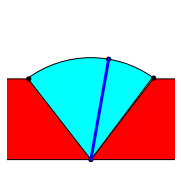

In [52]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
r=0.5;
param = (0.3,0.5,0.4);
param2 = ((0.5**2-0.4**2)**0.5,0.5,0.4);

xps, yps = xyp(1, np.arange(100)/100, param2 )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param2[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

fig, ax = plt.subplots(figsize=(3,3)  )
rs=1; p0=(0.,0); a=1;
ax.set_axis_off(); ax.margins(0,0);
#ax.add_patch(patch.Rectangle( (0.01,0),0.98,0.99 , facecolor='w', edgecolor='k', alpha=0.8  ) )
ax.add_patch(patch.Polygon(xywl*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, facecolor=(1.0,0.,0.), edgecolor='k', alpha=a) )
ax.add_patch(patch.Wedge( p0, 0.5*rs, np.arctan(5/4)*180/np.pi+2.5, 180-np.arctan(5/4)*180/np.pi-1.5, facecolor=(0,1,1), edgecolor='k', alpha=1 )  )

i=45;
ax.add_patch(patch.Circle((0.3,0.4),0.01, color='k'))
ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
ax.add_patch(patch.Circle((r*np.cos(1.4),r*np.sin(1.4)),0.01, color='k'))
xs = np.linspace( 0, r*np.cos(1.4), 10 ); ys = np.linspace( 0, r*np.sin(1.4), 10 );
ax.plot( xs, ys, color=(0,0,1), linewidth=3, zorder=20  );

ax.set_xlim(-0.4,0.4)
ax.set_ylim(-0.05, .75)
#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )
fig.savefig('./fig_v1/geom3c.pdf', bbox_inches='tight')

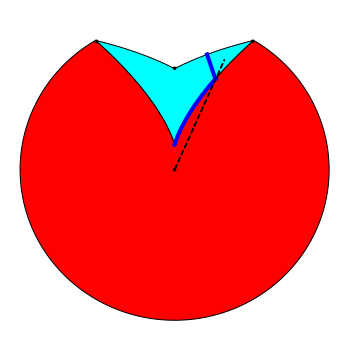

In [63]:
def xyp(t,t2, param):
    u, v1, v2, r0 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = (v2*t2+r0)*np.sin( u/v2*np.log(1+v2*t2/r0) )+v1*(t-t2)*np.sin( u/v2*np.log(1+v2*t2/r0) - theta );
    yp = (v2*t2+r0)*np.cos( u/v2*np.log(1+v2*t2/r0) )+v1*(t-t2)*np.cos( u/v2*np.log(1+v2*t2/r0) - theta );
    return (xp,yp)
param = (0.3,0.5,1,0.2);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = (param[2]+param[3])*np.cos( np.arange(100)/100*np.pi/2 );
yr = (param[2]+param[3])*np.sin( np.arange(100)/100*np.pi/2 );
xr2 = (param[3])*np.cos( np.arange(100)/100*np.pi );
yr2 = (param[3])*np.sin( np.arange(100)/100*np.pi );
rb = param[3]+np.arange(100)/100; tb = param[0]/param[2]*np.log( rb/param[3] );
xb = rb*np.sin(tb); yb=rb*np.cos(tb);
fig, ax = plt.subplots(figsize = (6,6) )
ax.set_xticks([]); ax.set_yticks([]);

lm = len( xps[xps>0] );
xym = np.zeros((2*lm+200,2));
xym[:lm,0] = xps[xps>0]; xym[:lm,1] = yps[xps>0];
xym[lm:lm+100,0] = np.flip(xb); xym[lm:lm+100,1]=np.flip(yb);
xym[lm+100:lm+200,0] = -xb; xym[lm+100:lm+200,1]=yb;
xym[lm+200:,0]= -np.flip(xps[xps>0]); xym[lm+200:,1] = np.flip(yps[xps>0]);

lw = len(xr[xr>max(xb)])
xyw = np.zeros((400+2*lw,2));
xyw[:lw,0] = xr[xr>max(xb)]; xyw[:lw,1] = yr[xr>max(xb)]; 
xyw[lw:lw+100,0] = np.flip(xb); xyw[lw:lw+100,1] = np.flip(yb);
xyw[lw+100:lw+200,0] = -xb; xyw[lw+100:lw+200,1] = yb;
xyw[lw+200:2*lw+200,0] = -np.flip(xr[xr>max(xb)]); xyw[lw+200:2*lw+200,1] = np.flip(yr[xr>max(xb)]); 
xyw[lw*2+200:lw*2+300,0] = -xr; xyw[lw*2+200:lw*2+300,1]=-yr;
xyw[lw*2+300:lw*2+400,0] = np.flip(xr); xyw[lw*2+300:lw*2+400,1]=-np.flip(yr);

ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=1, linewidth=1, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=1, linewidth=1, edgecolor='k') )


t = 60
xp = xps[t]; yp = yps[t]; 
ax.plot( xb[:t], yb[:t], color=(0,0,1), linewidth=4, zorder=20  );
xs = np.linspace( xp, xb[t-1], 10 ); ys = np.linspace( yp, yb[t-1], 10 );
ax.plot( xs, ys, color=(0,0,1), linewidth=4, zorder=20  );
ax.plot( np.linspace(0, xb[t]*1.2, 10) , np.linspace(0, yb[t], 10)*1.2, linestyle='--', color='k', zorder=20);

ax.set_xlim(-1.3,1.3)
ax.set_ylim(-1.3,1.3)

ax.add_patch(patch.Circle((xps[t],yps[t]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[t],yb[t]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
ax.add_patch(patch.Circle((0,yb[0]),0.01, color='k'))
ax.add_patch(patch.Circle((0,yps[xps>0][0]),0.01, color='k'))


#ax.text(-0.02,0.1,'$I$', fontsize=18); ax.scatter(0, param[3]+0.01, color=(0,0.5,0) );
#ax.text(xp-0.03, yp+0.05,'$P$', fontsize=18); ax.scatter(xp, yp+0.01, color=(0,0.5,0) );
#ax.text(xb[t-1], yb[t-1]-0.09,'$P\'$', fontsize=18); ax.scatter(xb[t-1], yb[t-1]+0.01, color=(0,0.5,0) );
#ax.text(xb[-1], yb[-1]+0.03,'$B$', fontsize=18); ax.scatter(xb[-1], yb[-1]+0.01, color='r');
#ax.text(-0.03,-0.08,'$O$', fontsize=18); 
#ax.text(0.001, 0.1, r'$\phi_{P\'}$', fontsize=14);
#ax.text(xb[t-1]-0.015, yb[t-1]+0.065, r'$\theta$', fontsize=14);


ax.plot( np.linspace(0, xb[t]*1.2, 10) , np.linspace(0, yb[t], 10)*1.2, linestyle='--', color='k');
ax.set_axis_off(); ax.margins(0,0);


fig.savefig('./fig_v1/geom4a.pdf', bbox_inches='tight')

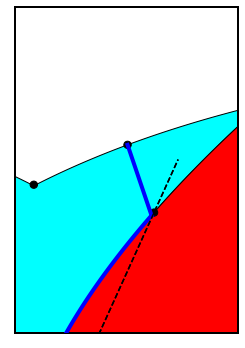

In [62]:
def xyp(t,t2, param):
    u, v1, v2, r0 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = (v2*t2+r0)*np.sin( u/v2*np.log(1+v2*t2/r0) )+v1*(t-t2)*np.sin( u/v2*np.log(1+v2*t2/r0) - theta );
    yp = (v2*t2+r0)*np.cos( u/v2*np.log(1+v2*t2/r0) )+v1*(t-t2)*np.cos( u/v2*np.log(1+v2*t2/r0) - theta );
    return (xp,yp)
param = (0.3,0.5,1,0.2);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = (param[2]+param[3])*np.cos( np.arange(100)/100*np.pi/2 );
yr = (param[2]+param[3])*np.sin( np.arange(100)/100*np.pi/2 );
xr2 = (param[3])*np.cos( np.arange(100)/100*np.pi );
yr2 = (param[3])*np.sin( np.arange(100)/100*np.pi );
rb = param[3]+np.arange(100)/100; tb = param[0]/param[2]*np.log( rb/param[3] );
xb = rb*np.sin(tb); yb=rb*np.cos(tb);
fig, ax = plt.subplots(figsize = (4,6) )
ax.set_xticks([]); ax.set_yticks([]);

lm = len( xps[xps>0] );
xym = np.zeros((2*lm+200,2));
xym[:lm,0] = xps[xps>0]; xym[:lm,1] = yps[xps>0];
xym[lm:lm+100,0] = np.flip(xb); xym[lm:lm+100,1]=np.flip(yb);
xym[lm+100:lm+200,0] = -xb; xym[lm+100:lm+200,1]=yb;
xym[lm+200:,0]= -np.flip(xps[xps>0]); xym[lm+200:,1] = np.flip(yps[xps>0]);

lw = len(xr[xr>max(xb)])
xyw = np.zeros((400+2*lw,2));
xyw[:lw,0] = xr[xr>max(xb)]; xyw[:lw,1] = yr[xr>max(xb)]; 
xyw[lw:lw+100,0] = np.flip(xb); xyw[lw:lw+100,1] = np.flip(yb);
xyw[lw+100:lw+200,0] = -xb; xyw[lw+100:lw+200,1] = yb;
xyw[lw+200:2*lw+200,0] = -np.flip(xr[xr>max(xb)]); xyw[lw+200:2*lw+200,1] = np.flip(yr[xr>max(xb)]); 
xyw[lw*2+200:lw*2+300,0] = -xr; xyw[lw*2+200:lw*2+300,1]=-yr;
xyw[lw*2+300:lw*2+400,0] = np.flip(xr); xyw[lw*2+300:lw*2+400,1]=-np.flip(yr);

ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=1, linewidth=1, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=1, linewidth=1, edgecolor='k') )


t = 60
xp = xps[t]; yp = yps[t]; 
ax.plot( xb[:t], yb[:t], color=(0,0,1), linewidth=4, zorder=20  );
xs = np.linspace( xp, xb[t-1], 10 ); ys = np.linspace( yp, yb[t-1], 10 );
ax.plot( xs, ys, color=(0,0,1), linewidth=4, zorder=20  );
ax.plot( np.linspace(0, xb[t]*1.2, 10) , np.linspace(0, yb[t], 10)*1.2, linestyle='--', color='k', zorder=20);

ax.set_xlim(-0.05,0.55)
ax.set_ylim(0.4,1.3)

ax.add_patch(patch.Circle((xps[t],yps[t]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[t],yb[t]),0.01, color='k'))
ax.add_patch(patch.Circle((xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((-xb[-1],yb[-1]),0.01, color='k'))
ax.add_patch(patch.Circle((0,0),0.01, color='k'))
ax.add_patch(patch.Circle((0,yb[0]),0.01, color='k'))
ax.add_patch(patch.Circle((0,yps[xps>0][0]),0.01, color='k'))


#ax.text(-0.02,0.1,'$I$', fontsize=18); ax.scatter(0, param[3]+0.01, color=(0,0.5,0) );
#ax.text(xp-0.03, yp+0.05,'$P$', fontsize=18); ax.scatter(xp, yp+0.01, color=(0,0.5,0) );
#ax.text(xb[t-1], yb[t-1]-0.09,'$P\'$', fontsize=18); ax.scatter(xb[t-1], yb[t-1]+0.01, color=(0,0.5,0) );
#ax.text(xb[-1], yb[-1]+0.03,'$B$', fontsize=18); ax.scatter(xb[-1], yb[-1]+0.01, color='r');
#ax.text(-0.03,-0.08,'$O$', fontsize=18); 
#ax.text(0.001, 0.1, r'$\phi_{P\'}$', fontsize=14);
#ax.text(xb[t-1]-0.015, yb[t-1]+0.065, r'$\theta$', fontsize=14);


ax.plot( np.linspace(0, xb[t]*1.2, 10) , np.linspace(0, yb[t], 10)*1.2, linestyle='--', color='k');


fig.savefig('./fig_v1/geom4b.pdf', bbox_inches='tight')

# 0127 Supps

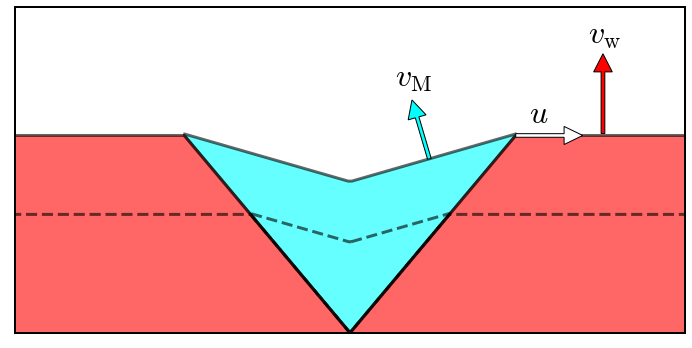

In [314]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-10,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),10,100);
xyw[400:500,0]=np.ones(100)*10; xyw[500:600,0]=np.linspace(10,-10,100); xyw[600:,0]=np.ones(100)*(-10);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);



fig, ax = plt.subplots(figsize=(3*4,1.5*4)  )
plt.rcParams.update({'font.size': fsz*4})
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xym, facecolor=(0,1,1), alpha=0.6, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.6, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xym*0.6, facecolor='none', alpha=0.6, linewidth=3, linestyle='--', edgecolor='k') )
ax.add_patch(patch.Polygon(xyw*0.6, facecolor='none', alpha=0.6, linewidth=3, linestyle='--', edgecolor='k') )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Wedge( (0,0), 0.55, np.arcsin(4/5.5)*180/np.pi, 180-np.arcsin(4/5.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
#ax.add_patch(patch.FancyArrow( -0.45,0,0,0.55, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.58, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
#ax.text(-0.17, -0.1, 'Wildtype', color=(1,1,1))
#ax.text(-0.13, 0.3, 'Mutant')
#ax.plot( np.linspace(-np.max(xb), np.max(xb), 100), np.max(yb)+0*np.linspace(-1, 1, 100), 'k--', linewidth=1);

#ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
#ax.text(0.23,0.03,' Mutant emerges\n at t=0', color=(1,1,1))

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))

#ax.add_patch(patch.FancyArrow( -0.68,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( 0.68,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))

#ax.add_patch(patch.FancyArrow( xym[320,0],xym[320,1],-0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,0.5,1.0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( -xym[320,0],xym[320,1],0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1,1.0) ,alpha=1  ))

#ax.add_patch(patch.FancyArrow( -xb[-1],yb[-1],-0.18,0, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( xb[-1],yb[-1],0.18,0, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1.,1.,1.) ,alpha=1  ))


#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.72, 0.8, r'$v_{\rm w} $', color=(0,0,0))
#ax.text(-0.19, 0.68, r'$v_{\rm M} $', color=(0,0,0))
ax.text(0.64, 0.8, r'$v_{\rm w} $', color=(0,0,0))
ax.text(0.12, 0.68, r'$v_{\rm M} $', color=(0,0,0))
#ax.text(-0.54, 0.58, r'$u$', color=(0,0,0))
ax.text(0.48, 0.58, r'$u$', color=(0,0,0))
#ax.text(0.12, 0.68, r'$v_{\rm M} $', color=(0,0,0))

#ax.text(-0.57, 0.2, r'$L_{\rm W} \propto v_{\rm w}t $', color=(0,0,0))
#ax.text(-0.17, 0.35, r'$L_{\rm M} \propto v_{\rm M}t $', color=(0,0,0))

#ax.text(-0.17, 0.25, r'$time=0$', color=(0,0,0))
#ax.text(0.44, 0.8, r'$v_{\rm w}t $', color=(0,0,0))
#ax.text(0.12, 0.68, r'$v_{\rm M}t $', color=(0,0,0))

#t = 55
#xp = xps[t]; yp = yps[t]; 
#ax.scatter(xp,yp,color='k')
#ax.scatter(xb[t],yb[t],color='k')
#ax.plot( xb[:t], yb[:t], color=(0.,1.,0) , linewidth=5);
#xs = np.linspace( xp, xb[t-1], 10 ); ys = np.linspace( yp, yb[t-1], 10 );
#ax.plot( xs, ys, color=(0.,1.,0) , linewidth=5);

#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.9,0.9)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('1201_fig2b_alt2.png', bbox_inches='tight')

In [248]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
timages = np.zeros((10,3,1024,1024,3))
ts = np.zeros(10);
for i in np.arange(10):
    t = 0;
    if(i<8):
        for j in np.arange(2):
            dm = dir0+'1015/COMP01/WM11_2_'+str(i+1)+'.tif';
            dw = dir0+'1015/COMP01/WM11_1_'+str(i+1)+'.tif';
            w = Colony([dw]); t+= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    elif(i<9):
         for j in np.arange(2):
            dm = dir0+'1016/COMP01/WM11_2_1.tif';
            dw = dir0+'1016/COMP01/WM11_1_1.tif';
            w = Colony([dw]); t+= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    else:
         for j in np.arange(2):
            dm = dir0+'1017/COMP01/WM11_2_1.tif';
            dw = dir0+'1017/COMP01/WM11_1_1.tif';
            w = Colony([dw]); t+= os.path.getmtime(dw); timages[i,0,:,:,0] = w.Image;
            m = Colony([dm]); timages[i,1,:,:,1] = m.Image; timages[i,1,:,:,2] = m.Image;
            wm = Colony([dw,dm]); timages[i,2]=wm.Image;
    ts[i] = t/4/86400;

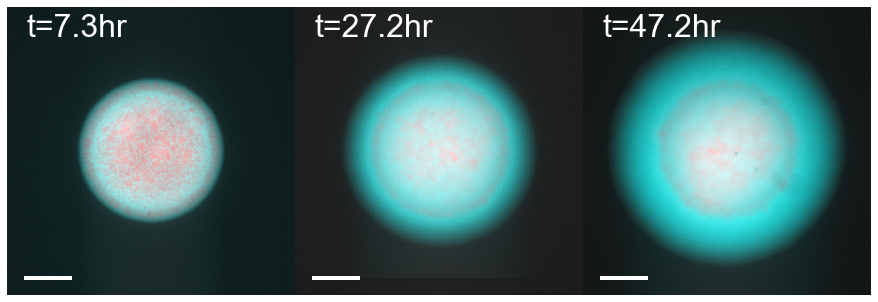

In [292]:
fig, ax = plt.subplots(1,3, figsize=(1*12, 1*4));
#plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 130;


#img = np.zeros((1024,1024,3));
#for i in np.arange(3):
#    img[:,:,i] = comp0.Image[:,:,i]*filt
inds = [5,8,9];
for i in np.arange(3):
    ax[i].set_xlim(margin,1024-margin); ax[i].set_ylim(1024-margin,margin);
    ax[i].set_xticks([]); ax[i].set_yticks([]);
    ax[i].imshow(timages[inds[i],2])
    ax[i].set_axis_off()
    ax[i].plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=4 )
    ax[i].margins(0,0)
    ax[i].text( 50+margin, 80+margin, 't='+str(48*ts[inds[i]]-48*ts[0])[:3+inds[i]//7]+'hr', color=(1,1,1) )
#ax.add_patch( patch.Circle( (512,512), radius=m01.R, facecolor='none',edgecolor=(1,1,1),alpha=1 ));
#ax.add_patch( patch.Circle( (512,512), radius=m0.R, facecolor='none',edgecolor=(1,1,1), lw=4, alpha=1 ));



#ax.add_patch( patch.Circle( (512,512), radius=m01.R, facecolor=(0,0.5,1.),edgecolor=(0,0.5,1.0), alpha=0.5 ) );
#ax.text(412,100,'Mixed', color=(1,1,1));
#ax.plot( np.arange(512), np.ones(512)*(512-m01.R), color=(1,1,1), linestyle='--' )
#ax.plot( np.arange(512), np.ones(512)*(512+m01.R), color=(1,1,1), linestyle='--' )

#fig.savefig('1201_supp1c_newc.png', bbox_inches='tight')#,bbox_inches='tight')


# 1201 Revisit

## Fig. 1

In [14]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
rms = np.zeros((2, 6));
rws = np.zeros((2, 6));
ts = np.zeros(6);
for i in np.arange(6):
    t = 0;
    if(i<4):
        for j in np.arange(2):
            dm = dir0+'1015/MONO'+str(j+1)+'/M1_01_'+str(i*2+1)+'.tif';
            dw = dir0+'1015/MONO'+str(j+1)+'/W1_01_'+str(i*2+1)+'.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);  
    elif(i==4):
         for j in np.arange(2):
            dm = dir0+'1016/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1016/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    elif(i==5):
         for j in np.arange(2):
            dm = dir0+'1017/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1017/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    ts[i] = t/4/86400;

In [15]:
xs = ((ts-ts[0])*24)[1:]; print(xs)
ys1 = np.mean(rws*mpx, axis=0)[1:];
es1 = np.std(rws*mpx, axis=0)[1:];
ys2 = np.mean(rms*mpx, axis=0)[1:];
es2 = np.std(rms*mpx, axis=0)[1:];
sol1 = curve_fit(linf, xdata=xs, ydata=ys1, sigma=es1)
sol2 = curve_fit(linf, xdata=xs, ydata=ys2, sigma=es2)
yf1 = xs*sol1[0][0]+sol1[0][1];
yf2 = xs*sol2[0][0]+sol2[0][1];

[ 3.85291667  6.34930556  8.71347222 27.25472222 47.24180556]


In [16]:
ys = (rws[0]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rws[1]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rms[0]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rms[1]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )

0.03391664733751731
0.0340953786268415
0.022492829541889112
0.0222423045526467


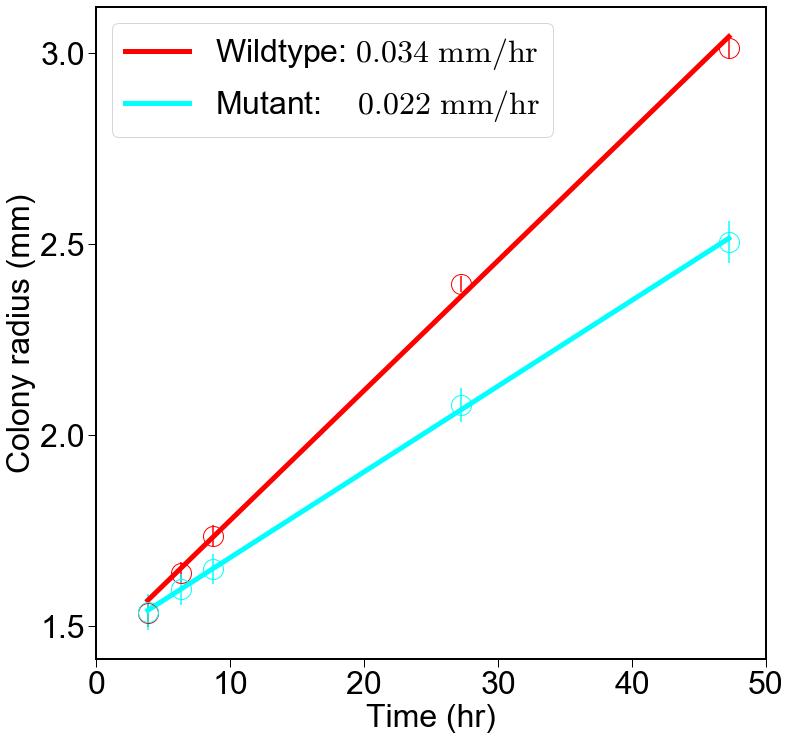

In [17]:
fig, ax = plt.subplots(figsize=(3*4,3*4))
plt.setp(ax.get_yticklabels(), Fontsize=fsz*4);
plt.setp(ax.get_xticklabels(), Fontsize=fsz*4);

ax.errorbar(xs, ys1, yerr=es1*2, linestyle='none', marker='o', mfc='none', markersize=20, color=(1,0,0));
ax.errorbar(xs, ys2, yerr=es2*2, linestyle='none', marker='o', mfc='none', markersize=20, color=(0,1,1));
ax.plot(xs, yf1, color=(1,0,0), linewidth=5);
ax.plot(xs, yf2, color=(0,1,1), linewidth=5);
ax.set_xlim( 0,50 )
ax.set_xlabel('Time (hr)',fontsize=fsz*4)
ax.set_yticks([1.5,2.,2.5,3])
ax.set_ylabel('Colony radius (mm)',fontsize=fsz*4)
ax.legend(['Wildtype: '+r'$0.034\ {\rm mm/hr}$','Mutant:    '+r'$0.022\ {\rm mm/hr}$'], fontsize=fsz*4)

fig.savefig('210223_1b.png', bbox_inches='tight')

In [13]:
dest1 = dir0+'1015/COMP01/WM991_1_3.tif';
dest2 = dir0+'1015/COMP01/WM991_2_3.tif';
comp0 = Colony([dest1,dest2]);
dest1 = dir0+'1017/COMP01/WM991_1_1.tif';
dest2 = dir0+'1017/COMP01/WM991_2_1.tif';
comp01 = Colony([dest1,dest2]);
dest = dir0+'1015/MONO2/M1_01_3.tif';
m0 = Colony([dest]); m0.color(1); 
dest = dir0+'1015/MONO2/W1_01_3.tif';
w0 = Colony([dest]); w0.color(0);
dest = dir0+'1017/MONO2/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO2/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

In [395]:
filt = np.zeros((1024,1024));
for i in np.arange(1024):
    for j in np.arange(1024):
        filt[i,j] = ( (i-512)**2 + (j-512)**2 )<m0.R**2

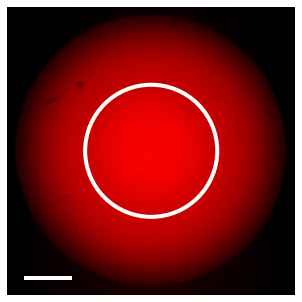

In [396]:
fig, ax = plt.subplots(1,1, figsize=(1*4, 1*4));
#plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 130;

ax.set_xlim(margin,1024-margin); ax.set_ylim(1024-margin,margin);
ax.set_xticks([]); ax.set_yticks([]);
#img = np.zeros((1024,1024,3));
#for i in np.arange(3):
#    img[:,:,i] = comp0.Image[:,:,i]*filt
#ax.imshow(img)
ax.imshow(w01.Image)
#ax.add_patch( patch.Circle( (512,512), radius=m01.R, facecolor='none',edgecolor=(1,1,1),alpha=1 ));
ax.add_patch( patch.Circle( (512,512), radius=w0.R, facecolor='none',edgecolor=(1,1,1), lw=4, alpha=1 ));



#ax.add_patch( patch.Circle( (512,512), radius=m01.R, facecolor=(0,0.5,1.),edgecolor=(0,0.5,1.0), alpha=0.5 ) );
#ax.text(412,100,'Mixed', color=(1,1,1));
#ax.plot( np.arange(512), np.ones(512)*(512-m01.R), color=(1,1,1), linestyle='--' )
#ax.plot( np.arange(512), np.ones(512)*(512+m01.R), color=(1,1,1), linestyle='--' )
ax.set_axis_off()
ax.plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=4 )
#ax.text( 90, 910, '2mm', color=(1,1,1) )
#ax.text( 130, 910, '2mm', color=(1,1,1) )
ax.margins(0,0)
fig.savefig('1201_1a2.png', bbox_inches='tight')#,bbox_inches='tight')

#plt.gca().set_axis_off()
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)

#plt.savefig("myfig.pdf")

In [187]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91','WM11','WM19','WM199'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

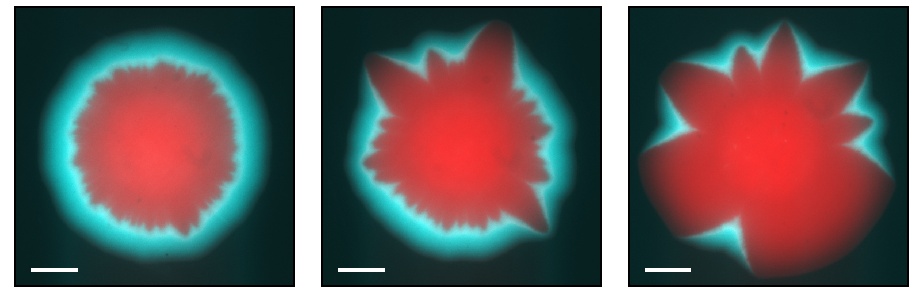

In [197]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'wspace':0.1,'hspace':0.1}, figsize=(4*4,4*4) );
for j in np.arange(3):
    ax[j].imshow(comps[j,0]);
    ax[j].set_xlim(margin,1024-margin); ax[j].set_ylim(1024-margin,margin);
    ax[j].set_xticks([]);
    ax[j].set_yticks([]);
    ax[j].plot( np.linspace(0, 1/mpx, 10)+50+margin, np.ones(10)*980-margin, color=(1,1,1), linewidth=4 )
fig.savefig('1201_1c_newc.png', bbox_inches='tight')

In [189]:
dest1 = dir0+'1017/COMP0001/WM991_1_1.tif';
dest2 = dir0+'1017/COMP0001/WM991_2_1.tif';
comp = Colony([dest1,dest2]);

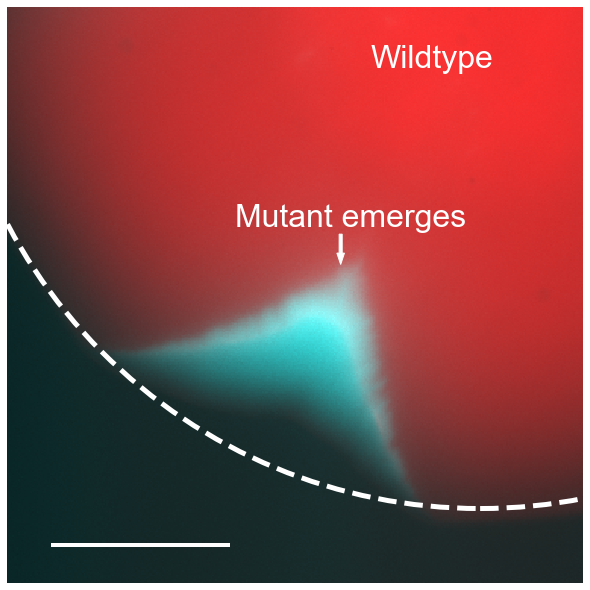

In [198]:
fig, ax = plt.subplots(1,1, figsize=(2*4, 2*4));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#for i in np.arange(3):
ax.set_xticks([]); ax.set_yticks([]);
#ax.plot( np.arange(512)+512, np.ones(512)*(512-w01.R), color=(1,1,1), linestyle='--' )
#ax.plot( np.arange(512)+512, np.ones(512)*(512+w01.R), color=(1,1,1), linestyle='--' )
ax.set_axis_off()
img = np.copy(np.flip(comp.Image, axis=0));
#target = np.flip( (comp.Edge>np.max(comp.Edge)*0.155)*(comp.ImageBW<np.max(comp.ImageBW)*0.155), axis=0);
#target = np.flip( (comp.ImageBW>np.max(comp.ImageBW)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.16), axis=0);
#for i in np.arange(3):
#    img[:,:,i] = img[:,:,i]*(1-target) + target*1
#img[:,:,1] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
#img[:,:,0] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
#img[:,:,2] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
ax.imshow( img )
ax.add_patch(patch.Circle( (512,512), 353, facecolor='none', edgecolor=(1,1,1),linestyle='--', linewidth=5 ))
#ax.add_patch(patch.Circle( (420,316), 5, facecolor=(1,1,1)))
ax.add_patch(patch.FancyArrow( 420,340,0,-20, width=2, length_includes_head=True, head_width=5, color=(1,1,1), alpha=1  ))
#ax.imshow(np.flip(comp.Edge*(comp.ImageBW<0.1), axis=0))
#ax.add_patch(patch.FancyArrow( 386,226,-20,-40, width=3, length_includes_head=True, head_width=8, color=(1,1,1), alpha=1  ))
#ax.add_patch(patch.FancyArrow( 386-20,226-40,20,40, width=3, length_includes_head=True, head_width=8, color=(1,1,1), alpha=1  ))
#ax.text(260,170,'Expands slower,', color=(1,1,1))
#ax.text(260,155,'yet takes over the front', color=(1,1,1))
s = 380;
ax.set_xlim(200,200+s); ax.set_ylim(110,110+s);
ax.plot( np.linspace(0, 1/mpx, 10)+ 230, np.ones(10)*135, color=(1,1,1), linewidth=4 )
#ax.text( 228, 145, r'$500\mu m$', color=(1,1,1) )
ax.text(350, 345, 'Mutant emerges', color=(1,1,1))
ax.text(440, 450, 'Wildtype', color=(1,1,1))
fig.savefig('1201_1d_newc.png', bbox_inches='tight')

## Fig. 2

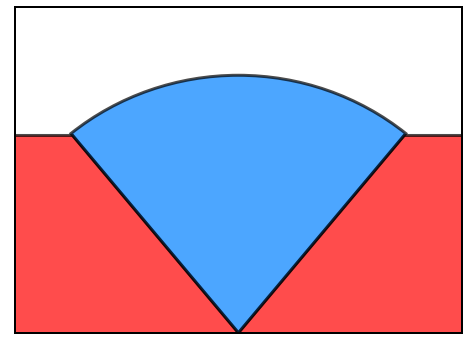

In [211]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(2*4,1.5*4)  )
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
#ax.add_patch(patch.Polygon(xym, facecolor=(0,0.5,1), alpha=1, edgecolor='none') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.7, linewidth=3, edgecolor='k') )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
ax.add_patch(patch.Wedge( (0,0), (0.45**2+0.55**2)**0.5, np.arctan(5.5/4.5)*180/np.pi, 180-np.arctan(5.5/4.5)*180/np.pi, facecolor=(0,0.5,1), alpha=0.7, linewidth=3, edgecolor='k'  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
#ax.add_patch(patch.FancyArrow( -0.45,0,0,0.55, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.58, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
#ax.text(-0.47, 0.1, 'Wildtype', color=(1,1,1))
#ax.text(-0.13, 0.3, 'Mutant')

#ax.plot( np.linspace(-1, 1, 100), 0*np.linspace(-1, 1, 100), 'w--', linewidth=3);
#ax.plot( np.linspace(-np.max(xb), np.max(xb), 100), np.max(yb)+0*np.linspace(-1, 1, 100), 'k--', linewidth=1);


#ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
#ax.text(0.23,0.05,' Mutant\n emerges', color=(1,1,1))

#ax.text(-0.34,0.05,r'$t=0$', color='k')

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);

#fig.savefig('1201_fig2b1.png', bbox_inches='tight')

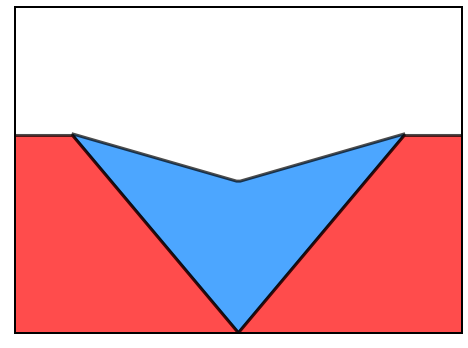

In [212]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(2*4,1.5*4)  )
plt.rcParams.update({'font.size': fsz*4})
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xym, facecolor=(0,0.5,1), alpha=0.7, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.7, linewidth=3, edgecolor='k') )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Wedge( (0,0), 0.55, np.arcsin(4/5.5)*180/np.pi, 180-np.arcsin(4/5.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
#ax.add_patch(patch.FancyArrow( -0.45,0,0,0.55, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.58, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
#ax.text(-0.17, -0.1, 'Wildtype', color=(1,1,1))
#ax.text(-0.13, 0.3, 'Mutant')
#ax.plot( np.linspace(-np.max(xb), np.max(xb), 100), np.max(yb)+0*np.linspace(-1, 1, 100), 'k--', linewidth=1);

#ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
#ax.text(0.23,0.03,' Mutant emerges\n at t=0', color=(1,1,1))

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('1201_fig2b2.png', bbox_inches='tight')

In [315]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xym1 = np.copy(xym);
xywl = np.zeros((400,2));
xywl[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl[200:300,0] = np.linspace(0,-0.5,100); xywl[300:400,0]=np.ones(100)*(-0.5);
xywl[:100,1]=np.ones(100)*np.max(yb); xywl[100:200,1]=np.linspace(np.max(yb),0,100);
xywl[200:300,1] = np.zeros(100); xywl[300:400,1]=np.linspace(0,np.max(yb),100);
xywr = np.copy(xywl); xywr[:,0]=xywr[:,0]*(-1);

In [316]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.43,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );


l1 = len(xps[xps>0]);  l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2+l3 ) * 2,2));
xym[:l2,0] = xr2[xr2<min(xps)]; xym[l2:l2+l1,0] = xps[xps>0]; xym[l2+l1:l2+l1+l3,0] = np.flip(xb);
xym[-l1-l2-l3:-l1-l2,0] = -xb; xym[-l2-l1:-l2,0] = -np.flip(xps[xps>0]); xym[-l2:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l2,1] = yr2[xr2<min(xps)]; xym[l2:l2+l1,1] = yps[xps>0]; xym[l2+l1:l2+l1+l3,1] = np.flip(yb);
xym[-l2:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l2,1] = np.flip(yps[xps>0]); xym[-l2-l1-l3:-l2-l1,1] = yb;
xym2 = np.copy(xym);

In [317]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.55,0.4);
param2 = ((0.55**2-0.4**2)**0.5,0.55,0.4);

xps, yps = xyp(1, np.arange(100)/100, param2 )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param2[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

l1 = len(xr2[xr2<min(xps)]);   l2=100; #l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2 ) * 2,2));
xym[:l1,0] = xr2[xr2<min(xps)]; xym[l1:l2+l1,0] = np.flip(xb);
xym[-l1-l2:-l1,0] = -xb; xym[-l1:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l1,1] = yr2[xr2<min(xps)]; xym[l1:l2+l1,1] = np.flip(yb);
xym[-l1:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l1,1] = yb;
xym3a = np.copy(xym);
l=100;
xym = np.zeros(((l+l ) * 2,2));
xym[:l,0] = np.linspace(0,max(xb),l); xym[l:l*2,0] = np.linspace(max(xb),0,l);
xym[2*l:3*l,0] = -np.linspace(0,max(xb),l); xym[-l:,0] = -np.linspace(max(xb),0,l);
xym[:l,1] = np.linspace(max(yr2),max(yb),l); xym[l:l*2,1] = np.linspace(max(yb),max(yb),l)+0.006;
xym[2*l:3*l,1] = np.linspace(max(yb),max(yb),l)+0.006; xym[-l:,1] = np.linspace(max(yb),max(yr2),l);
xym3b = np.copy(xym);
xywl3 = np.zeros((400,2));
xywl3[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl3[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl3[200:300,0] = np.linspace(0,-0.5,100); xywl3[300:400,0]=np.ones(100)*(-0.5);
xywl3[:100,1]=np.ones(100)*np.max(yb); xywl3[100:200,1]=np.linspace(np.max(yb),0,100);
xywl3[200:300,1] = np.zeros(100); xywl3[300:400,1]=np.linspace(0,np.max(yb),100);
xywr3 = np.copy(xywl3); xywr3[:,0]=xywr3[:,0]*(-1);
xywl4 = np.zeros((400,2));
xywl4[:100,0]=np.linspace(-2.5,-np.max(xb),100); xywl4[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl4[200:300,0] = np.linspace(0,-2.5,100); xywl4[300:400,0]=np.ones(100)*(-2.5);
xywl4[:100,1]=np.ones(100)*np.max(yb); xywl4[100:200,1]=np.linspace(np.max(yb),0,100);
xywl4[200:300,1] = np.zeros(100); xywl4[300:400,1]=np.linspace(0,np.max(yb),100);
xywr4 = np.copy(xywl4); xywr4[:,0]=xywr4[:,0]*(-1);


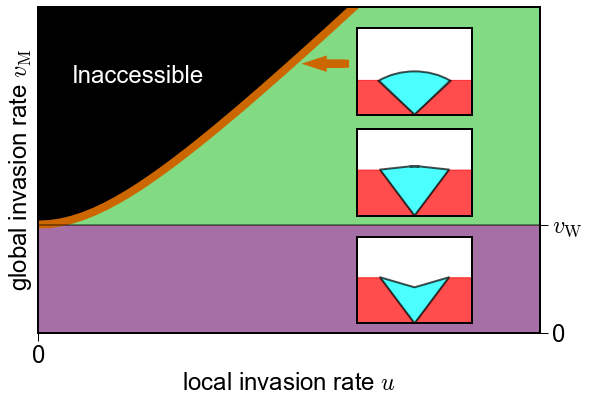

In [355]:
fig, ax = plt.subplots(figsize = (9,6) )
ax.set_xticks([0]); ax.set_yticks([0,1]); ax.set_yticklabels([0,r'$v_{\rm W}$']); 
ax.yaxis.tick_right();
#ax.xaxis.tick_top();
plt.setp(ax.get_yticklabels(), Fontsize=fsz*3);
plt.setp(ax.get_xticklabels(), Fontsize=fsz*3);
plt.rcParams.update({'font.size': fsz*2})
xs = np.linspace(0,10,100);
ys1 = np.sqrt(1 + xs**2);
xyf = np.zeros((300,2));
xyf[:100,0]=xs; xyf[:100,1]=ys1;
xyf[100:200,0]=np.flip(xs); xyf[100:200,1]=np.ones(100)*ys1[-1];
xyf[200:,0]=0; xyf[200:,1]=np.flip(ys1);

xy2 = np.zeros((300,2));
xy2[:100,0]=xs; xy2[:100,1]=ys1;
xy2[100:200,0]=np.ones(100)*xs[-1]; xy2[100:200,1]=np.flip(ys1);
xy2[200:,0]=np.flip(xs); xy2[200:,1]=np.ones(100)*1;

ax.add_patch(patch.Polygon(xyf, color=(.0,0.,0.), alpha=1) )
ax.add_patch(patch.Polygon(xy2, color=(0.3,0.8,0.3), alpha=0.7) )
ax.add_patch(patch.Rectangle( (0,0),10,1 , color=(0.5,0.2,0.5), alpha=0.7) )
ax.add_patch(patch.Rectangle( (-0.5,0),0.5,10 , fill=False,hatch='x') )
ax.plot(xs, ys1, color=(.8,0.4,0), alpha=1, linewidth=8)
ax.plot(xs, xs*0+1, color='k', alpha=0.5)
ax.set_xlim(0.,4.5)
ax.set_ylim(0,3.)
ax.set_xlabel('local invasion rate '+r'$u$', fontsize=fsz*3)
ax.set_ylabel('global invasion rate '+r'$v_{\rm M}$', fontsize=fsz*3)
#ax.text(1.1,0.5, 'Dented')
#ax.text(0.5,1.9, 'Bulged')
#ax.text(1.9,1.3, 'Mixed')
#ax.text(1.17,0.8,r'$v_2 < v_1$')
#ax.text(1.8,1.9,r'$ v_1 < v_2 < \sqrt{v_1^2+u^2}$')
#ax.text(0.3,2.3,r'$ v_2 > \sqrt{v_1^2+u^2}$')
#ax.text(2.3,1.5,'Bulged front')
#ax.text(2.25,0.5,'Dented front')
ax.text(0.3,2.3,'Inaccessible', color=(1,1,1), fontsize=fsz*3)
#ax.text(2.9,2.45,'Expansion-limit',color=(1,0,0) )
#ax.text(2.55,2.35,'limit',color=(1,0,0) )
ax.add_patch(patch.FancyArrow(2.75,2.48,-0.2,0.0, head_width=0.05, linewidth=8, color=(0.8,0.4,0.)))
#ax.text(2.6,2.6,r'$ v_{\rm w} = \sqrt{v_{\rm m}^2+u^2}$', color=(1,0,0))

a = .7;
rs = [1.,1./3*4]; 
p0=[0.5,0];
axin1 = inset_axes(ax, width=0.8*2, height=0.6*2, bbox_to_anchor=(0, 0, 0.88, 0.65), bbox_transform=ax.transAxes)
axin1.set_xticks([]); axin1.set_yticks([]);
axin1.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin1.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin1.add_patch(patch.Polygon(xym2*rs+p0, facecolor=(0,1,1), alpha=a, edgecolor='k', linewidth=2 ) )
#axin1.text(0.12,0.7, 'Bulged', color=(0.,0.5,0.2) )

axin2 = inset_axes(ax, width=0.8*2, height=0.6*2, bbox_to_anchor=(0, 0, 0.88, 0.32), bbox_transform=ax.transAxes)
axin2.set_xticks([]); axin2.set_yticks([]);
axin2.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin2.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin2.add_patch(patch.Polygon(xym1*rs+p0, facecolor=(0,1,1), alpha=a, edgecolor='k', linewidth=2 ) )
#axin2.text(0.12,0.7, 'Dented', color=(0.5,0.2,0.5), weight='bold')

axin3 = inset_axes(ax, width=0.8*2, height=0.6*2, bbox_to_anchor=(0, 0, 0.88, 0.96), bbox_transform=ax.transAxes)
axin3.set_xticks([]); axin3.set_yticks([]);
#axin3.add_patch(patch.Polygon(xym1*rs+p0, color=(0,0.5,1), alpha=a) )
axin3.add_patch(patch.Polygon(xywl+p0, color=(1.0,0.,0.), alpha=a) )
axin3.add_patch(patch.Polygon(xywr+p0, color=(1.0,0.,0.), alpha=a) )
axin3.add_patch(patch.Wedge( p0, 0.5, np.arctan(5/4)*180/np.pi, 180-np.arctan(5/4)*180/np.pi, facecolor=(0,1,1), alpha=0.7, edgecolor='k', linewidth=2 )  )
#axin3.text(0.035,0.7, 'Expansion\nlimit', color=(0.8,0.4,0.) )

#for axs, color in zip([ax, axin3, axin1, axin2], ['black', 'red', 'yellow', 'blue']):
#    plt.setp(axs.spines.values(), color=color)
#    plt.setp([axs.get_xticklines(), ax.get_yticklines()], color=color)

fig.savefig('1201_2c.png', bbox_inches='tight')

## Fig. 3

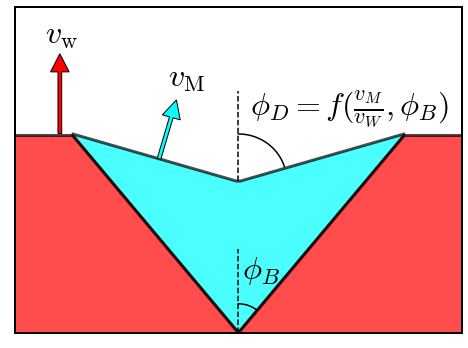

In [393]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(2*4,1.5*4)  )
plt.rcParams.update({'font.size': fsz*4})
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xym, facecolor=(0,1.,1), alpha=0.7, linewidth=3, edgecolor='k') )
ax.add_patch(patch.Polygon(xyw, facecolor=(1.0,0.,0.), alpha=0.7, linewidth=3, edgecolor='k') )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Wedge( (0,0), 0.55, np.arcsin(4/5.5)*180/np.pi, 180-np.arcsin(4/5.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
ax.add_patch(patch.FancyArrow( -0.48,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.48,0.55,0,0.22, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(1,0.,0) ,alpha=1  ))

ax.add_patch(patch.FancyArrow( xym[320,0],xym[320,1],-0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1.,1.0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( -xym[320,0],xym[320,1],0.01/xym[320,0],0.01/(xym[320,1]-xym[-1,1]), width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, facecolor=(0.,1.,1.0) ,alpha=1  ))

#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
ax.text(-0.52, 0.8, r'$v_{\rm w} $', color=(0,0,0))
ax.text(-0.19, 0.68, r'$v_{\rm M} $', color=(0,0,0))
#ax.text(0.44, 0.8, r'$v_{\rm w} $', color=(0,0,0))
#ax.text(0.12, 0.68, r'$v_{\rm M} $', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
#ax.text(-0.17, -0.1, 'Wildtype', color=(1,1,1))
#ax.text(-0.13, 0.3, 'Mutant')
#ax.plot( np.linspace(-np.max(xb), np.max(xb), 100), np.max(yb)+0*np.linspace(-1, 1, 100), 'k--', linewidth=1);

#ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
#ax.text(0.23,0.03,' Mutant emerges\n at t=0', color=(1,1,1))

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))

#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.23,10), color=(0.,0.,0), linestyle='--' )
r = 0.08; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.15,r'$\phi_B$', fontsize=32)
ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.25,10), color=(0.,0.,0), linestyle='--' )
r = 0.13; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
ys = ys[:95]; xs = xs[:95];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.032,0.6,r'$\phi_D=f(\frac{v_M}{v_W}, \phi_B)$', fontsize=32)


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0., 0.9)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('1201_fig3a.png', bbox_inches='tight')

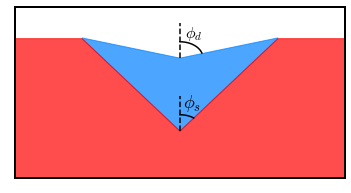

In [12]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-0.5,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),0.5,100);
xyw[400:500,0]=np.ones(100)*0.5; xyw[500:600,0]=np.linspace(0.5,-0.5,100); xyw[600:,0]=np.ones(100)*(-0.5);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(15*ipc,8*ipc))
ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=0.7) )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.1,r'$\phi_s$', fontsize=18)
ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
ys = ys[:95]; xs = xs[:95];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_d$', fontsize=16)
#ax.text(-0.04,3/15,'Mutant')
#ax.text(-0.05,-1/15,'Wildtype')

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.2, 8/15)
ax.set_xticks([]); ax.set_yticks([]);
#fig.savefig('0804_fig4a3.svg',bbox_inches='tight')

In [19]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
rms = np.zeros((2, 6));
rws = np.zeros((2, 6));
ts = np.zeros(6);
for i in np.arange(6):
    t = 0;
    if(i<4):
        for j in np.arange(2):
            dm = dir0+'1015/MONO'+str(j+1)+'/M1_01_'+str(i*2+1)+'.tif';
            dw = dir0+'1015/MONO'+str(j+1)+'/W1_01_'+str(i*2+1)+'.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);  
    elif(i==4):
         for j in np.arange(2):
            dm = dir0+'1016/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1016/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    elif(i==5):
         for j in np.arange(2):
            dm = dir0+'1017/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1017/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    ts[i] = t/4/86400;

In [22]:
xs = ((ts-ts[0])*24)[1:]; print(xs)
ys1 = np.mean(rws*mpx, axis=0)[1:];
es1 = np.std(rws*mpx, axis=0)[1:];
ys2 = np.mean(rms*mpx, axis=0)[1:];
es2 = np.std(rms*mpx, axis=0)[1:];
sol1 = curve_fit(linf, xdata=xs, ydata=ys1, sigma=es1)
sol2 = curve_fit(linf, xdata=xs, ydata=ys2, sigma=es2)
yf1 = xs*sol1[0][0]+sol1[0][1];
yf2 = xs*sol2[0][0]+sol2[0][1];
print(sol1)
print(sol2)

[ 3.85291667  6.34930556  8.71347222 27.25472222 47.24180556]
(array([0.0339871 , 1.43681916]), array([[ 9.31237687e-07, -2.03767641e-05],
       [-2.03767641e-05,  6.73097726e-04]]))
(array([0.02243238, 1.4551438 ]), array([[ 6.70931755e-08, -1.07881064e-06],
       [-1.07881064e-06,  3.19200833e-05]]))


In [16]:
ys = (rws[0]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rws[1]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rms[0]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rms[1]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )

0.03391902036968613
0.03409776857979788
-0.011178325137893134
-0.022642319991801888


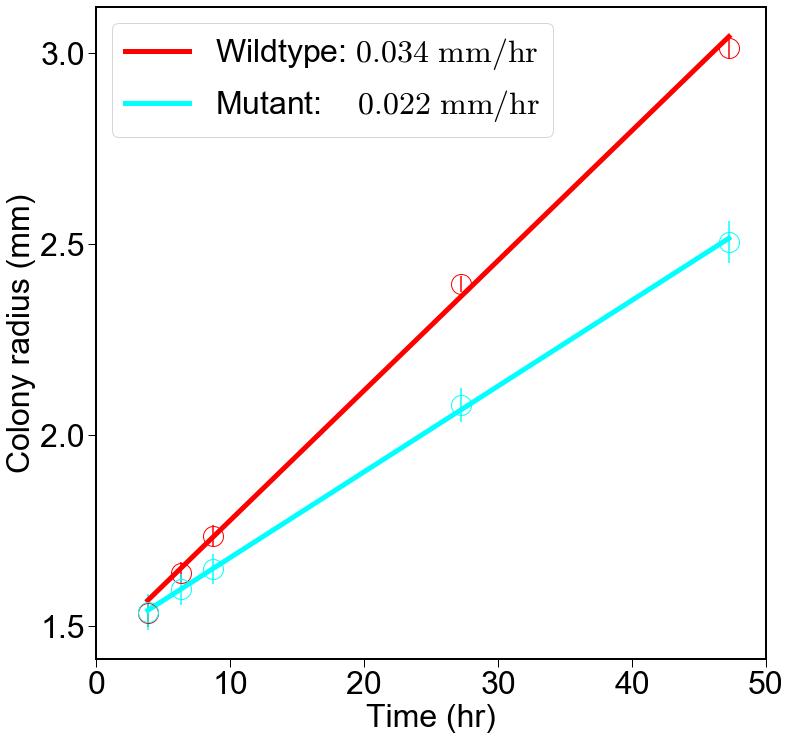

In [23]:
fig, ax = plt.subplots(figsize=(3*4,3*4))
plt.setp(ax.get_yticklabels(), Fontsize=fsz*4);
plt.setp(ax.get_xticklabels(), Fontsize=fsz*4);

ax.errorbar(xs, ys1, yerr=es1*2, linestyle='none', marker='o', mfc='none', markersize=20, color=(1,0,0));
ax.errorbar(xs, ys2, yerr=es2*2, linestyle='none', marker='o', mfc='none', markersize=20, color=(0,1,1));
ax.plot(xs, yf1, color=(1,0,0), linewidth=5);
ax.plot(xs, yf2, color=(0,1,1), linewidth=5);
ax.set_xlim( 0,50 )
ax.set_xlabel('Time (hr)',fontsize=fsz*4)
ax.set_yticks([1.5,2.,2.5,3])
ax.set_ylabel('Colony radius (mm)',fontsize=fsz*4)
ax.legend(['Wildtype: '+r'$0.034\ {\rm mm/hr}$','Mutant:    '+r'$0.022\ {\rm mm/hr}$'], fontsize=fsz*4)

#fig.savefig('1201_3b.png', bbox_inches='tight')

In [203]:
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/1_C2.tif';
comp1 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/2_C2.tif';
comp2 = Colony([dest1,dest2]);
dest1 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C1.tif';
dest2 = dir0+'2020/0704/razor/T4/A1A2M_OD0001/10X/3_C2.tif';
comp3 = Colony([dest1,dest2]);
t0= os.path.getmtime(dir0+'2020/0704/razor/start.txt');  
t = os.path.getmtime(dest1);  
print((t-t0)/3600)
#C:\Users\Hyun\Dropbox (MIT)\MRE_photos\photos\2020\0704\razor\T4\A1A2M_OD0001\10X

47.97888888888889


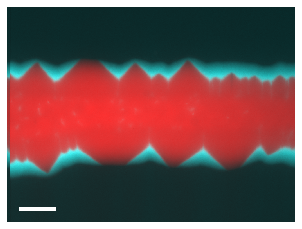

In [204]:
fig, ax = plt.subplots(1,1, figsize=(1*4, 1*4));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
margin = 130;
#ax.set_xlim(margin,1024-margin); 
ax.set_ylim(1024-margin,margin);
ax.set_xticks([]); ax.set_yticks([]);

ax.imshow(comp2.Image)

ax.set_axis_off()
ax.plot( np.linspace(0, 1/mpx, 10)+50, np.ones(10)*980-margin, color=(1,1,1), linewidth=4 )
ax.margins(0,0)

fig.savefig('1201_3c1_newc.png',bbox_inches='tight')

In [398]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);
for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        #inds2 = np.nonzero( img1[:,j]>0.1 )[0];
        #if( len(inds2)>0 ):
        #    b2[j] = np.max(inds2);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    
    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);


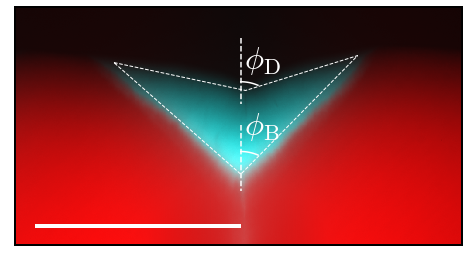

In [399]:

fig, ax = plt.subplots(figsize=(2*4,2*4))
#ax.plot( np.arange(L), b1 );
#ax.plot( np.arange(L), b2 );
#ax.plot( np.arange(L), b3 );
#ax.plot( np.arange(L), b4 );
comp = Colony([dest[i+5],dest[i]], center=False); 
img = comp.Image; #img = np.flip(img, axis=0);
ax.imshow(img);
#ax.imshow(img2, cmap=plt.cm.gray);
pol = np.zeros((5,2)); pol[0]=[xl,yl]; pol[1]=[xu,yu]; pol[2]=[xr,yr]; pol[3]=[xd,yd]; pol[4]=[xl,yl];
ax.add_patch(patch.Polygon(pol, facecolor='none',edgecolor=(1,1,1), linestyle='--') )

#ax.scatter(xl,yl, color='none', edgecolor='yellow');
#ax.scatter(xr,yr, color='none', edgecolor='yellow');
#ax.scatter(xu,yu, color='none', edgecolor='yellow');
#ax.scatter(xd,yd, color='none', edgecolor='yellow');

ax.plot( np.ones(10)*517, np.linspace(750,900,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+910; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,770,r'$\phi_{\rm B}$', color=(1,1,1), fontsize=fsz*4)
ax.plot( np.ones(10)*517, np.linspace(550,700,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+750; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,620,r'$\phi_{\rm D}$', color=(1,1,1), fontsize=fsz*4)
#ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
#r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
#ys = ys[:95]; xs = xs[:95];
#ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_{\rm d}$', fontsize=16)
#ax.text(-0.04,3/15,'Mutant')
#ax.text(-0.05,-1/15,'Wildtype')
ax.plot( np.linspace(0, 4/mpx, 10)+50, np.ones(10)*980, color=(1,1,1), linewidth=4 )

ax.set_xticks([]); ax.set_yticks([]);
ax.set_ylim(1024,1024*7/15)

fig.savefig('1201_3c2_newc.png',bbox_inches='tight')

In [401]:
phid_expm4 = np.arctan( u/y )*180/np.pi
phis_expm4 = np.arctan( u/v2)*180/np.pi
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];

72.73$\pm$0.292
73.06$\pm$2.102


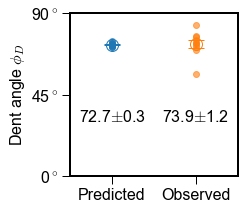

In [404]:
#####
mpl.rcParams['font.size'] = fsz*2.;

fig, ax = plt.subplots(1,1,  figsize=(1.5*2, 1.5*2) )

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 
#s1=v1/v2; s2 = vr_expm1; 
ax.scatter(s1*0+1, s1, marker='o', alpha=0.6 );
ax.scatter(s2*0+2, s2, marker='o', alpha=0.6 );
#pol = np.zeros((5,2)); pol[0]=[0,np.average(s1)+np.std(s1)/(10**0.5)]; pol[1]=[0,np.average(s1)-np.std(s1)/(10**0.5)]; pol[2]=[3,np.average(s1)-np.std(s1)/(10**0.5)]; pol[3]=[3,np.average(s1)+np.std(s1)/(10**0.5)]; pol[4]=pol[0];
#ax.add_patch(patch.Polygon(pol, facecolor=(0,0.5,1), alpha=0.1) )
#pol = np.zeros((5,2)); pol[0]=[0,np.average(s2)+np.std(s2)/(10**0.5)]; pol[1]=[0,np.average(s2)-np.std(s2)/(10**0.5)]; pol[2]=[3,np.average(s2)-np.std(s2)/(10**0.5)]; pol[3]=[3,np.average(s2)+np.std(s2)/(10**0.5)]; pol[4]=pol[0];
#ax.add_patch(patch.Polygon(pol, facecolor=(1,0.,0), alpha=0.1) )
ax.errorbar(1, np.average(s1), yerr=np.std(s1)/(10**0.5), marker='o', mfc='none', ms=12, capsize=8 );
ax.errorbar(2., np.average(s2), yerr=np.std(s2)/(10**0.5), marker='o', mfc='none', ms=12, capsize=8 );
print(np.str( np.average(s1) )[:5]+'$\pm$'+np.str( np.std(s1)/(10**0.5) )[:5])
print(np.str( np.average(s2) )[:5]+'$\pm$'+np.str( np.std(s2)/(10**0.5) )[:5])
ax.text(0.6, 30, '72.7'+'$\pm$'+'0.3' )
ax.text(1.6, 30, '73.9'+'$\pm$'+'1.2' )
ax.set_xticks([1,2]);
ax.set_xticklabels(['Predicted','Observed'] ,fontsize=fsz*2)
ax.set_xlim(0.5,2.5)
ax.set_ylim(0,90)
ax.set_ylabel('Dent angle '+r'$\phi_D$', fontsize=fsz*2)
ax.set_yticks([0,45,90]);
ax.set_yticklabels(['0'+r'$^\circ$','45'+r'$^\circ$','90'+r'$^\circ$']);
#ax.set_ylim(0.,1.)
#ax.set_ylabel('$v_m / v_w$')
fig.savefig('1201_3d.png',bbox_inches='tight')

## Fig. 4

In [356]:
data = np.zeros((4,3,2,8,5));# Day, Replicate, WT/Mut, 8 x5 comp wells
data[0,:,0,:,:2]=9; data[0,:,1,:,:2]=1;
data[0,:,0,:,2]=5; data[0,:,1,:,2]=5;
data[0,:,0,:,3:]=1; data[0,:,1,:,3:]=9;
nreps = [2,3,3];
for day in np.arange(3):
    fname0 = 'D'+str(day+2)+'_DF100'
    nrep = nreps[day];
    for i in np.arange(nrep):
        fname = fname0+'_R'+str(i+1)
        xl = pd.read_excel('../../ColonyCounts/20Mar_DentLiquid/'+fname+'.xlsx',sheet_name='Data');
        wt = np.array(xl['WT'][8:]); wt = wt.reshape((8,5));     
        mut = np.array(xl['M'][8:]); mut = mut.reshape((8,5));
        for j in np.arange(4):
            wt[j*2+1] = np.flip(wt[j*2+1]);
            mut[j*2+1] = np.flip(mut[j*2+1]);
        data[day+1,i,0] = wt; data[day+1,i,1] = mut;
data_DF100 = np.copy(data);


In [357]:
sums = np.sum(data_DF100, axis=1);
fracs = sums[:,1]/(sums[:,0]+sums[:,1])
# fracs[:, i, j]
# i : 0,4 / 1,5 
# j : 0-1 / 2 / 3-4
fracs2 = np.zeros((4,3,2)); 
fracs2err = np.zeros((4,3,2)); 
fracs2[:,0,0] = (fracs[:,0,0] + fracs[:,4,0] + fracs[:,0,1] + fracs[:,4,1] )/4;
fracs2[:,1,0] = (fracs[:,0,2] + fracs[:,4,2] )/2;
fracs2[:,2,0] = (fracs[:,0,3] + fracs[:,4,3] + fracs[:,0,4] + fracs[:,4,4] )/4;
fracs2[:,0,1] = (fracs[:,1,0] + fracs[:,5,0] + fracs[:,1,1] + fracs[:,5,1] )/4;
fracs2[:,1,1] = (fracs[:,1,2] + fracs[:,5,2] )/2;
fracs2[:,2,1] = (fracs[:,1,3] + fracs[:,5,3] + fracs[:,1,4] + fracs[:,5,4] )/4;
fracs_DF100 = np.copy(fracs)

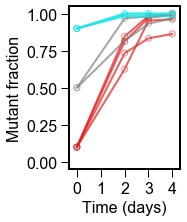

In [365]:
inits = [0.1, 0.1, 0.5, 0.9, 0.9];
mpl.rcParams['font.size'] = fsz*2;
fig, ax = plt.subplots(figsize=(1.*2, 1.5*2  ))
#for i in np.arange(3):
#    for j in np.arange(2):
#        ax.plot( [0,2,3,4], fracs2[:,i,j], color=(0,0.5,1.), marker='o', alpha=0.8 )
cs = [(0.9,0.1,0.1), (0.9,0.1,0.1), (0.5,0.5,0.5), (0.1,0.9,0.9), (0.1,0.9,0.9)] 
for i in np.arange(5):
    for j in np.arange(2):
        ax.plot( [0,2,3,4], fracs[:,j,i], color=cs[i], alpha=0.7, linewidth=2 )
        ax.scatter( [0,2,3,4], fracs[:,j,i], facecolor='none', edgecolor=cs[i], alpha=0.5, marker='o' )
ax.set_ylim(-0.05,1.05)
ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(['Day 0','Day 1','Day 2', 'Day 3'])
ax.set_xlabel('Time (days)', fontsize=fsz*2)
ax.set_ylabel('Mutant fraction', fontsize=fsz*2)
#ax.set_title('Competition in liquid')
#ax.legend(['WT Sc vs M Tq' ,'WT Tq vs M Sc' ])
#ax.set_title('DF 100')
fig.savefig('1201_4a1.png',bbox_inches='tight')

## Geometric model Supp

In [1]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)

In [5]:
param = (0.3,0.3,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100

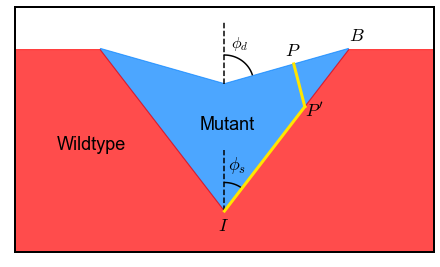

In [57]:


fig, ax = plt.subplots(figsize = (5*1.5,3*1.5) )
ax.set_xticks([]); ax.set_yticks([]);

xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-0.5,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),0.5,100);
xyw[400:500,0]=np.ones(100)*0.5; xyw[500:600,0]=np.linspace(0.5,-0.5,100); xyw[600:,0]=np.ones(100)*(-0.5);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);

ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=0.7) )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.1,r'$\phi_s$', fontsize=18)
ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
ys = ys[:95]; xs = xs[:95];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_d$', fontsize=16)
ax.text(-0.06,0.2,'Mutant',fontsize=18)
ax.text(-0.4,0.15,'Wildtype',fontsize=18)


t = 65
xp = xps[t]; yp = yps[t]; 
ax.plot( xb[:t], yb[:t], color=(1.,0.9,0) , linewidth=3);
xs = np.linspace( xp, xb[t-1], 10 ); ys = np.linspace( yp, yb[t-1], 10 );
ax.plot( xs, ys, color=(1.,0.9,0.) , linewidth=3);

ax.text(xp-0.02, yp+0.02,'$P$', fontsize=18); #ax.scatter(xp, yp, color=(0,0.5,0));
ax.text(xb[t-1], yb[t-1]-0.025,'$P\'$', fontsize=18); #ax.scatter(xb[t-1], yb[t-1], color=(0,0.5,0));
ax.text(xb[-1], yb[-1]+0.02,'$B$', fontsize=18); #ax.scatter(xb[-1], yb[-1]+0.005, color='k');
ax.text(-0.015,-0.05,'$I$', fontsize=18); #ax.scatter(0, 0, color=(0,0.5,0));
#ax.text(-0.028, 0.12*param[2], r'$2\phi_s$', fontsize=14);
#ax.text(-0.018, 0.8*param[2]+0.01, r'$2\phi_d$', fontsize=14);

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.1,0.5)
#plt.plot( np.linspace(0, 0, 10) , np.linspace(0, (param[2])*0.7, 10)*1.2, linestyle='--', color='k');



fig.savefig('1201_g2.png', bbox_inches='tight')

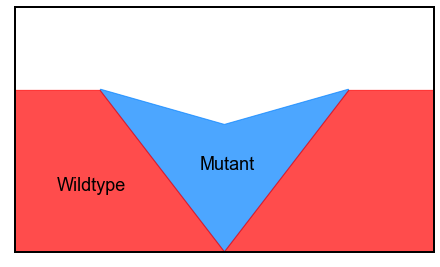

In [62]:

ax.set_xticks([]); ax.set_yticks([]);
param = (0.3,0.3,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;

fig, ax = plt.subplots(figsize = (5*1.5,3*1.5) )
ax.set_xticks([]); ax.set_yticks([]);

xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-0.5,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),0.5,100);
xyw[400:500,0]=np.ones(100)*0.5; xyw[500:600,0]=np.linspace(0.5,-0.5,100); xyw[600:,0]=np.ones(100)*(-0.5);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);

ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=0.7) )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )

ax.text(-0.06,0.2,'Mutant',fontsize=18)
ax.text(-0.4,0.15,'Wildtype',fontsize=18)




ax.set_xlim(-0.5,0.5)
ax.set_ylim(0.,0.6)
#plt.plot( np.linspace(0, 0, 10) , np.linspace(0, (param[2])*0.7, 10)*1.2, linestyle='--', color='k');



fig.savefig('1201_g3a.png', bbox_inches='tight')

In [63]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.45,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

# 1001 Revisit

In [424]:
dest1 = dir0+'1017/COMP01/WM11_1_1.tif';
dest2 = dir0+'1017/COMP01/WM11_2_1.tif';
comp = Colony([dest1,dest2]);
dest = dir0+'1017/MONO1/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO1/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

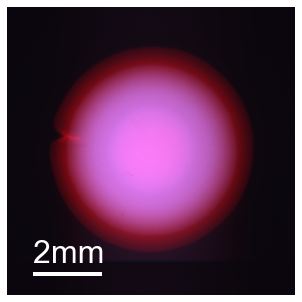

In [448]:
fig, ax = plt.subplots(1,1, figsize=(1*4, 1*4));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#for i in np.arange(3):
ax.set_xlim(0,1024); ax.set_ylim(1024,0);
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( w01.Image+m01.Image)
#ax.add_patch( patch.Circle( (512,512), radius=w01.R, facecolor=(1,0,0),edgecolor=(1,0,0),alpha=0.5 ));
#ax.add_patch( patch.Circle( (512,512), radius=m01.R, facecolor=(0,0.5,1.),edgecolor=(0,0.5,1.0), alpha=0.5 ) );
#ax.text(412,100,'Mixed', color=(1,1,1));
#ax.plot( np.arange(512), np.ones(512)*(512-m01.R), color=(1,1,1), linestyle='--' )
#ax.plot( np.arange(512), np.ones(512)*(512+m01.R), color=(1,1,1), linestyle='--' )
ax.set_axis_off()
ax.plot( np.linspace(0, 2/mpx, 10)+100, np.ones(10)*950, color=(1,1,1), linewidth=4 )
ax.text( 90, 910, '2mm', color=(1,1,1) )
#ax.text( 130, 910, '2mm', color=(1,1,1) )
ax.margins(0,0)
fig.savefig('1013_fig1b2d.png', bbox_inches='tight')#,bbox_inches='tight')

#plt.gca().set_axis_off()
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)

#plt.savefig("myfig.pdf")

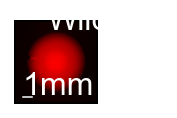

In [269]:
fig, ax = plt.subplots(1,1, figsize=(1.5, 1.5));
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#for i in np.arange(3):
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( w01.Image)
ax.text(412,100,'Wildtype', color=(1,1,1));
#ax.plot( np.arange(512)+512, np.ones(512)*(512-w01.R), color=(1,1,1), linestyle='--' )
#ax.plot( np.arange(512)+512, np.ones(512)*(512+w01.R), color=(1,1,1), linestyle='--' )

ax.plot( np.linspace(0, 1/mpx, 10)+100, np.ones(10)*950, color=(1,1,1) )
ax.text( 90, 910, '1mm', color=(1,1,1) )

fig.savefig('1001_fig1b2a.svg',bbox_inches='tight')

# 0813: Revisit

## Fig. 1

### Fig. 1A

### Fig. 1B

In [11]:
dest1 = dir0+'1017/COMP01/WM11_1_1.tif';
dest2 = dir0+'1017/COMP01/WM11_2_1.tif';
comp = Colony([dest1,dest2]);
dest = dir0+'1017/MONO1/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO1/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

NameError: name 'ys1' is not defined

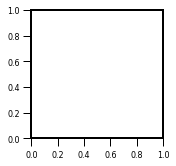

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6*ipc, 6*ipc))
ax.bar(0, ys1[-1], color=(1,0,0), alpha=0.7);
ax.bar(1, ys2[-1], color=(0,0.5,1), alpha=0.7);
ax.set_xlim(-1,2); ax.set_xticks([0,1]); ax.set_xticklabels(['Wildtype','Mutant']);
ax.set_ylabel('Colony radius at 48hr (mm)')
fig.savefig('0819_fig1b1.svg',bbox_inches='tight')

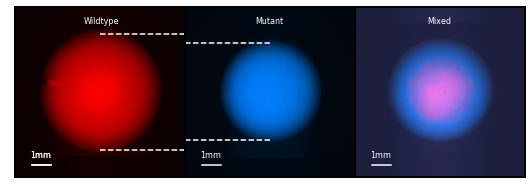

In [13]:
fig, ax = plt.subplots(1,3, figsize=(18*ipc,6*ipc));
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
for i in np.arange(3):
    ax[i].set_xticks([]); ax[i].set_yticks([]);
ax[0].imshow( w01.Image)
ax[0].text(412,100,'Wildtype', color=(1,1,1));
ax[0].plot( np.arange(512)+512, np.ones(512)*(512-w01.R), color=(1,1,1), linestyle='--' )
ax[0].plot( np.arange(512)+512, np.ones(512)*(512+w01.R), color=(1,1,1), linestyle='--' )

ax[1].imshow( m01.Image)
ax[1].text(422,100,'Mutant', color=(1,1,1));
ax[1].plot( np.arange(512), np.ones(512)*(512-m01.R), color=(1,1,1), linestyle='--' )
ax[1].plot( np.arange(512), np.ones(512)*(512+m01.R), color=(1,1,1), linestyle='--' )
ax[0].plot( np.linspace(0, 1/mpx, 10)+100, np.ones(10)*950, color=(1,1,1) )
ax[0].text( 90, 910, '1mm', color=(1,1,1) )

ax[2].imshow( comp.Image)
ax[2].text(432,100,'Mixed', color=(1,1,1));
#ax[1].plot( np.arange(512), np.ones(512)*(512-w01.R), color=(1,1,1), linestyle='--' )
#ax[1].plot( np.arange(512), np.ones(512)*(512+w01.R), color=(1,1,1), linestyle='--' )
#ax[1].plot( np.arange(512)+512, np.ones(512)*(512-m01.R), color=(1,1,1), linestyle='--' )
#ax[1].plot( np.arange(512)+512, np.ones(512)*(512+m01.R), color=(1,1,1), linestyle='--' )
for i in np.arange(3):
    ax[i].plot( np.linspace(0, 1/mpx, 10)+100, np.ones(10)*950, color=(1,1,1) )
    ax[i].text( 90, 910, '1mm', color=(1,1,1) )

fig.savefig('1001_fig1b2.svg',bbox_inches='tight')

### Fig. 1C

In [382]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91','WM11','WM19','WM199'];
comps = np.zeros([3,5,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(5):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

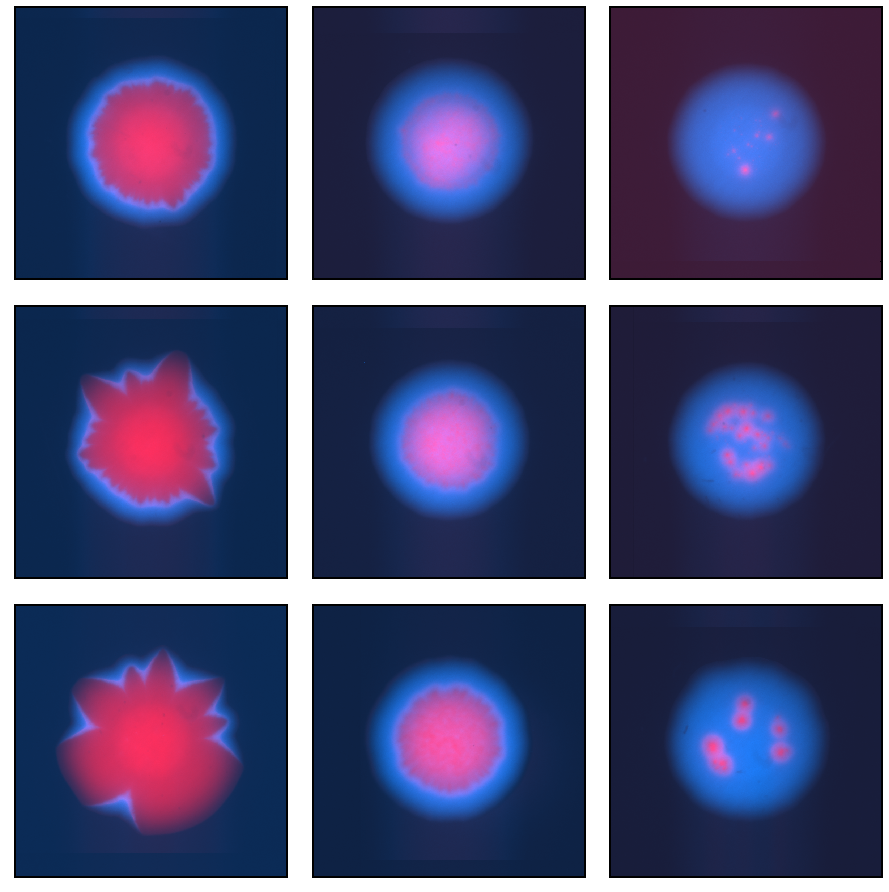

In [385]:
fig, ax = plt.subplots(3, 3, gridspec_kw={'wspace':0.,'hspace':0.1}, figsize=(4*4,4*4) );
for i in np.arange(3):
    for j in np.arange(3):
        ax[i,j].imshow(comps[i,j*2]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('1012_fig1c.png', bbox_inches='tight')

## Fig. 2

### Fig. 2A

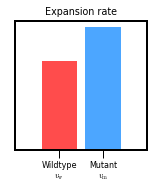

In [489]:
fig, ax = plt.subplots(1,1, figsize=(6*ipc, 6*ipc))
ax.bar(0, 0.4, color=(1,0,0), alpha=0.7);
ax.bar(1, 0.55, color=(0,0.5,1), alpha=0.7);
ax.set_xlim(-1,2); ax.set_xticks([0,1]); ax.set_xticklabels(['Wildtype\n'+ r'$v_{\rm w}$','Mutant\n'+ r'$v_{\rm m}$']);
ax.set_title('Expansion rate'); ax.set_yticks([]);
fig.savefig('0819_fig2a1.svg',bbox_inches='tight')

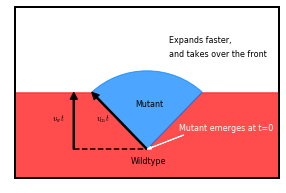

In [248]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.55,0.4);
param2 = ((0.55**2-0.4**2)**0.5,0.55,0.4);

xps, yps = xyp(1, np.arange(100)/100, param2 )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param2[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

l1 = len(xr2[xr2<min(xps)]);   l2=100; #l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2 ) * 2,2));
xym[:l1,0] = xr2[xr2<min(xps)]; xym[l1:l2+l1,0] = np.flip(xb);
xym[-l1-l2:-l1,0] = -xb; xym[-l1:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l1,1] = yr2[xr2<min(xps)]; xym[l1:l2+l1,1] = np.flip(yb);
xym[-l1:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l1,1] = yb;
xym3a = np.copy(xym);
l=100;
xym = np.zeros(((l+l ) * 2,2));
xym[:l,0] = np.linspace(0,max(xb),l); xym[l:l*2,0] = np.linspace(max(xb),0,l);
xym[2*l:3*l,0] = -np.linspace(0,max(xb),l); xym[-l:,0] = -np.linspace(max(xb),0,l);
xym[:l,1] = np.linspace(max(yr2),max(yb),l); xym[l:l*2,1] = np.linspace(max(yb),max(yb),l)+0.006;
xym[2*l:3*l,1] = np.linspace(max(yb),max(yb),l)+0.006; xym[-l:,1] = np.linspace(max(yb),max(yr2),l);
xym3b = np.copy(xym);
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(12*ipc,8*ipc)  )
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
#ax.add_patch(patch.Polygon(xym3b, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
ax.add_patch(patch.Wedge( (0,0), 0.55, np.arcsin(4/5.5)*180/np.pi, 180-np.arcsin(4/5.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
ax.add_patch(patch.FancyArrow( -0.5,0,0,0.4, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( 0.,0,-(0.55**2-0.4**2)**0.5,0.4, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
ax.text(-0.65, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
ax.text(-0.35, 0.2, r'$v_{\rm m} t$', color=(0,0,0))
ax.text(-0.11, -0.1, 'Wildtype')
ax.text(-0.08, 0.3, 'Mutant')

ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
ax.text(0.22,0.13,'Mutant emerges at t=0', color=(1,1,1))

#ax.add_patch(patch.FancyArrow( 0.,0.6,0,0.3, width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
ax.text(0.15,0.75,'Expands faster,')
ax.text(0.15,0.65,'and takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.5,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.5,-0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.9,0.9)
ax.set_ylim(-0.2, 1.0)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('0819_fig2a2.svg', bbox_inches='tight')

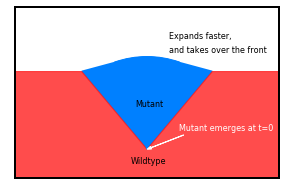

In [271]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.65,0.55);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );


l1 = len(xps[xps>0]);  l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2+l3 ) * 2,2));
xym[:l2,0] = xr2[xr2<min(xps)]; xym[l2:l2+l1,0] = xps[xps>0]; xym[l2+l1:l2+l1+l3,0] = np.flip(xb);
xym[-l1-l2-l3:-l1-l2,0] = -xb; xym[-l2-l1:-l2,0] = -np.flip(xps[xps>0]); xym[-l2:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l2,1] = yr2[xr2<min(xps)]; xym[l2:l2+l1,1] = yps[xps>0]; xym[l2+l1:l2+l1+l3,1] = np.flip(yb);
xym[-l2:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l2,1] = np.flip(yps[xps>0]); xym[-l2-l1-l3:-l2-l1,1] = yb;
xym2 = np.copy(xym);

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(12*ipc,8*ipc)  )
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xym, facecolor=(0,0.5,1), alpha=1, edgecolor='none') )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
ax.add_patch(patch.Wedge( (0,0), 0.65, 70, 180-70, color=(0,0.5,1), alpha=1  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
#ax.add_patch(patch.FancyArrow( -0.45,0,0,0.55, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.58, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
ax.text(-0.11, -0.1, 'Wildtype')
ax.text(-0.08, 0.3, 'Mutant')

ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
ax.text(0.22,0.13,'Mutant emerges at t=0', color=(1,1,1))

#ax.add_patch(patch.FancyArrow( 0.,0.6,0,0.2, width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
ax.text(0.15,0.78,'Expands faster,')
ax.text(0.15,0.68,'and takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.9,0.9)
ax.set_ylim(-0.2, 1.0)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('0819_fig2a2.svg', bbox_inches='tight')

### Fig. 2B

In [284]:
dest1 = dir0+'1017/COMP0001/WM991_1_1.tif';
dest2 = dir0+'1017/COMP0001/WM991_2_1.tif';
comp = Colony([dest1,dest2]);

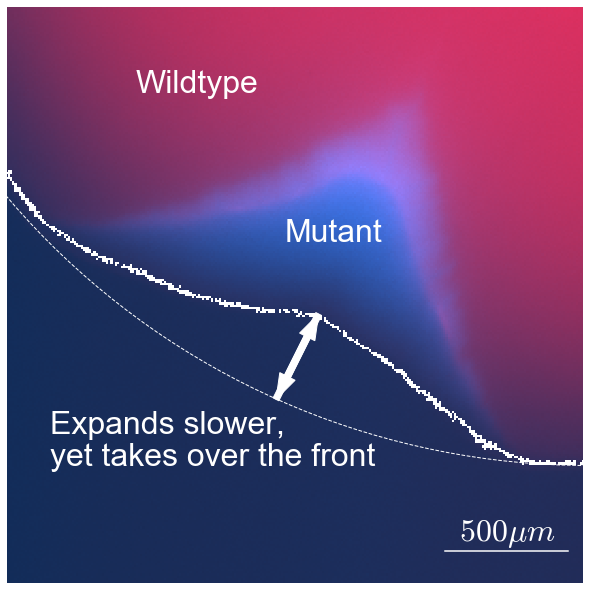

In [302]:
fig, ax = plt.subplots(1,1, figsize=(2*4, 2*4));
plt.rcParams.update({'font.size': fsz*4})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#for i in np.arange(3):
ax.set_xticks([]); ax.set_yticks([]);
#ax.plot( np.arange(512)+512, np.ones(512)*(512-w01.R), color=(1,1,1), linestyle='--' )
#ax.plot( np.arange(512)+512, np.ones(512)*(512+w01.R), color=(1,1,1), linestyle='--' )
ax.set_axis_off()
img = np.copy(np.flip(comp.Image, axis=0));
#target = np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0);
target = np.flip( (comp.ImageBW>np.max(comp.ImageBW)*0.35)*(comp.ImageBW<np.max(comp.ImageBW)*0.36), axis=0);
for i in np.arange(3):
    img[:,:,i] = img[:,:,i]*(1-target) + target*1
#img[:,:,1] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
#img[:,:,0] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
#img[:,:,2] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
ax.imshow( img )
ax.add_patch(patch.Circle( (512,512), 357, facecolor='none', edgecolor=(1,1,1),linestyle='--' ))
#ax.imshow(np.flip(comp.Edge*(comp.ImageBW<0.1), axis=0))
ax.add_patch(patch.FancyArrow( 386,226,-20,-40, width=3, length_includes_head=True, head_width=8, color=(1,1,1), alpha=1  ))
ax.add_patch(patch.FancyArrow( 386-20,226-40,20,40, width=3, length_includes_head=True, head_width=8, color=(1,1,1), alpha=1  ))
ax.text(260,170,'Expands slower,', color=(1,1,1))
ax.text(260,155,'yet takes over the front', color=(1,1,1))
s = 270;
ax.set_xlim(240,240+s); ax.set_ylim(100,100+s);
ax.plot( np.linspace(0, 0.5/mpx, 10)+175+s, np.ones(10)*115, color=(1,1,1) )
ax.text( 182+s, 120, r'$500\mu m$', color=(1,1,1) )
ax.text(370, 260, 'Mutant', color=(1,1,1))
ax.text(300, 330, 'Wildtype', color=(1,1,1))
fig.savefig('1012_fig2b.png', bbox_inches='tight')

### Fig. 2C

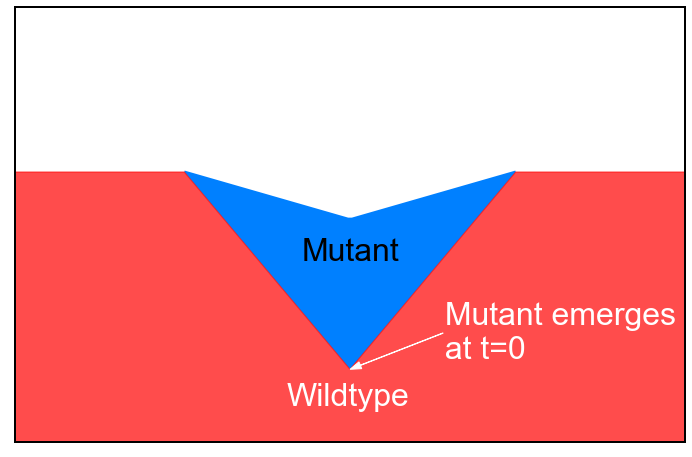

In [313]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(3*4,2*4)  )
plt.rcParams.update({'font.size': fsz*4})
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
ax.add_patch(patch.Polygon(xym, facecolor=(0,0.5,1), alpha=1, edgecolor='none') )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Wedge( (0,0), 0.55, np.arcsin(4/5.5)*180/np.pi, 180-np.arcsin(4/5.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
#ax.add_patch(patch.FancyArrow( -0.45,0,0,0.55, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.58, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
ax.text(-0.17, -0.1, 'Wildtype', color=(1,1,1))
ax.text(-0.13, 0.3, 'Mutant')

ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
ax.text(0.23,0.03,' Mutant emerges\n at t=0', color=(1,1,1))

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.9,0.9)
ax.set_ylim(-0.2, 1.0)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('1012_fig2c2.png', bbox_inches='tight')

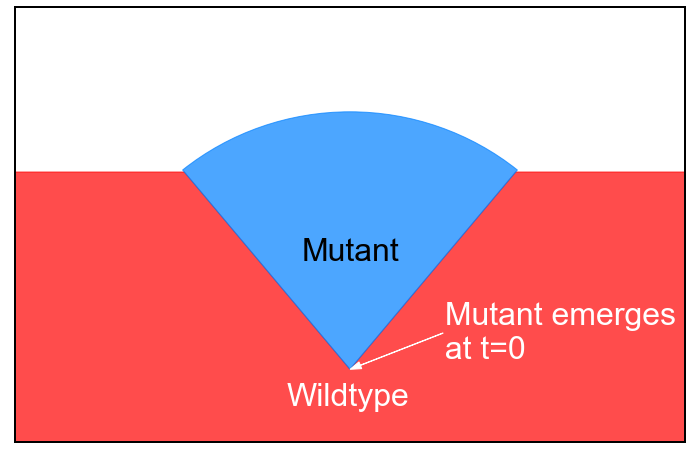

In [314]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.45,0.4,0.55); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;

xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-1,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),1,100);
xyw[400:500,0]=np.ones(100); xyw[500:600,0]=np.linspace(1,-1,100); xyw[600:,0]=np.ones(100)*(-1);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(3*4,2*4)  )
#ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=0.7, edgecolor='none') )
#ax.add_patch(patch.Polygon(xym, facecolor=(0,0.5,1), alpha=1, edgecolor='none') )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=0.7) )
ax.add_patch(patch.Wedge( (0,0), (0.45**2+0.55**2)**0.5, np.arctan(5.5/4.5)*180/np.pi, 180-np.arctan(5.5/4.5)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
#ax.plot( np.linspace(-0.5,0,10), np.zeros(10), color=(0,0,0), linestyle='--')
#ax.( np.ones(10)*(-0.5), np.linspace(0,0.55,10), color=(1,1,1), linestyle='--')
#ax.add_patch(patch.FancyArrow( -0.45,0,0,0.55, width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.,0,-0.45,0., width=0.01, length_includes_head=True, head_width=0.05, head_length=0.05, color=(0,0.,0) ,alpha=1  ))
#ax.text(-0.58, 0.2, r'$v_{\rm w} t$', color=(0,0,0))
#ax.text(-0.25, 0.05, r'$u t$', color=(0,0,0))
ax.text(-0.17, -0.1, 'Wildtype', color=(1,1,1))
ax.text(-0.13, 0.3, 'Mutant')

ax.add_patch(patch.FancyArrow( 0.25,0.1,-0.25,-0.1, length_includes_head=True, head_width=0.02, color=(1,1.,1) ,alpha=1  ))
ax.text(0.23,0.03,' Mutant emerges\n at t=0', color=(1,1,1))

#ax.text(-0.34,0.78,'Expands slower,\nyet takes over the front')
#ax.text(0.15,0.68,'yet takes over the front')
#ax.add_patch(patch.FancyArrow( 0.4,0.65,0.3,0., width=0.05, length_includes_head=True, head_width=0.1, color=(0,0.5,1) ,alpha=0.5  ))
#ax.add_patch(patch.FancyArrow( -0.4,0.65,-0.3,0., width=0.01, length_includes_head=True, head_width=0.03, color=(0,0.5,1) ,alpha=0.5  ))


#ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
#ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.9,0.9)
ax.set_ylim(-0.2, 1.0)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('1012_fig2c1.png', bbox_inches='tight')

### Fig. 2D

In [307]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xym1 = np.copy(xym);
xywl = np.zeros((400,2));
xywl[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl[200:300,0] = np.linspace(0,-0.5,100); xywl[300:400,0]=np.ones(100)*(-0.5);
xywl[:100,1]=np.ones(100)*np.max(yb); xywl[100:200,1]=np.linspace(np.max(yb),0,100);
xywl[200:300,1] = np.zeros(100); xywl[300:400,1]=np.linspace(0,np.max(yb),100);
xywr = np.copy(xywl); xywr[:,0]=xywr[:,0]*(-1);

In [308]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.43,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );


l1 = len(xps[xps>0]);  l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2+l3 ) * 2,2));
xym[:l2,0] = xr2[xr2<min(xps)]; xym[l2:l2+l1,0] = xps[xps>0]; xym[l2+l1:l2+l1+l3,0] = np.flip(xb);
xym[-l1-l2-l3:-l1-l2,0] = -xb; xym[-l2-l1:-l2,0] = -np.flip(xps[xps>0]); xym[-l2:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l2,1] = yr2[xr2<min(xps)]; xym[l2:l2+l1,1] = yps[xps>0]; xym[l2+l1:l2+l1+l3,1] = np.flip(yb);
xym[-l2:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l2,1] = np.flip(yps[xps>0]); xym[-l2-l1-l3:-l2-l1,1] = yb;
xym2 = np.copy(xym);

In [309]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.55,0.4);
param2 = ((0.55**2-0.4**2)**0.5,0.55,0.4);

xps, yps = xyp(1, np.arange(100)/100, param2 )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param2[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

l1 = len(xr2[xr2<min(xps)]);   l2=100; #l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2 ) * 2,2));
xym[:l1,0] = xr2[xr2<min(xps)]; xym[l1:l2+l1,0] = np.flip(xb);
xym[-l1-l2:-l1,0] = -xb; xym[-l1:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l1,1] = yr2[xr2<min(xps)]; xym[l1:l2+l1,1] = np.flip(yb);
xym[-l1:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l1,1] = yb;
xym3a = np.copy(xym);
l=100;
xym = np.zeros(((l+l ) * 2,2));
xym[:l,0] = np.linspace(0,max(xb),l); xym[l:l*2,0] = np.linspace(max(xb),0,l);
xym[2*l:3*l,0] = -np.linspace(0,max(xb),l); xym[-l:,0] = -np.linspace(max(xb),0,l);
xym[:l,1] = np.linspace(max(yr2),max(yb),l); xym[l:l*2,1] = np.linspace(max(yb),max(yb),l)+0.006;
xym[2*l:3*l,1] = np.linspace(max(yb),max(yb),l)+0.006; xym[-l:,1] = np.linspace(max(yb),max(yr2),l);
xym3b = np.copy(xym);
xywl3 = np.zeros((400,2));
xywl3[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl3[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl3[200:300,0] = np.linspace(0,-0.5,100); xywl3[300:400,0]=np.ones(100)*(-0.5);
xywl3[:100,1]=np.ones(100)*np.max(yb); xywl3[100:200,1]=np.linspace(np.max(yb),0,100);
xywl3[200:300,1] = np.zeros(100); xywl3[300:400,1]=np.linspace(0,np.max(yb),100);
xywr3 = np.copy(xywl3); xywr3[:,0]=xywr3[:,0]*(-1);
xywl4 = np.zeros((400,2));
xywl4[:100,0]=np.linspace(-2.5,-np.max(xb),100); xywl4[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl4[200:300,0] = np.linspace(0,-2.5,100); xywl4[300:400,0]=np.ones(100)*(-2.5);
xywl4[:100,1]=np.ones(100)*np.max(yb); xywl4[100:200,1]=np.linspace(np.max(yb),0,100);
xywl4[200:300,1] = np.zeros(100); xywl4[300:400,1]=np.linspace(0,np.max(yb),100);
xywr4 = np.copy(xywl4); xywr4[:,0]=xywr4[:,0]*(-1);


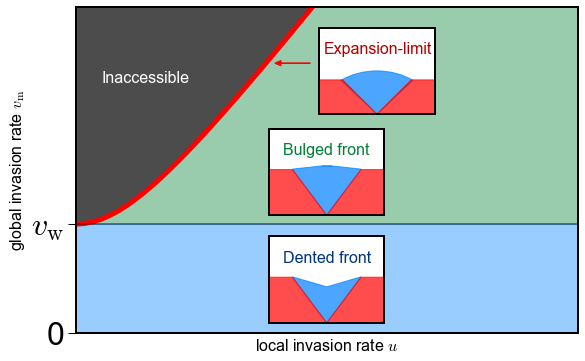

In [310]:
fig, ax = plt.subplots(figsize = (9,6) )
ax.set_xticks([0]); ax.set_yticks([0,1]); ax.set_yticklabels([0,r'$v_{\rm w}$'])

plt.rcParams.update({'font.size': fsz*2})
xs = np.linspace(0,10,100);
ys1 = np.sqrt(1 + xs**2);
xyf = np.zeros((300,2));
xyf[:100,0]=xs; xyf[:100,1]=ys1;
xyf[100:200,0]=np.flip(xs); xyf[100:200,1]=np.ones(100)*ys1[-1];
xyf[200:,0]=0; xyf[200:,1]=np.flip(ys1);

xy2 = np.zeros((300,2));
xy2[:100,0]=xs; xy2[:100,1]=ys1;
xy2[100:200,0]=np.ones(100)*xs[-1]; xy2[100:200,1]=np.flip(ys1);
xy2[200:,0]=np.flip(xs); xy2[200:,1]=np.ones(100)*1;

ax.add_patch(patch.Polygon(xyf, color=(.0,0.,0.), alpha=0.7) )
ax.add_patch(patch.Polygon(xy2, color=(0,0.5,0.2), alpha=0.4) )
ax.add_patch(patch.Rectangle( (0,0),10,1 , color=(0,0.5,1.), alpha=0.4) )
ax.plot(xs, ys1, color=(1,0,0), alpha=1, linewidth=5)
ax.plot(xs, xs*0+1, color='k', alpha=0.5)
ax.set_xticks([]);
ax.set_xlim(0,6.)
ax.set_ylim(0,3.)
ax.set_xlabel('local invasion rate '+r'$u$', fontsize=fsz*2)
ax.set_ylabel('global invasion rate '+r'$v_{\rm m}$', fontsize=fsz*2)
#ax.text(1.1,0.5, 'Dented')
#ax.text(0.5,1.9, 'Bulged')
#ax.text(1.9,1.3, 'Mixed')
#ax.text(1.17,0.8,r'$v_2 < v_1$')
#ax.text(1.8,1.9,r'$ v_1 < v_2 < \sqrt{v_1^2+u^2}$')
#ax.text(0.3,2.3,r'$ v_2 > \sqrt{v_1^2+u^2}$')
#ax.text(2.3,1.5,'Bulged front')
#ax.text(2.25,0.5,'Dented front')
ax.text(0.3,2.3,'Inaccessible', color=(1,1,1))
#ax.text(2.9,2.45,'Expansion-limit',color=(1,0,0) )
#ax.text(2.55,2.35,'limit',color=(1,0,0) )
ax.add_patch(patch.FancyArrow(2.8,2.48,-0.35,0.0, head_width=0.05, color=(1,0,0)))
#ax.text(2.6,2.6,r'$ v_{\rm w} = \sqrt{v_{\rm m}^2+u^2}$', color=(1,0,0))

a = .7;
rs = [1.,1./3*4]; 
p0=[0.5,0];
axin1 = inset_axes(ax, width=0.8*2, height=0.6*2, bbox_to_anchor=(0, 0, 0.63, 0.65), bbox_transform=ax.transAxes)
axin1.set_xticks([]); axin1.set_yticks([]);
axin1.add_patch(patch.Polygon(xym2*rs+p0, color=(0,0.5,1), alpha=a) )
axin1.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin1.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin1.text(0.12,0.7, 'Bulged front', color=(0.,0.5,0.2) )

axin2 = inset_axes(ax, width=0.8*2, height=0.6*2, bbox_to_anchor=(0, 0, 0.63, 0.32), bbox_transform=ax.transAxes)
axin2.set_xticks([]); axin2.set_yticks([]);
axin2.add_patch(patch.Polygon(xym1*rs+p0, color=(0,0.5,1), alpha=a) )
axin2.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin2.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )
axin2.text(0.12,0.7, 'Dented front', color=(0,0.2,0.5))

axin3 = inset_axes(ax, width=0.8*2, height=0.6*2, bbox_to_anchor=(0, 0, 0.73, 0.96), bbox_transform=ax.transAxes)
axin3.set_xticks([]); axin3.set_yticks([]);
#axin3.add_patch(patch.Polygon(xym1*rs+p0, color=(0,0.5,1), alpha=a) )
axin3.add_patch(patch.Wedge( p0, 0.5, np.arctan(5/4)*180/np.pi, 180-np.arctan(5/4)*180/np.pi, color=(0,0.5,1), alpha=0.7  ))
axin3.add_patch(patch.Polygon(xywl+p0, color=(1.0,0.,0.), alpha=a) )
axin3.add_patch(patch.Polygon(xywr+p0, color=(1.0,0.,0.), alpha=a) )
axin3.text(0.035,0.7, 'Expansion-limit', color=(0.7,0,0) )

#for axs, color in zip([ax, axin3, axin1, axin2], ['black', 'red', 'yellow', 'blue']):
#    plt.setp(axs.spines.values(), color=color)
#    plt.setp([axs.get_xticklines(), ax.get_yticklines()], color=color)

fig.savefig('1012_fig2d.png', bbox_inches='tight')

In [70]:

#a = .7;
#rs = np.array([16*ipc,9.3*ipc])*[0.1,0.35]; 
#p0=[1.95,0.1];
#ax.add_patch(patch.Polygon(xym1*rs+p0, color=(0,0.5,1), alpha=a) )
#ax.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
#ax.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )

#p0=[2.95,1.1];
#ax.add_patch(patch.Polygon(xym2*rs+p0, color=(0,0.5,1), alpha=a) )
#ax.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
#ax.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )

#p0=[1.45,1.45];
#ax.add_patch(patch.Rectangle( xy=(1.05,1.45),width=1,height=1, angle=0, facecolor=(1,1,0), alpha=None ))
#ax.add_patch(patch.Polygon(xym3a*rs+p0, color=(0,0.5,1), alpha=a) )
#ax.add_patch(patch.Polygon(xym3b*rs+p0, color=(0,0.5,1), alpha=a) )
#ax.add_patch(patch.Polygon(xywl3*rs+p0, color=(1.0,0.,0.), alpha=a) )
#ax.add_patch(patch.Polygon(xywr3*rs+p0, color=(1.0,0.,0.), alpha=a) )

#axin3 = inset_axes(ax, width=1.3, height=0.9, bbox_to_anchor=(0, 0, 0.5, 0.9), bbox_transform=ax.transAxes)
#axin3.set_xticks([]); axin3.set_yticks([]);


#ax.arrow(1,0.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
#ax.arrow(1.5,0.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
#ax.arrow(1.7,1.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
#ax.arrow(2.2,1.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
#ax.arrow(0.17,1.9,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
#ax.arrow(0.73,1.9,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)

#ax.arrow(1.08,0.65,-0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
#ax.arrow(1.42,0.65,0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
#ax.arrow(1.78,1.65,-0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
#ax.arrow(2.12,1.65,0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
#ax.arrow(0.25,1.9,-0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
#ax.arrow(0.65,1.9,0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)

#ax.arrow(1.15,0.6,0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.007)
#ax.arrow(1.35,0.6,-0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.007)
#ax.arrow(1.85,1.65,-0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.012)
#ax.arrow(2.05,1.65,0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.012)
#ax.arrow(0.32,2.05,-0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.015)
#ax.arrow(0.58,2.05,0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.015)

#ax.scatter(uv2, v1v2)
#fig.savefig('0630_fig2c1.svg', bbox_inches='tight')


## Fig. 3

### 3A

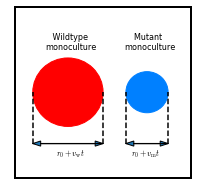

In [542]:
fig, ax = plt.subplots( figsize=(8*ipc, 8*ipc));
ax.set_xticks([]); ax.set_yticks([]);
ax.set_xlim(0,1); ax.set_ylim(0,1);
ax.add_patch(patch.Circle( (0.3,0.5),0.2, color=(1,0,0) ))
ax.add_patch(patch.Circle( (0.75,0.5),0.12, color=(0.,0.5,1.0) ))
ax.plot( np.ones(10)*0.1, np.linspace(0.2,0.5,10), 'k--' );
ax.plot( np.ones(10)*0.5, np.linspace(0.2,0.5,10), 'k--' );
ax.plot( np.ones(10)*0.63, np.linspace(0.2,0.5,10), 'k--' );
ax.plot( np.ones(10)*0.87, np.linspace(0.2,0.5,10), 'k--' );
ax.arrow( 0.1,0.2,0.4,0, length_includes_head=True, head_width=0.03  );
ax.arrow( 0.5,0.2,-0.4,0, length_includes_head=True, head_width=0.03  );
ax.arrow( 0.63,0.2,0.24,0, length_includes_head=True, head_width=0.03  );
ax.arrow( 0.87,0.2,-0.24,0, length_includes_head=True, head_width=0.03  );
ax.text(0.23,0.13,r'$r_0 + v_{\rm w}t$')
ax.text(0.66,0.13,r'$r_0 + v_{\rm m}t$')
ax.text(0.17,0.75,'   Wildtype\nmonoculture')
ax.text(0.62,0.75,'    Mutant\nmonoculture')
fig.savefig('0819_fig3a1.svg',bbox_inches='tight')

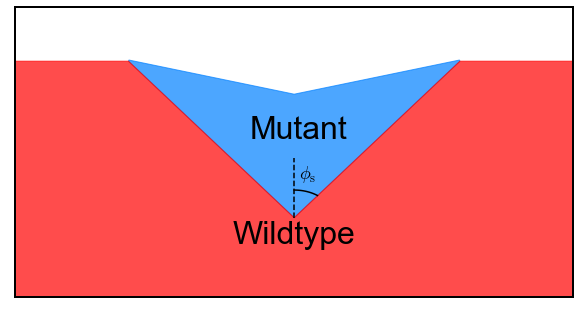

In [323]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-0.5,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),0.5,100);
xyw[400:500,0]=np.ones(100)*0.5; xyw[500:600,0]=np.linspace(0.5,-0.5,100); xyw[600:,0]=np.ones(100)*(-0.5);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(2.5*4,2.5*8/15*4))
ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=0.7) )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.1,r'$\phi_{\rm s}$', fontsize=18)
#ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
#r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
#ys = ys[:95]; xs = xs[:95];
#ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_{\rm d}$', fontsize=16)
ax.text(-0.08,3/15,'Mutant')
ax.text(-0.11,-1/15,'Wildtype')

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.2, 8/15)
ax.set_xticks([]); ax.set_yticks([]);
fig.savefig('1012_fig3a2.png',bbox_inches='tight')

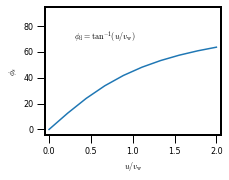

In [30]:
fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0,0])
scale=180;


ax.plot( np.linspace(0,2,10), np.arctan( np.linspace(0,2,10) )*180/np.pi )
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$\phi_s$')
ax.set_xlabel(r'$u/v_{\rm w}$')
ax.set_xlim(-0.05,2.05)
ax.set_ylim(-0.05*90, 1.05*90)
ax.text(0.3,70,r'$\phi_{\rm d} = \tan^{-1}(u/v_{\rm w})$')
 
fig.savefig('0819_fig3a2.svg',bbox_inches='tight')
#sns.kdeplot( v1/v2, shade=True, alpha=0.5);

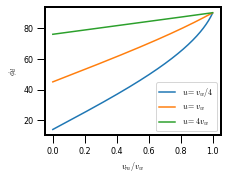

In [31]:
fig, ax = plt.subplots(figsize=(8*ipc,6*ipc))
u=0.1; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(vm/vw, phid(vw,vm,u)/np.pi*180)
u=0.4; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(vm/vw, phid(vw,vm,u)/np.pi*180)
u=1.6; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(vm/vw, phid(vw,vm,u)/np.pi*180)
ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_xlabel(r'$v_m/v_w$')
ax.set_ylabel(r'$\phi_d$')
#ax.set_ylim(0, 0.54)
#ax.set_yticks([np.arctan(1/4)/np.pi, np.arctan(1)/np.pi, np.arctan(4)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\tan^{-1}(1/4)$',r'$\pi/4$',r'$\tan^{-1}(4)$',r'$\pi/2$' ]);
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([45,90 ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, 1]);
fig.savefig('0819_fig3a3.svg',bbox_inches='tight')

### 3B

In [345]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);
for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        #inds2 = np.nonzero( img1[:,j]>0.1 )[0];
        #if( len(inds2)>0 ):
        #    b2[j] = np.max(inds2);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    
    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);


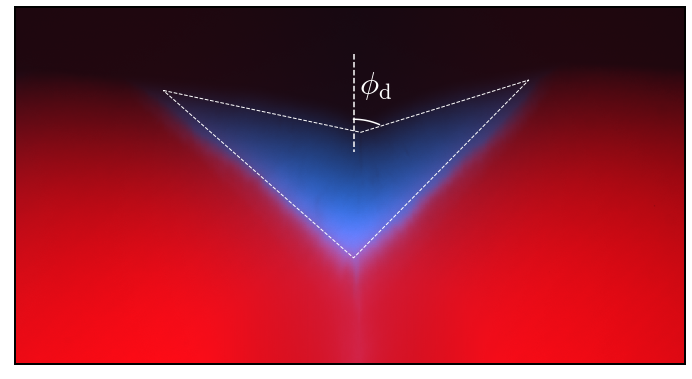

In [333]:

fig, ax = plt.subplots(figsize=(3*4,3*4))
#ax.plot( np.arange(L), b1 );
#ax.plot( np.arange(L), b2 );
#ax.plot( np.arange(L), b3 );
#ax.plot( np.arange(L), b4 );
comp = Colony([dest[i+5],dest[i]], center=False); 
img = comp.Image; #img = np.flip(img, axis=0);
ax.imshow(img);
#ax.imshow(img2, cmap=plt.cm.gray);
pol = np.zeros((5,2)); pol[0]=[xl,yl]; pol[1]=[xu,yu]; pol[2]=[xr,yr]; pol[3]=[xd,yd]; pol[4]=[xl,yl];
ax.add_patch(patch.Polygon(pol, facecolor='none',edgecolor=(1,1,1), linestyle='--') )

#ax.scatter(xl,yl, color='none', edgecolor='yellow');
#ax.scatter(xr,yr, color='none', edgecolor='yellow');
#ax.scatter(xu,yu, color='none', edgecolor='yellow');
#ax.scatter(xd,yd, color='none', edgecolor='yellow');

#ax.plot( np.ones(10)*517, np.linspace(750,900,10), color=(1.,1.,1), linestyle='--')
#r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+910; xs=xs+517;
#ys = ys[:40]; xs = xs[:40];
#ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,790,r'$\phi_{\rm s}$', color=(1,1,1), fontsize=fsz*4)
ax.plot( np.ones(10)*517, np.linspace(550,700,10), color=(1.,1.,1), linestyle='--')
r = 100; xs = np.linspace(0, r, 100); ys=-(r**2-xs**2)**0.5+750; xs=xs+517;
ys = ys[:40]; xs = xs[:40];
ax.plot( xs, ys, color=(1,1,1)  ); ax.text(525,610,r'$\phi_{\rm d}$', color=(1,1,1), fontsize=fsz*4)
#ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
#r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
#ys = ys[:95]; xs = xs[:95];
#ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_{\rm d}$', fontsize=16)
#ax.text(-0.04,3/15,'Mutant')
#ax.text(-0.05,-1/15,'Wildtype')

ax.set_xticks([]); ax.set_yticks([]);
ax.set_ylim(1024,1024*7/15)

fig.savefig('1012_fig3a3.png',bbox_inches='tight')

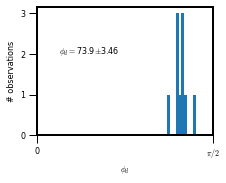

In [552]:


fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)


ax = fig.add_subplot(gs[0,0])
ax.set_xlim(0,np.pi/2)
#ax.set_xticks()
#sns.kdeplot( np.arctan( v2/y ), shade=True, alpha=0.5);
ax.hist(np.arctan( v2/y ));
ax.set_yticks([0,1,2,3]);
ax.set_ylabel('# observations')
ax.set_xlabel(r'$\phi_d$')
ax.set_xticks([0,np.pi/2]);
ax.set_xticklabels([0,r'$\pi/2$']);
ave = np.average( np.arctan( v2/y ) )*180/np.pi; std = np.std(np.arctan( v2/y ))*180/np.pi;
ax.text(0.2,2,r'$\phi_d=$'+str(ave)[:4]+r'$\pm$'+str(std)[:4])
#ax.plot( np.average(s2)*np.ones(2), np.arange(2)*7, '--', color=(1,0.,0.), alpha=0.9 )
#ax.plot( np.average(v1/v2)*np.ones(2), np.arange(2)*7, '--', color=(0.,0.5,1.), alpha=0.9 )
#ax.errorbar( np.average(v1/v2), 4, xerr=np.std(v1/v2), color=(0.,0.5,1.), alpha=0.9 )


fig.savefig('0819_fig3b5.svg',bbox_inches='tight')

In [352]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
rms = np.zeros((2, 6));
rws = np.zeros((2, 6));
ts = np.zeros(6);
for i in np.arange(6):
    t = 0;
    if(i<4):
        for j in np.arange(2):
            dm = dir0+'1015/MONO'+str(j+1)+'/M1_01_'+str(i*2+1)+'.tif';
            dw = dir0+'1015/MONO'+str(j+1)+'/W1_01_'+str(i*2+1)+'.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);  
    elif(i==4):
         for j in np.arange(2):
            dm = dir0+'1016/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1016/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    elif(i==5):
         for j in np.arange(2):
            dm = dir0+'1017/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1017/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    ts[i] = t/4/86400;

In [353]:
xs = ((ts-ts[0])*24)[1:]; print(xs)
ys1 = np.mean(rws*mpx, axis=0)[1:];
es1 = np.std(rws*mpx, axis=0)[1:];
ys2 = np.mean(rms*mpx, axis=0)[1:];
es2 = np.std(rms*mpx, axis=0)[1:];
sol1 = curve_fit(linf, xdata=xs, ydata=ys1, sigma=es1)
sol2 = curve_fit(linf, xdata=xs, ydata=ys2, sigma=es2)
yf1 = xs*sol1[0][0]+sol1[0][1];
yf2 = xs*sol2[0][0]+sol2[0][1];

[ 3.85291667  6.34930556  8.71347222 27.25472222 47.24180556]


In [337]:
ys = (rws[0]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rws[1]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rms[0]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )
ys = (rms[1]*mpx)[1:]; sol= curve_fit(linf, xdata=xs, ydata=ys);
print( sol[0][0] )

0.03391664733751731
0.0340953786268415
0.022492829541889112
0.0222423045526467


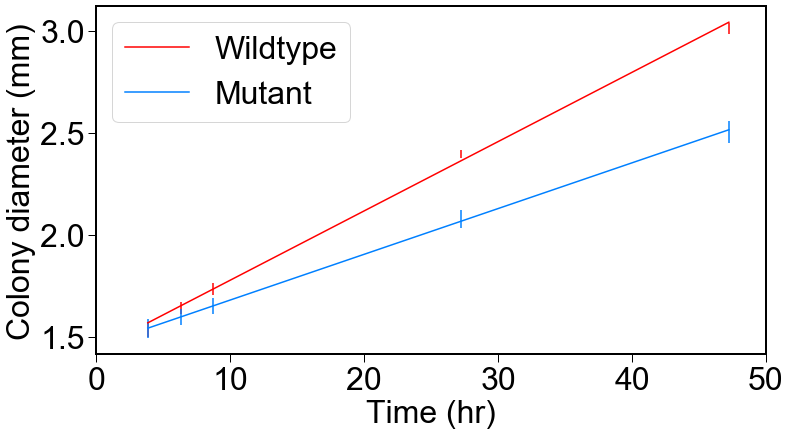

In [342]:
fig, ax = plt.subplots(figsize=(3*4,3*8/15*4))

ax.errorbar(xs, ys1, yerr=es1*2, linestyle='none', color=(1,0,0));
ax.errorbar(xs, ys2, yerr=es2*2, linestyle='none', color=(0,0.5,1));
ax.plot(xs, yf1, color=(1,0,0));
ax.plot(xs, yf2, color=(0,0.5,1));
ax.set_xlim( 0,50 )
ax.set_xlabel('Time (hr)',fontsize=fsz*4)
ax.set_yticks([1.5,2.,2.5,3])
ax.set_ylabel('Colony diameter (mm)',fontsize=fsz*4)
ax.legend(['Wildtype','Mutant'])
#ax.text(xs[0], ys1[3]+0.15, r'$v_{WT}=0.034 mm/hr$' )
#ax.text(20, ys1[1], r'$v_{M}=0.022 mm/hr$' )

fig.savefig('1012_fig3a1.png', bbox_inches='tight')

In [548]:
dest1 = dir0+'1017/COMP01/WM91_1_1.tif';
dest2 = dir0+'1017/COMP01/WM91_2_1.tif';
comp = Colony([dest1,dest2]);
dest = dir0+'1017/MONO1/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO1/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

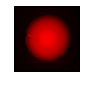

In [549]:
fig, ax = plt.subplots(figsize=(3*ipc,3*ipc));
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( w01.Image)
#ax.add_patch(patch.Circle( (511.5,511.5), m01.R, facecolor='none', edgecolor=(0., 1., 0.), linestyle='--' ))
fig.savefig('0819_fig3b2.svg', bbox_inches='tight')

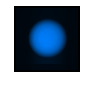

In [550]:
fig, ax = plt.subplots(figsize=(3*ipc,3*ipc));
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( m01.Image)
#ax.add_patch(patch.Circle( (511.5,511.5), w01.R, facecolor='none', edgecolor=(1., 0., 0.), linestyle='--' ))
fig.savefig('0819_fig3b3.svg', bbox_inches='tight')

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

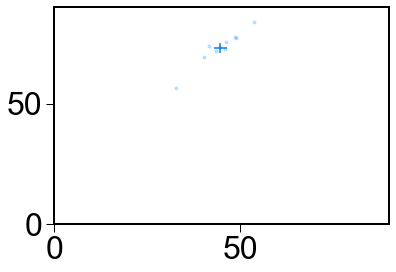

In [346]:
phid_expm4 = np.arctan( u/y )*180/np.pi
phis_expm4 = np.arctan( u/v2)*180/np.pi
plt.scatter(phis_expm4, phid_expm4, color=(0,0.5,1), marker='.', alpha=0.2)
plt.errorbar(np.average(phis_expm4), np.average(phid_expm4), xerr=np.std(phis_expm4)/(10**0.5), yerr=np.std(phid_expm4)/(10**0.5), color=(0,0.5,1))
xs = np.linspace(0,90,100);

plt.xlim(0, 90); plt.ylim(0, 90);
plt.plot( xs, phiphi(xs*np.pi/180, vm_expm1/vw_expm1)/np.pi*180, 'k--', alpha=0.7  )
#plt.legend(['Prediction from monocultures','Measurements from sectors','Measurement average'], loc='lower right')
plt.xlabel(r'$\phi_{\rm s} (^\circ)$')
plt.ylabel(r'$\phi_{\rm d} (^\circ)$')
plt.text(60,70,'Prediction from\nexpansion rates')
plt.text(45,60,'Avereage sector shape', color=(0.,0.5,1))
plt.arrow(55,65,-8,6,color=(0.,0.5,1.))
plt.savefig('0819_fig3c1_v2.svg',bbox_inches='tight')
#sol = curve_fit( phiphi, xdata=phis_expm4, ydata=phid_expm4)
#plt.plot( xs, phiphi(xs, np.average(v1/v2))  )

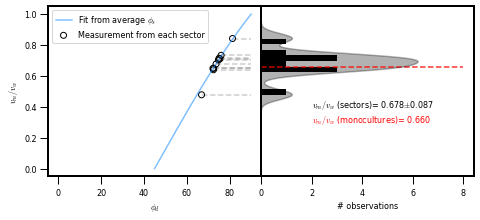

In [14]:
fig = plt.figure(figsize=(15*ipc, 6*ipc))
gs = fig.add_gridspec(1, 2)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$v_m/v_w$')
ax.set_xlabel(r'$\phi_d$')
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05*90, 1.05*90)
ax.scatter( np.arctan( v2/y )/np.pi*scale,v1/v2, color='none', edgecolor='k'  )
ax.plot(phid(vw,vm,u)/np.pi*scale,vm/vw, color=(0,0.5,1), alpha=0.5)
ax.legend(['Fit from average $\phi_s$','Measurement from each sector'])
for i in np.arange(10):
    ax.plot( np.linspace( np.arctan( v2/y )[i]/np.pi*scale, 90,10 ), (v1/v2)[i]*np.ones(10), 'k--', alpha=0.2 )


ax = fig.add_subplot(gs[0,1])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
#
#ax.plot(vm/vw, phid(vw,vm,u)/np.pi*scale)
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
#ax.set_xlabel(r'$v_m/v_w$')
#ax.set_ylabel('# observations')
#ax.set_ylim(0, 0.54)
ax.hist( v1/v2, color=(0,0,0), orientation='horizontal' )
#ax.set_xticks([]);
ax.set_xlabel('# observations')
ax.set_yticks([]);
ax.set_ylim(-0.05,1.05);
#ax.set_yticks([0,1,2,3]);
ax.plot(np.linspace(0.,8,10),np.ones(10)*vm_expm1/vw_expm1,  color=(1,0.,0.), alpha=0.8, linestyle='--' )
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\pi/4$',r'$\pi/2$' ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, r'$v_w$']);
ax.text(2,0.4,r'$v_m/v_w$ (sectors)= '+str(np.average(v1/v2))[:5]+r'$\pm$'+str(np.std(v1/v2))[:5])
ax.text(2,0.3,r'$v_m/v_w$ (monocultures)= '+str(vm_expm1/vw_expm1)[:5], color=(1,0,0))
#ax.text(0.0,3.5,'= '+str(np.average(v1/v2))[:5]+r'$\pm$'+str(np.std(v1/v2))[:5])
sns.kdeplot( v1/v2, shade=True, color=(0,0.,0.), alpha=0.3, vertical=True);
#fig.tight_layout(pad=0.0)
fig.savefig('0819_fig3c1.svg',bbox_inches='tight')

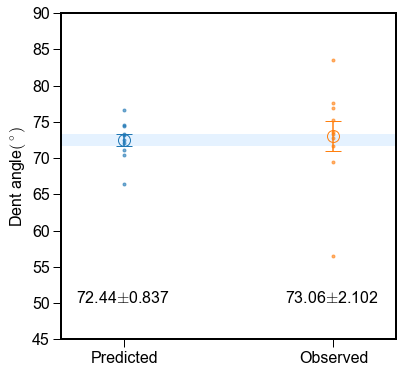

In [376]:
#####
mpl.rcParams['font.size'] = fsz*2;

fig, ax = plt.subplots(1,1,  figsize=(3*2, 3*2) )

s1=phid(1, np.average(vr_expm1), u/v2  )*180/np.pi; s2 = phid_expm4; 
#s1=v1/v2; s2 = vr_expm1; 
ax.scatter(s1*0+1, s1, marker='.', alpha=0.6 );
ax.scatter(s2*0+2, s2, marker='.', alpha=0.6 );
pol = np.zeros((5,2)); pol[0]=[0,np.average(s1)+np.std(s1)/(10**0.5)]; pol[1]=[0,np.average(s1)-np.std(s1)/(10**0.5)]; pol[2]=[3,np.average(s1)-np.std(s1)/(10**0.5)]; pol[3]=[3,np.average(s1)+np.std(s1)/(10**0.5)]; pol[4]=pol[0];
ax.add_patch(patch.Polygon(pol, facecolor=(0,0.5,1), alpha=0.1) )
ax.errorbar(1, np.average(s1), yerr=np.std(s1)/(10**0.5), marker='o', mfc='none', ms=12, capsize=8 );
ax.errorbar(2, np.average(s2), yerr=np.std(s2)/(10**0.5), marker='o', mfc='none', ms=12, capsize=8 );
ax.text(0.77, 50, np.str( np.average(s1) )[:5]+'$\pm$'+np.str( np.std(s1)/(10**0.5) )[:5] )
ax.text(1.77, 50, np.str( np.average(s2) )[:5]+'$\pm$'+np.str( np.std(s2)/(10**0.5) )[:5] )
ax.set_xticks([1,2]);
ax.set_xticklabels(['Predicted','Observed'] ,fontsize=fsz*2)
ax.set_xlim(0.7,2.3)
ax.set_ylim(45,90)
ax.set_ylabel('Dent angle'+r'$(^\circ)$', fontsize=fsz*2)
#ax.set_ylim(0.,1.)
#ax.set_ylabel('$v_m / v_w$')
fig.savefig('1012_fig3b.png',bbox_inches='tight')

In [30]:
# t-test
s1 = phid_expm4; s2=phid(1, vm_expm1/vw_expm1, u/v2  )*180/np.pi;
#s1 = v1/v2; s2=vm_expm1/vw_expm1;
print( ttest_ind(s1,s2, equal_var=False) )

Ttest_indResult(statistic=0.10435887986232603, pvalue=0.9190904803014123)


In [29]:
(np.mean(v1/v2)-s2)/np.std(v1/v2)*(10**0.5)

0.6847325376023746

## Fig. 4

### A

In [11]:
data = np.zeros((4,3,2,8,5));# Day, Replicate, WT/Mut, 8 x5 comp wells
data[0,:,0,:,:2]=9; data[0,:,1,:,:2]=1;
data[0,:,0,:,2]=5; data[0,:,1,:,2]=5;
data[0,:,0,:,3:]=1; data[0,:,1,:,3:]=9;
nreps = [2,3,3];
for day in np.arange(3):
    fname0 = 'D'+str(day+2)+'_DF100'
    nrep = nreps[day];
    for i in np.arange(nrep):
        fname = fname0+'_R'+str(i+1)
        xl = pd.read_excel('../../ColonyCounts/20Mar_DentLiquid/'+fname+'.xlsx',sheet_name='Data');
        wt = np.array(xl['WT'][8:]); wt = wt.reshape((8,5));     
        mut = np.array(xl['M'][8:]); mut = mut.reshape((8,5));
        for j in np.arange(4):
            wt[j*2+1] = np.flip(wt[j*2+1]);
            mut[j*2+1] = np.flip(mut[j*2+1]);
        data[day+1,i,0] = wt; data[day+1,i,1] = mut;
data_DF100 = np.copy(data);


In [12]:
sums = np.sum(data_DF100, axis=1);
fracs = sums[:,1]/(sums[:,0]+sums[:,1])
# fracs[:, i, j]
# i : 0,4 / 1,5 
# j : 0-1 / 2 / 3-4
fracs2 = np.zeros((4,3,2)); 
fracs2[:,0,0] = (fracs[:,0,0] + fracs[:,4,0] + fracs[:,0,1] + fracs[:,4,1] )/4;
fracs2[:,1,0] = (fracs[:,0,2] + fracs[:,4,2] )/2;
fracs2[:,2,0] = (fracs[:,0,3] + fracs[:,4,3] + fracs[:,0,4] + fracs[:,4,4] )/4;
fracs2[:,0,1] = (fracs[:,1,0] + fracs[:,5,0] + fracs[:,1,1] + fracs[:,5,1] )/4;
fracs2[:,1,1] = (fracs[:,1,2] + fracs[:,5,2] )/2;
fracs2[:,2,1] = (fracs[:,1,3] + fracs[:,5,3] + fracs[:,1,4] + fracs[:,5,4] )/4;
fracs_DF100 = np.copy(fracs)

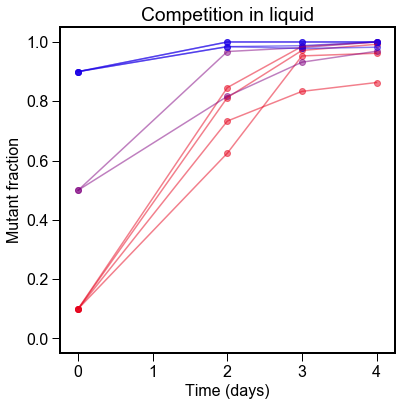

In [19]:
inits = [0.1, 0.1, 0.5, 0.9, 0.9];
mpl.rcParams['font.size'] = fsz*2;
fig, ax = plt.subplots(figsize=(3*2, 3*2  ))
#for i in np.arange(3):
#    for j in np.arange(2):
#        ax.plot( [0,2,3,4], fracs2[:,i,j], color=(0,0.5,1.), marker='o', alpha=0.8 )
cs = [(0.9,0.,0.1), (0.9,0.,0.1), (0.5,0.,0.5), (0.1,0.,0.9), (0.1,0.,0.9)] 
for i in np.arange(5):
    for j in np.arange(2):
        ax.plot( [0,2,3,4], fracs[:,j,i], color=cs[i], alpha=0.5 )
        ax.scatter( [0,2,3,4], fracs[:,j,i], color=cs[i], alpha=0.5, marker='o' )
ax.set_ylim(-0.05,1.05)
ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(['Day 0','Day 1','Day 2', 'Day 3'])
ax.set_xlabel('Time (days)', fontsize=fsz*2)
ax.set_ylabel('Mutant fraction', fontsize=fsz*2)
ax.set_title('Competition in liquid')
#ax.legend(['WT Sc vs M Tq' ,'WT Tq vs M Sc' ])
#ax.set_title('DF 100')
fig.savefig('1012_fig4a1.png',bbox_inches='tight')

### B

In [190]:
cnt_WT={}; cnt_M={};
area_WT={}; area_M={};

In [191]:
xl = pd.read_excel('../../ColonyCounts/20Jul_Biomass/AAM.xlsx',sheet_name='Data');
for i in np.arange(3):
    t = [6,12,24][i];
    cnt_WT[t] = xl['WT'][ xl['T']==t ]*3e6;
    cnt_M[t] = xl['M'][ xl['T']==t ]*3e6;
    dest = dir0+'2020/0704/Circle/A1_T'+str(i+1)+'.tif';
    w01 = Colony([dest]); w01.color(0);
    dest = dir0+'2020/0704/Circle/A2M_T'+str(i+1)+'.tif';
    m01 = Colony([dest]); m01.color(1); 
    img = m01.ImageBW;
    #plt.imshow( img - img*( img > 0.6*np.max(img) )*( img < 0.62*np.max(img) )  )
    area_M[t] = np.sum( img > 0.6*np.max(img) )*(mpx**2);
    img = w01.ImageBW;
    #plt.imshow( img - img*( img > 0.22*np.max(img) )*( img < 0.23*np.max(img) )  )
    area_WT[t] = np.sum( img > 0.22*np.max(img) )*(mpx**2);
cnt_M[24]=cnt_M[24]*10;
cnt_WT[24]=cnt_WT[24]*10;

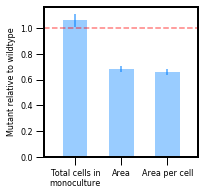

In [239]:
fig, ax = plt.subplots(1,1, figsize=(7*ipc, 7*ipc  ) )
#ax.bar(1, np.average(cnt_M[12]/cnt_WT[12]), color=(0.,0.5,1), alpha=0.6 )
#ax.bar(2, np.average(cnt_M[24]/cnt_WT[24]), color=(0.,0.5,1), alpha=0.6 )
st1 = np.concatenate([cnt_M[12]/cnt_WT[12], cnt_M[24]/cnt_WT[24]]);
ax.bar(1, np.average(st1), color=(0.,0.5,1), alpha=0.4 )
ax.errorbar(1, np.average(st1), yerr=np.std(st1)/(12**0.5), color=(0.,0.5,1),  alpha=0.7 );

#ax.bar(4, np.average(area_M[12]/area_WT[12]), color=(0.,0.5,1), alpha=0.6 )
#ax.bar(5, np.average(area_M[24]/area_WT[24]), color=(0.,0.5,1), alpha=0.6 )
st2 = np.array([area_M[12]/area_WT[12], area_M[24]/area_WT[24]]);
ax.bar(2.5, np.average(st2), color=(0.,0.5,1), alpha=0.4 )
ax.errorbar(2.5, np.average(st2), yerr=np.std(st2)/(2**0.5), color=(0.,0.5,1),  alpha=0.7 );

#ax.bar(7, np.average(area_M[12]/area_WT[12]/(cnt_M[12]/cnt_WT[12])), color=(0.,0.5,1), alpha=0.6 )
#ax.bar(8, np.average(area_M[24]/area_WT[24]/(cnt_M[24]/cnt_WT[24])), color=(0.,0.5,1), alpha=0.6 )
st3 = np.matmul(1/st1.reshape(12,1), st2.reshape(1,2)); 
ax.bar(4, np.average(st3), color=(0.,0.5,1), alpha=0.4 );
ax.errorbar(4, np.average(st3), yerr=np.std(st3)/(24**0.5), color=(0.,0.5,1),  alpha=0.7 );

ax.set_xlim(0,5);
ax.set_xticks([1,2.5,4]);
ax.set_xticklabels(['Total cells in\nmonoculture','Area','Area per cell'])
ax.plot( np.linspace(0,10,10), np.ones(10), color=(1,0,0), linestyle='--', alpha=0.5 )
ax.set_ylabel('Mutant relative to wildtype')
fig.savefig('0819_fig4b.svg',bbox_inches='tight')

# Supplements

In [33]:
dest1 = dir0+'1017/COMP01/WM91_1_1.tif';
dest2 = dir0+'1017/COMP01/WM91_2_1.tif';
comp = Colony([dest1,dest2]);
dest = dir0+'1017/MONO1/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO1/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

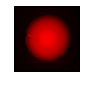

In [34]:
fig, ax = plt.subplots(figsize=(3*ipc,3*ipc));
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( w01.Image)
#ax.add_patch(patch.Circle( (511.5,511.5), m01.R, facecolor='none', edgecolor=(0., 1., 0.), linestyle='--' ))
#fig.savefig('0819_fig3b2.svg', bbox_inches='tight')

# ---Past work

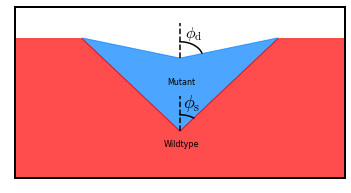

In [10]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-0.5,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),0.5,100);
xyw[400:500,0]=np.ones(100)*0.5; xyw[500:600,0]=np.linspace(0.5,-0.5,100); xyw[600:,0]=np.ones(100)*(-0.5);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(15*ipc,8*ipc))
ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=0.7) )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.1,r'$\phi_{\rm s}$', fontsize=18)
ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
ys = ys[:95]; xs = xs[:95];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_{\rm d}$', fontsize=16)
ax.text(-0.04,3/15,'Mutant')
ax.text(-0.05,-1/15,'Wildtype')

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.2, 8/15)
ax.set_xticks([]); ax.set_yticks([]);
fig.savefig('0813_fig4a1.svg',bbox_inches='tight')

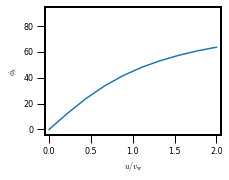

In [11]:
fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0,0])
scale=180;


ax.plot( np.linspace(0,2,10), np.arctan( np.linspace(0,2,10) )*180/np.pi )
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$\phi_s$')
ax.set_xlabel(r'$u/v_{\rm w}$')
ax.set_xlim(-0.05,2.05)
ax.set_ylim(-0.05*90, 1.05*90)
 
fig.savefig('0813_fig4a2.svg',bbox_inches='tight')
#sns.kdeplot( v1/v2, shade=True, alpha=0.5);

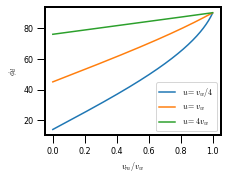

In [12]:
fig, ax = plt.subplots(figsize=(8*ipc,6*ipc))
u=0.1; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(vm/vw, phid(vw,vm,u)/np.pi*180)
u=0.4; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(vm/vw, phid(vw,vm,u)/np.pi*180)
u=1.6; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(vm/vw, phid(vw,vm,u)/np.pi*180)
ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_xlabel(r'$v_m/v_w$')
ax.set_ylabel(r'$\phi_d$')
#ax.set_ylim(0, 0.54)
#ax.set_yticks([np.arctan(1/4)/np.pi, np.arctan(1)/np.pi, np.arctan(4)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\tan^{-1}(1/4)$',r'$\pi/4$',r'$\tan^{-1}(4)$',r'$\pi/2$' ]);
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([45,90 ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, 1]);
fig.savefig('0804_fig4a3.svg',bbox_inches='tight')

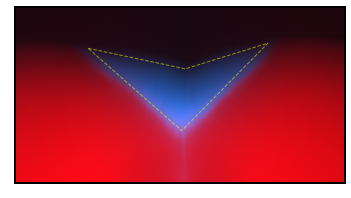

In [13]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);
for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        #inds2 = np.nonzero( img1[:,j]>0.1 )[0];
        #if( len(inds2)>0 ):
        #    b2[j] = np.max(inds2);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    
    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);

fig, ax = plt.subplots(figsize=(15*ipc,15*ipc))
#ax.plot( np.arange(L), b1 );
#ax.plot( np.arange(L), b2 );
#ax.plot( np.arange(L), b3 );
#ax.plot( np.arange(L), b4 );
comp = Colony([dest[i+5],dest[i]], center=False); 
img = comp.Image; #img = np.flip(img, axis=0);
ax.imshow(img);
#ax.imshow(img2, cmap=plt.cm.gray);
pol = np.zeros((5,2)); pol[0]=[xl,yl]; pol[1]=[xu,yu]; pol[2]=[xr,yr]; pol[3]=[xd,yd]; pol[4]=[xl,yl];
ax.add_patch(patch.Polygon(pol, facecolor='none',edgecolor='yellow', linestyle='--', alpha=0.5) )

#ax.scatter(xl,yl, color='none', edgecolor='yellow');
#ax.scatter(xr,yr, color='none', edgecolor='yellow');
#ax.scatter(xu,yu, color='none', edgecolor='yellow');
#ax.scatter(xd,yd, color='none', edgecolor='yellow');

ax.set_xticks([]); ax.set_yticks([]);
ax.set_ylim(1024,1024*7/15)

fig.savefig('0813_fig4b1.svg',bbox_inches='tight')

In [32]:
sol

(array([1.]), array([[5.18618046e-18]]))

# 0714

In [9]:
## 1. Find threshold (relative) FL intensity that would match with the boundary in brightfield image
## The threshold is likely different between two colors.
## 2. Find boundary by tracing gradient from outside.
## Might need coarse graining before gradient computation

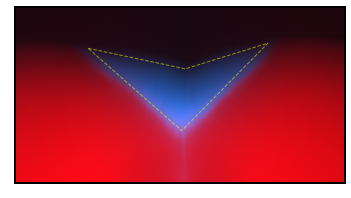

In [10]:
dest={}; L = 1024;
u = np.zeros(10); v1=np.zeros(10); v2=np.zeros(10); y=np.zeros(10);
for i in np.arange(5):
    dest[i] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C2.tif';
    dest[i+5] = dir0+'2020/0704/razor/T4/A1A2M_OD0001/40X/'+str(i+1)+'_C1.tif';
for i in np.arange(5):
    #if(i!=4):continue;
    m01 = Colony([dest[i]], center=False); m01.color(1); 
    img1 = m01.ImageBW; img1=img1-np.min(img1); img1=img1/np.max(img1); #img1 = np.flip(img1, axis=0)
    w01 = Colony([dest[i+5]], center=False); w01.color(0); 
    img2 = w01.ImageBW; img2=img2-np.min(img2); img2=img2/np.max(img2); #img1 = np.flip(img1, axis=0)
    if(i==0):
        img1 = np.flip(img1, axis=0); img1[:,800:]=0;
        img2 = np.flip(img2, axis=0); img2[:,800:]=0;
    if(i==1):
        img1 = np.flip(img1, axis=0);
        img2 = np.flip(img2, axis=0);
    if(i==2):
        img1 = np.flip(img1, axis=0); img1[:,:200]=0;
        img2 = np.flip(img2, axis=0); img2[:,:200]=0;
    #img1 = coarse(img1); L = 512;
    img1[:,0]=0;
#    rz = np.nonzero( np.max(img1, axis=0)>0.2 )[0];
#    img1[:,:rz[0]]=0;
#    img1[:,rz[-1]:]=0;
    #plt.imshow(img1)
    #img2 = img1[1:]-img1[:-1]; img2 = img2-np.min(img2); img2=img2/np.max(img2);
    b1 = np.zeros(L, dtype=int);
    b2 = np.zeros(L, dtype=int);
    b3 = np.zeros(L, dtype=int);
    b4 = np.zeros(L, dtype=int);
    for j in np.arange(L):
        inds1 = np.nonzero( img1[:,j]>0.2 )[0];
        if( len(inds1)>0 ):
            b1[j] = np.min(inds1);
        #inds2 = np.nonzero( img1[:,j]>0.1 )[0];
        #if( len(inds2)>0 ):
        #    b2[j] = np.max(inds2);
        if(i in [0,1,2] ):
            inds3 = np.nonzero( img2[:,j]>0.7 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        else:
            inds3 = np.nonzero( img2[:,j]>0.6 )[0];
            if( len(inds3)>0 ):
                b3[j] = np.min(inds3);
        inds4 = np.nonzero( (img2[:,j]>0.15)*(img1[:,j]>0.1) )[0];
        if( len(inds4)>0 ):
            b4[j] = np.min(inds4);
    xl = np.min( np.nonzero(b1)[0] ); xr = np.max( np.nonzero(b1)[0] );
    yl = b4[xl]; yr=b4[xr]; 
    xu = np.argmax(b1); yu=b1[xu]; 
    xd = np.argmax(b3); yd = b3[xd]; #xd = np.argmax(b2); #yd=b2[xd];
    #xl = np.nonzero(b4)[0][0]; xr = np.nonzero(b4)[0][-1];
    #yl = b4[xl]; yr=b4[xr];

    
    y[i] = yu-yl; v2[i] = yd-yl; u[i] = xd-xl; v1[i] = u[i]*(v2[i]-y[i])/np.sqrt(u[i]**2+y[i]**2);
    y[i+5] = yu-yr; v2[i+5] = yd-yr; u[i+5] = xr-xd; v1[i+5] = u[i+5]*(v2[i+5]-y[i+5])/np.sqrt(u[i+5]**2+y[i+5]**2);
    #y = np.max( [yu-yl,yu-yr] );
    #v2[i] = np.max( [yd-yl,yd-yr] );
    #u[i] = (xr-xl)/2;
    #v1[i] = u[i]*(v2[i]-y)/np.sqrt(u[i]**2+y**2);

fig, ax = plt.subplots(figsize=(15*ipc,15*ipc))
#ax.plot( np.arange(L), b1 );
#ax.plot( np.arange(L), b2 );
#ax.plot( np.arange(L), b3 );
#ax.plot( np.arange(L), b4 );
comp = Colony([dest[i+5],dest[i]], center=False); 
img = comp.Image; #img = np.flip(img, axis=0);
ax.imshow(img);
#ax.imshow(img2, cmap=plt.cm.gray);
pol = np.zeros((5,2)); pol[0]=[xl,yl]; pol[1]=[xu,yu]; pol[2]=[xr,yr]; pol[3]=[xd,yd]; pol[4]=[xl,yl];
ax.add_patch(patch.Polygon(pol, facecolor='none',edgecolor='yellow', linestyle='--', alpha=0.5) )

#ax.scatter(xl,yl, color='none', edgecolor='yellow');
#ax.scatter(xr,yr, color='none', edgecolor='yellow');
#ax.scatter(xu,yu, color='none', edgecolor='yellow');
#ax.scatter(xd,yd, color='none', edgecolor='yellow');

ax.set_xticks([]); ax.set_yticks([]);
ax.set_ylim(1024,1024*7/15)
fig.savefig('0804_fig4b1.svg',bbox_inches='tight')

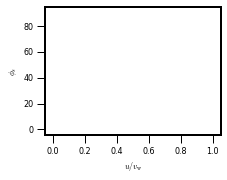

In [59]:
fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0,0])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
ax.plot(phid(vw,vm,u)/np.pi*scale,vm/vw)
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$\phi_s$')
ax.set_xlabel(r'$u/v_{\rm w}$')
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05*90, 1.05*90)
#ax.scatter( np.arctan( v2/y )/np.pi*scale,v1/v2, color='none', edgecolor='k'  )
for i in np.arange(10):
    ax.plot( np.linspace( np.arctan( v2/y )[i]/np.pi*scale, 90,10 ), (v1/v2)[i]*np.ones(10), 'k--', alpha=0.2 )
#ax.plot(np.ones(10)*vm_expm1/vw_expm1, np.linspace(0.25,0.5,10)*scale, linestyle='--' )
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\pi/4$',r'$\pi/2$' ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, r'$v_w$']);
#fig.tight_layout(pad=0.0)
fig.savefig('0813_fig4a2.svg',bbox_inches='tight')
#sns.kdeplot( v1/v2, shade=True, alpha=0.5);

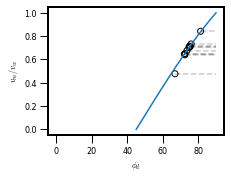

In [60]:
fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0,0])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
ax.plot(phid(vw,vm,u)/np.pi*scale,vm/vw)
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$v_m/v_w$')
ax.set_xlabel(r'$\phi_d$')
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05*90, 1.05*90)
ax.scatter( np.arctan( v2/y )/np.pi*scale,v1/v2, color='none', edgecolor='k'  )
for i in np.arange(10):
    ax.plot( np.linspace( np.arctan( v2/y )[i]/np.pi*scale, 90,10 ), (v1/v2)[i]*np.ones(10), 'k--', alpha=0.2 )
#ax.plot(np.ones(10)*vm_expm1/vw_expm1, np.linspace(0.25,0.5,10)*scale, linestyle='--' )
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\pi/4$',r'$\pi/2$' ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, r'$v_w$']);
#fig.tight_layout(pad=0.0)
fig.savefig('0804_fig4c1.svg',bbox_inches='tight')
#sns.kdeplot( v1/v2, shade=True, alpha=0.5);

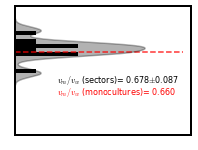

In [134]:
fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0,0])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )

scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
#ax.plot(vm/vw, phid(vw,vm,u)/np.pi*scale)
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
#ax.set_xlabel(r'$v_m/v_w$')
#ax.set_ylabel('# observations')
#ax.set_ylim(0, 0.54)
ax.hist( v1/v2, color=(0,0,0), orientation='horizontal' )
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_ylim(-0.05,1.05);
#ax.set_yticks([0,1,2,3]);
ax.plot(np.linspace(0.,8,10),np.ones(10)*vm_expm1/vw_expm1,  color=(1,0.,0.), alpha=0.8, linestyle='--' )
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\pi/4$',r'$\pi/2$' ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, r'$v_w$']);
ax.text(2,0.4,r'$v_m/v_w$ (sectors)= '+str(np.average(v1/v2))[:5]+r'$\pm$'+str(np.std(v1/v2))[:5])
ax.text(2,0.3,r'$v_m/v_w$ (monocultures)= '+str(vm_expm1/vw_expm1)[:5], color=(1,0,0))
#ax.text(0.0,3.5,'= '+str(np.average(v1/v2))[:5]+r'$\pm$'+str(np.std(v1/v2))[:5])
sns.kdeplot( v1/v2, shade=True, color=(0,0.,0.), alpha=0.3, vertical=True);
#fig.tight_layout(pad=0.0)
fig.savefig('0804_fig4c2.svg',bbox_inches='tight')

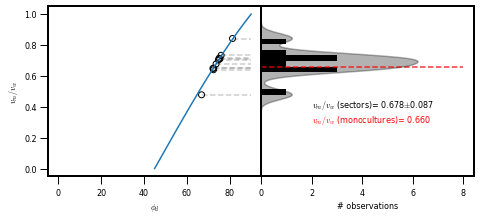

In [143]:
fig = plt.figure(figsize=(15*ipc, 6*ipc))
gs = fig.add_gridspec(1, 2)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
ax.plot(phid(vw,vm,u)/np.pi*scale,vm/vw)
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$v_m/v_w$')
ax.set_xlabel(r'$\phi_d$')
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05*90, 1.05*90)
ax.scatter( np.arctan( v2/y )/np.pi*scale,v1/v2, color='none', edgecolor='k'  )
for i in np.arange(10):
    ax.plot( np.linspace( np.arctan( v2/y )[i]/np.pi*scale, 90,10 ), (v1/v2)[i]*np.ones(10), 'k--', alpha=0.2 )


ax = fig.add_subplot(gs[0,1])
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
scale=180;
u=np.average(u); vw=np.average(v2); vm=np.linspace(0,vw,1000)[:-1];
#
#ax.plot(vm/vw, phid(vw,vm,u)/np.pi*scale)
#ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
#ax.set_xlabel(r'$v_m/v_w$')
#ax.set_ylabel('# observations')
#ax.set_ylim(0, 0.54)
ax.hist( v1/v2, color=(0,0,0), orientation='horizontal' )
#ax.set_xticks([]);
ax.set_xlabel('# observations')
ax.set_yticks([]);
ax.set_ylim(-0.05,1.05);
#ax.set_yticks([0,1,2,3]);
ax.plot(np.linspace(0.,8,10),np.ones(10)*vm_expm1/vw_expm1,  color=(1,0.,0.), alpha=0.8, linestyle='--' )
#ax.set_yticks([np.arctan(1)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\pi/4$',r'$\pi/2$' ]);
#ax.set_xticks([0,1]);
#ax.set_xticklabels([0, r'$v_w$']);
ax.text(2,0.4,r'$v_m/v_w$ (sectors)= '+str(np.average(v1/v2))[:5]+r'$\pm$'+str(np.std(v1/v2))[:5])
ax.text(2,0.3,r'$v_m/v_w$ (monocultures)= '+str(vm_expm1/vw_expm1)[:5], color=(1,0,0))
#ax.text(0.0,3.5,'= '+str(np.average(v1/v2))[:5]+r'$\pm$'+str(np.std(v1/v2))[:5])
sns.kdeplot( v1/v2, shade=True, color=(0,0.,0.), alpha=0.3, vertical=True);
#fig.tight_layout(pad=0.0)
fig.savefig('0804_fig4c12.svg',bbox_inches='tight')

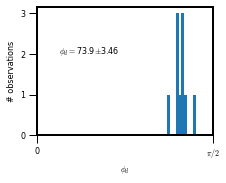

In [313]:


fig = plt.figure(figsize=(8*ipc, 6*ipc))
gs = fig.add_gridspec(1, 1)


ax = fig.add_subplot(gs[0,0])
ax.set_xlim(0,np.pi/2)
#ax.set_xticks()
#sns.kdeplot( np.arctan( v2/y ), shade=True, alpha=0.5);
ax.hist(np.arctan( v2/y ));
ax.set_yticks([0,1,2,3]);
ax.set_ylabel('# observations')
ax.set_xlabel(r'$\phi_d$')
ax.set_xticks([0,np.pi/2]);
ax.set_xticklabels([0,r'$\pi/2$']);
ave = np.average( np.arctan( v2/y ) )*180/np.pi; std = np.std(np.arctan( v2/y ))*180/np.pi;
ax.text(0.2,2,r'$\phi_d=$'+str(ave)[:4]+r'$\pm$'+str(std)[:4])
#ax.plot( np.average(s2)*np.ones(2), np.arange(2)*7, '--', color=(1,0.,0.), alpha=0.9 )
#ax.plot( np.average(v1/v2)*np.ones(2), np.arange(2)*7, '--', color=(0.,0.5,1.), alpha=0.9 )
#ax.errorbar( np.average(v1/v2), 4, xerr=np.std(v1/v2), color=(0.,0.5,1.), alpha=0.9 )


fig.savefig('0804_fig4b2.svg',bbox_inches='tight')

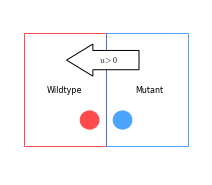

In [118]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;


fig, ax = plt.subplots(figsize=(9*ipc,8*ipc))
#ax.add_patch(patch.Circle([-0.25,4/15],0.15 , color=(1,0,0) ,alpha=0.7 ))
#ax.add_patch(patch.Circle([0.25,4/15],0.1 , color=(0.,0.5,1.) ,alpha=0.7 ))

ax.add_patch(patch.Rectangle( [-0.25,0.1], 0.25, 0.35, facecolor='none' ,edgecolor=(1,0,0) ,alpha=0.7  ))
ax.add_patch(patch.Rectangle( [0.,0.1], 0.25, 0.35, facecolor='none', edgecolor=(0,0.5,1.0) ,alpha=0.7  ))
ax.add_patch(patch.FancyArrow( 0.1,5.5/15,-0.14,0, width=0.06, head_width=0.1, head_length=0.08, facecolor=(1,1,1) ,edgecolor=(0,0.,0) ,alpha=1  ))
ax.add_patch(patch.Circle( [-0.05,2.7/15],radius=0.03, facecolor=(1,0,0) ,alpha=0.7 ))
ax.add_patch(patch.Circle( [0.05,2.7/15],radius=0.03, facecolor=(0,0.5,1.0) ,alpha=0.7 ))

ax.text(-0.18, 4/15, 'Wildtype');
ax.text(0.09, 4/15, 'Mutant');
ax.text(-0.02, 5.4/15, r'$u>0$');

ax.axis('off')

ax.set_xlim(-0.3,0.3)
ax.set_ylim(0, 8/15)
ax.set_xticks([]); ax.set_yticks([]);
fig.savefig('0804_fig5a1.svg',bbox_inches='tight')

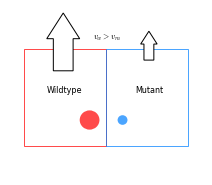

In [117]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;


fig, ax = plt.subplots(figsize=(9*ipc,8*ipc))
#ax.add_patch(patch.Circle([-0.25,4/15],0.15 , color=(1,0,0) ,alpha=0.7 ))
#ax.add_patch(patch.Circle([0.25,4/15],0.1 , color=(0.,0.5,1.) ,alpha=0.7 ))

#ax.add_patch(patch.Rectangle( [-0.25,0.1], 0.25, 0.3, color=(1,0,0) ,alpha=0.7  ))
#ax.add_patch(patch.Rectangle( [0.,0.1], 0.25, 0.3, color=(0,0.5,1.0) ,alpha=0.7  ))
ax.add_patch(patch.Rectangle( [-0.25,0.1], 0.25, 0.3, facecolor='none' ,edgecolor=(1,0,0) ,alpha=0.7  ))
ax.add_patch(patch.Rectangle( [0.,0.1], 0.25, 0.3, facecolor='none', edgecolor=(0,0.5,1.0) ,alpha=0.7  ))
ax.add_patch(patch.FancyArrow( -0.13,5./15,0,0.1, width=0.06, head_width=0.1, head_length=0.08, facecolor=(1,1,1) ,edgecolor=(0,0.,0) ,alpha=1  ))
ax.add_patch(patch.FancyArrow( 0.13,5.5/15,0,0.05, width=0.03, head_width=0.05, head_length=0.04, facecolor=(1,1,1) ,edgecolor=(0,0.,0) ,alpha=1  ))
#ax.add_patch(patch.FancyArrow( 0.1,5.5/15,-0.14,0, width=0.06, head_width=0.1, head_length=0.08, facecolor=(1,1,1) ,edgecolor=(0,0.,0) ,alpha=1  ))
ax.add_patch(patch.Circle( [-0.05,2.7/15],radius=0.03, facecolor=(1,0,0) ,alpha=0.7 ))
ax.add_patch(patch.Circle( [0.05,2.7/15],radius=0.015, facecolor=(0,0.5,1.0) ,alpha=0.7 ))
ax.text(-0.18, 4./15, 'Wildtype');
ax.text(0.09, 4./15, 'Mutant');
ax.text(-0.04, 6.5/15, r'$v_w>v_m$');

ax.axis('off')

ax.set_xlim(-0.3,0.3)
ax.set_ylim(0, 8/15)
ax.set_xticks([]); ax.set_yticks([]);
fig.savefig('0804_fig5b1.svg',bbox_inches='tight')

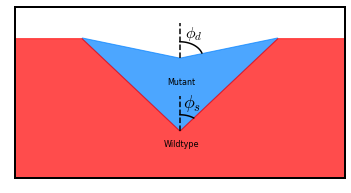

In [116]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xyw = np.zeros((700,2));
xyw[:100,0]=np.linspace(-0.5,-np.max(xb),100); xyw[100:200,0]=np.linspace(-np.max(xb),0,100);
xyw[200:300,0]=np.linspace(0,np.max(xb),100); xyw[300:400,0]=np.linspace(np.max(xb),0.5,100);
xyw[400:500,0]=np.ones(100)*0.5; xyw[500:600,0]=np.linspace(0.5,-0.5,100); xyw[600:,0]=np.ones(100)*(-0.5);

xyw[:100,1]=np.ones(100)*np.max(yb); xyw[100:200,1]=np.linspace(np.max(yb),0,100);
xyw[200:300,1]=np.linspace(0, np.max(yb),100); xyw[300:400,1]=np.ones(100)*np.max(yb);
xyw[400:500,1]=np.linspace(np.max(yb),-1,100); xyw[500:600,1]=np.ones(100)*(-1); xyw[600:,1]=np.linspace(-1,np.max(yb),100);


fig, ax = plt.subplots(figsize=(15*ipc,8*ipc))
ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=0.7) )
ax.add_patch(patch.Polygon(xyw, color=(1.0,0.,0.), alpha=0.7) )
#ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=1) )
ax.plot( np.ones(10)*0, np.linspace(0,0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5;
ys = ys[:60]; xs = xs[:60];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.009,0.1,r'$\phi_s$', fontsize=18)
ax.plot( np.ones(10)*0, np.linspace(np.min(yps[xps>0]),np.min(yps[xps>0])+0.15,10), color=(0.,0.,0), linestyle='--' )
r = 0.07; xs = np.linspace(0, r, 100); ys=(r**2-xs**2)**0.5+np.min(yps[xps>0]);
ys = ys[:95]; xs = xs[:95];
ax.plot( xs, ys, color=(0,0,0)  ); ax.text(0.015,0.4,r'$\phi_d$', fontsize=16)
ax.text(-0.04,3/15,'Mutant')
ax.text(-0.05,-1/15,'Wildtype')

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.2, 8/15)
ax.set_xticks([]); ax.set_yticks([]);
fig.savefig('0804_fig4a3.svg',bbox_inches='tight')

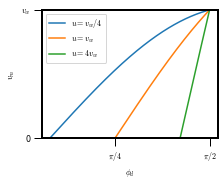

In [70]:
fig, ax = plt.subplots(figsize=(8*ipc,6*ipc))
def phid(vw,vm,u):
    y = (u**2+vw**2-vm**2)**0.5;
    return np.arctan(  (u*y+vw*vm)/( vw*y-u*vm ) )
u=0.1; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(phid(vw,vm,u)/np.pi,vm/vw)
u=0.4; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(phid(vw,vm,u)/np.pi,vm/vw)
u=1.6; vw=0.4; vm=np.linspace(0,vw,1000)[:-1];
ax.plot(phid(vw,vm,u)/np.pi,vm/vw)
ax.legend([r'$u=v_w/4$',r'$u=v_w$',r'$u=4 v_w$'])
ax.set_ylabel(r'$v_m$')
ax.set_xlabel(r'$\phi_d$')
ax.set_ylim(0, 0.54)
#ax.set_yticks([np.arctan(1/4)/np.pi, np.arctan(1)/np.pi, np.arctan(4)/np.pi, 0.5]);
#ax.set_yticklabels([r'$\tan^{-1}(1/4)$',r'$\pi/4$',r'$\tan^{-1}(4)$',r'$\pi/2$' ]);
ax.set_xticks([np.arctan(1)/np.pi, 0.5]);
ax.set_xticklabels([r'$\pi/4$',r'$\pi/2$' ]);
ax.set_yticks([0,1]);
ax.set_yticklabels([0, r'$v_w$']);
fig.savefig('0804_fig4a4.svg',bbox_inches='tight')

In [11]:
def linf2(x,a):
    return x*a;
s1, s1s = curve_fit(linf2, xdata=v2, ydata=v1);
s2, s2s = curve_fit(linf2, xdata=ys1-ys1[0], ydata=ys2-ys2[0]);
s1 = np.average(v1/v2); s1s=np.std(v1/v2);

NameError: name 'ys1' is not defined

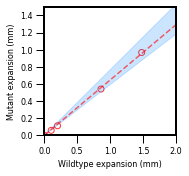

In [16]:
#plt.scatter(v2*mpx,v1*mpx)
fig, ax = plt.subplots(figsize=(6*ipc, 6*ipc  ))
ax.scatter(ys1-ys1[0],ys2-ys2[0], color='none', edgecolor=(1.0,0.,0.), alpha=0.8)
sz=2;
ax.set_xlim(0,sz)
ax.set_ylim(0,1.5)
shade = np.zeros((4,2)); shade[1]=[sz,sz*(s1+s1s)];  shade[2]=[sz,sz*(s1-s1s)]; 
ax.add_patch(patch.Polygon(shade, color=(0.,0.5,1.), alpha=0.2) )
#plt.xlim(0,400)
#plt.ylim(0,300)
ax.plot( np.arange(2)*sz, s2*np.arange(2)*sz, linestyle='--', color=(1.,0.,0.), alpha=0.6 )
ax.set_xlabel('Wildtype expansion (mm)')
ax.set_ylabel('Mutant expansion (mm)')
#plt.plot( np.arange(400), s2*np.arange(400), linestyle='--', color=(1,0.,0.) )
fig.savefig('0721_fig4d.svg', bbox_inches='tight')

In [41]:
sns.kdeplot?

NameError: name 's2' is not defined

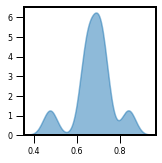

In [12]:
f = plt.figure(figsize=(6*ipc, 6*ipc))
gs = f.add_gridspec(1, 1)


ax = f.add_subplot(gs[0,0])
sns.kdeplot( v1/v2, shade=True, alpha=0.5);
ax.plot( np.average(s2)*np.ones(2), np.arange(2)*7, '--', color=(1,0.,0.), alpha=0.9 )
ax.plot( np.average(v1/v2)*np.ones(2), np.arange(2)*7, '--', color=(0.,0.5,1.), alpha=0.9 )
#ax.errorbar( np.average(v1/v2), 4, xerr=np.std(v1/v2), color=(0.,0.5,1.), alpha=0.9 )



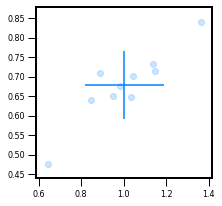

In [18]:
#ax.scatter(0.98, s2, color=(1,0,0), alpha=0.6)
#ax.plot( np.linspace(0.99,1.01,3), s2*np.ones(3), 'k--' )
#ax.text(1.005,0.99, 'Wildtype' )
#fig.savefig('0706_fig4b.png', bbox_inches='tight')
fig, ax = plt.subplots(figsize = (8*ipc,8*ipc) )


ax.scatter(u/v2, v1/v2, color=(0,0.5,1), alpha=0.2)
ax.errorbar( np.average(u/v2), np.average(v1/v2), xerr=np.std(u/v2), yerr=np.std(v1/v2), color = (0,0.5,1) )

#ax.scatter(uv2, v1v2)
fig.savefig('0721_fig4c.svg', bbox_inches='tight')

Text(1.005, 0.678908237471133, '0.67+-0.08')

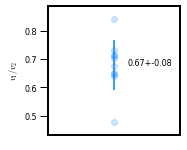

In [553]:
fig, ax = plt.subplots(1,1, figsize=(6*ipc, 6*ipc  ) )
ax.set_xticks([]);
ax.scatter(np.ones(10), v1/v2, color=(0,0.5,1), alpha=0.2)
ax.errorbar( 1, np.average(v1/v2), np.std(v1/v2), color = (0,0.5,1) )
#ax.scatter(0.98, s2, color=(1,0,0), alpha=0.6)
#ax.plot( np.linspace(0.99,1.01,3), s2*np.ones(3), 'k--' )
txt = str(np.average(v1/v2))[:4] + '+-' + str(np.std(v1/v2))[:4]
ax.set_ylabel(r'$v_1/v_2$')
ax.text(1.005,np.average(v1/v2), txt )
#ax.text(1.005,0.99, 'Wildtype' )
#fig.savefig('0706_fig4b.png', bbox_inches='tight')

## cell-cell distance

In [42]:
cnt_WT={}; cnt_M={};
area_WT={}; area_M={};

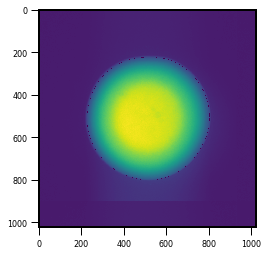

In [43]:
xl = pd.read_excel('../../ColonyCounts/20Jul_Biomass/AAM.xlsx',sheet_name='Data');
for i in np.arange(3):
    t = [6,12,24][i];
    cnt_WT[t] = xl['WT'][ xl['T']==t ]*3e6;
    cnt_M[t] = xl['M'][ xl['T']==t ]*3e6;
    dest = dir0+'2020/0704/Circle/A1_T'+str(i+1)+'.tif';
    w01 = Colony([dest]); w01.color(0);
    dest = dir0+'2020/0704/Circle/A2M_T'+str(i+1)+'.tif';
    m01 = Colony([dest]); m01.color(1); 
    img = m01.ImageBW;
    plt.imshow( img - img*( img > 0.6*np.max(img) )*( img < 0.62*np.max(img) )  )
    area_M[t] = np.sum( img > 0.6*np.max(img) )*(mpx**2);
    img = w01.ImageBW;
    plt.imshow( img - img*( img > 0.22*np.max(img) )*( img < 0.23*np.max(img) )  )
    area_WT[t] = np.sum( img > 0.22*np.max(img) )*(mpx**2);
cnt_M[24]=cnt_M[24]*10;
cnt_WT[24]=cnt_WT[24]*10;

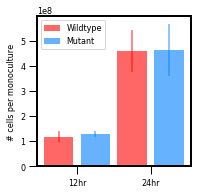

In [371]:
fig, ax = plt.subplots(1,1, figsize=(7*ipc, 7*ipc  ) )
ax.bar( 1, np.average(cnt_WT[12]), color=(1,0,0), alpha=0.6 );
ax.bar( 2, np.average(cnt_M[12]), color=(0,0.5,1.0), alpha=0.6 );
ax.errorbar( 1, np.average(cnt_WT[12]), np.std(cnt_WT[12]), color=(1,0,0), alpha=0.6 );
ax.errorbar( 2, np.average(cnt_M[12]), np.std(cnt_M[12]), color=(0,0.5,1.0), alpha=0.6 );
ax.bar( 3, np.average(cnt_WT[24]), color=(1,0,0), alpha=0.6 );
ax.bar( 4, np.average(cnt_M[24]), color=(0,0.5,1.0), alpha=0.6 );
ax.errorbar( 3, np.average(cnt_WT[24]), np.std(cnt_WT[24]), color=(1,0,0), alpha=0.6 );
ax.errorbar( 4, np.average(cnt_M[24]), np.std(cnt_M[24]), color=(0,0.5,1.0), alpha=0.6 );
ax.legend(['Wildtype','Mutant'], loc='upper left')
ax.set_ylabel('# cells per monoculture')
ax.set_xticks([1.5,3.5]);
ax.set_xticklabels(['12hr','24hr'])
fig.savefig('0804_fig5b2.svg', bbox_inches='tight')

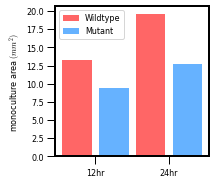

In [373]:
fig, ax = plt.subplots(1,1, figsize=(7*ipc, 7*ipc  ) )
ax.bar( 1, np.average(area_WT[12]), color=(1,0,0), alpha=0.6 );
ax.bar( 2, np.average(area_M[12]), color=(0,0.5,1.0), alpha=0.6 );
ax.errorbar( 1, np.average(area_WT[12]), np.std(area_WT[12]), color=(1,0,0), alpha=0.6 );
ax.errorbar( 2, np.average(area_M[12]), np.std(area_M[12]), color=(0,0.5,1.0), alpha=0.6 );
ax.bar( 3, np.average(area_WT[24]), color=(1,0,0), alpha=0.6 );
ax.bar( 4, np.average(area_M[24]), color=(0,0.5,1.0), alpha=0.6 );
ax.errorbar( 3, np.average(area_WT[24]), np.std(area_WT[24]), color=(1,0,0), alpha=0.6 );
ax.errorbar( 4, np.average(area_M[24]), np.std(area_M[24]), color=(0,0.5,1.0), alpha=0.6 );
ax.legend(['Wildtype','Mutant'], loc='upper left')
ax.set_ylabel('monoculture area $(mm^2)$')
ax.set_xticks([1.5,3.5]);
ax.set_xticklabels(['12hr','24hr'])
fig.savefig('0804_fig5b3.svg', bbox_inches='tight')

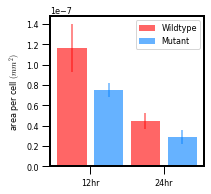

In [48]:
fig, ax = plt.subplots(1,1, figsize=(7*ipc, 7*ipc  ) )
ax.bar( 1, np.average(area_WT[12]/cnt_WT[12]), color=(1,0,0), alpha=0.6 );
ax.bar( 2, np.average(area_M[12]/cnt_M[12]), color=(0,0.5,1.0), alpha=0.6 );
ax.errorbar( 1, np.average(area_WT[12]/cnt_WT[12]), np.std(area_WT[12]/cnt_WT[12]), color=(1,0,0), alpha=0.6 );
ax.errorbar( 2, np.average(area_M[12]/cnt_M[12]), np.std(area_M[12]/cnt_M[12]), color=(0,0.5,1.0), alpha=0.6 );
ax.bar( 3, np.average(area_WT[24]/cnt_WT[24]), color=(1,0,0), alpha=0.6 );
ax.bar( 4, np.average(area_M[24]/cnt_M[24]), color=(0,0.5,1.0), alpha=0.6 );
ax.errorbar( 3, np.average(area_WT[24]/cnt_WT[24]), np.std(area_WT[24]/cnt_WT[24]), color=(1,0,0), alpha=0.6 );
ax.errorbar( 4, np.average(area_M[24]/cnt_M[24]), np.std(area_M[24]/cnt_M[24]), color=(0,0.5,1.0), alpha=0.6 );
ax.legend(['Wildtype','Mutant'], loc='upper right')
ax.set_ylabel('area per cell $(mm^2)$')
ax.set_xticks([1.5,3.5]);
ax.set_xticklabels(['12hr','24hr'])
fig.savefig('0804_fig5b4.svg', bbox_inches='tight')

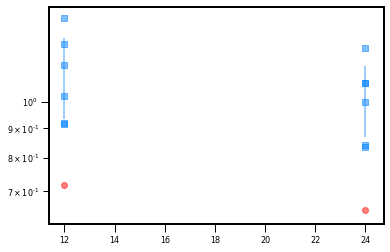

In [337]:
fig, ax = plt.subplots()
for t in [12,24]:
    #ax.scatter(t, area_WT[t], color=(1,0,0) );
    #ax.scatter(t, area_M[t], color=(0.,0.5,1) );
    #ax.errorbar(1, np.average(cnt_WT[t]), yerr=np.std(cnt_WT[t]), color=(1,0,0), alpha=0.5 );
    #ax.errorbar(2, np.average(cnt_M[t]), yerr=np.std(cnt_M[t]), color=(0.,0.5,1.0), alpha=0.5 );
    ax.errorbar(t, np.average(cnt_M[t]/(cnt_WT[t])), yerr=np.std(cnt_M[t]/(cnt_WT[t])), color=(0.,0.5,1.0), alpha=0.5 );
    ax.errorbar(t, np.average(area_M[t]/(area_WT[t])), yerr=np.std(area_M[t]/(area_WT[t])), color=(1,0,0), alpha=0.5 );
    #ax.scatter(1*np.ones(6), cnt_WT[t], color=(1,0,0), alpha=0.5 );
    #ax.scatter(2*np.ones(6), cnt_M[t], color=(0.,0.5,1.0), alpha=0.5 );
    ax.scatter(t*np.ones(6), cnt_M[t]/(cnt_WT[t]), marker='s', color=(0.,0.5,1.0), alpha=0.5 );
    ax.scatter(t*np.ones(1), area_M[t]/(area_WT[t]), color=(1,0,0), alpha=0.5 );
    #ax.scatter(t, area_WT[t]/np.average(cnt_WT[t]), marker='*', color=(1,0,0) );
    #ax.scatter(t, area_M[t]/np.average(cnt_M[t]), marker='*', color=(0.,0.5,1) );
ax.set_yscale('log')
#ax.set_ylim(0.01,300)

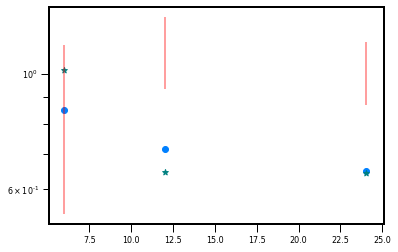

In [81]:
fig, ax = plt.subplots()
for t in [6,12,24]:
    ax.scatter(t, area_M[t]/area_WT[t], color=(0.,0.5,1) );
    ax.errorbar(t, np.average(cnt_M[t]/cnt_WT[t]), yerr=np.std(cnt_M[t]/cnt_WT[t]), color=(1,0,0), alpha=0.5 );
    ax.scatter(t, (area_M[t]/area_WT[t])/np.average(cnt_M[t]/cnt_WT[t]), marker='*', color=(0.,0.5,0.5) )
ax.set_yscale('log')

In [593]:
a2af = a2a[1:].flatten()


In [594]:
c2cf = a2af**0.5;

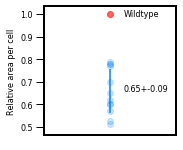

In [597]:
fig, ax = plt.subplots(1,1, figsize=(6*ipc, 6*ipc  ) )
ax.set_xticks([]);
ax.scatter(np.ones(12), a2af, color=(0,0.5,1), alpha=0.2)
ax.errorbar( 1, np.average(a2af), np.std(a2af), color = (0,0.5,1) )
ax.scatter(1, 1, color=(1,0,0), alpha=0.6)
txt = str(np.average(a2af))[:4] + '+-' + str(np.std(a2af))[:4]
ax.set_ylabel('Relative area per cell')
ax.text(1.005,np.average(a2af), txt )
ax.text(1.005,0.99, 'Wildtype' )
fig.savefig('0721_fig5d.svg', bbox_inches='tight')

In [14]:
data = np.zeros((4,3,2,8,5));# Day, Replicate, WT/Mut, 8 x5 comp wells
data[0,:,0,:,:2]=9; data[0,:,1,:,:2]=1;
data[0,:,0,:,2]=5; data[0,:,1,:,2]=5;
data[0,:,0,:,3:]=1; data[0,:,1,:,3:]=9;
nreps = [2,3,3];
for day in np.arange(3):
    fname0 = 'D'+str(day+2)+'_DF100'
    nrep = nreps[day];
    for i in np.arange(nrep):
        fname = fname0+'_R'+str(i+1)
        xl = pd.read_excel('../../ColonyCounts/20Mar_DentLiquid/'+fname+'.xlsx',sheet_name='Data');
        wt = np.array(xl['WT'][8:]); wt = wt.reshape((8,5));     
        mut = np.array(xl['M'][8:]); mut = mut.reshape((8,5));
        for j in np.arange(4):
            wt[j*2+1] = np.flip(wt[j*2+1]);
            mut[j*2+1] = np.flip(mut[j*2+1]);
        data[day+1,i,0] = wt; data[day+1,i,1] = mut;
data_DF100 = np.copy(data);


In [15]:
sums = np.sum(data_DF100, axis=1);
fracs = sums[:,1]/(sums[:,0]+sums[:,1])
# fracs[:, i, j]
# i : 0,4 / 1,5 
# j : 0-1 / 2 / 3-4
fracs2 = np.zeros((4,3,2)); 
fracs2[:,0,0] = (fracs[:,0,0] + fracs[:,4,0] + fracs[:,0,1] + fracs[:,4,1] )/4;
fracs2[:,1,0] = (fracs[:,0,2] + fracs[:,4,2] )/2;
fracs2[:,2,0] = (fracs[:,0,3] + fracs[:,4,3] + fracs[:,0,4] + fracs[:,4,4] )/4;
fracs2[:,0,1] = (fracs[:,1,0] + fracs[:,5,0] + fracs[:,1,1] + fracs[:,5,1] )/4;
fracs2[:,1,1] = (fracs[:,1,2] + fracs[:,5,2] )/2;
fracs2[:,2,1] = (fracs[:,1,3] + fracs[:,5,3] + fracs[:,1,4] + fracs[:,5,4] )/4;
fracs_DF100 = np.copy(fracs)

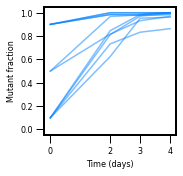

In [16]:
inits = [0.1, 0.1, 0.5, 0.9, 0.9];
fig, ax = plt.subplots(figsize=(6*ipc, 6*ipc  ))
#for i in np.arange(3):
#    for j in np.arange(2):
#        ax.plot( [0,2,3,4], fracs2[:,i,j], color=(0,0.5,1.), marker='o', alpha=0.8 )
for i in np.arange(5):
    for j in np.arange(2):
        ax.plot( [0,2,3,4], fracs[:,j,i], color=(0,0.5,1.), alpha=0.5 )
ax.set_ylim(-0.05,1.05)
ax.set_xticks([0,2,3,4])
#ax.set_xticklabels(['Day 0','Day 1','Day 2', 'Day 3'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Mutant fraction')
#ax.legend(['WT Sc vs M Tq' ,'WT Tq vs M Sc' ])
#ax.set_title('DF 100')
fig.savefig('0804_fig5a2.svg',bbox_inches='tight')

C:\Users\Hyun\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Text(0, 0.5, 'Mutant fraction')

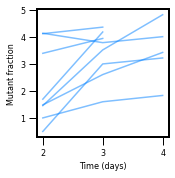

In [20]:
# selective advantage: time series of ln(  f / (1-f) )

inits = [0.1, 0.1, 0.5, 0.9, 0.9];
fig, ax = plt.subplots(figsize=(6*ipc, 6*ipc  ))
#for i in np.arange(3):
#    for j in np.arange(2):
#        ax.plot( [0,2,3,4], fracs2[:,i,j], color=(0,0.5,1.), marker='o', alpha=0.8 )
for i in np.arange(5):
    for j in np.arange(2):
        ax.plot( [2,3,4], np.log( fracs[1:,j,i]/ ( 1 - fracs[1:,j,i] ) ) , color=(0,0.5,1.), alpha=0.5 )
#ax.set_ylim(-0.05,1.05)
ax.set_xticks([2,3,4])
#ax.set_xticklabels(['Day 0','Day 1','Day 2', 'Day 3'])
ax.set_xlabel('Time (days)')
ax.set_ylabel('Mutant fraction')
#ax.legend(['WT Sc vs M Tq' ,'WT Tq vs M Sc' ])
#ax.set_title('DF 100')
#fig.savefig('0721_fig5c.svg',bbox_inches='tight')

# 0629

## Fig. 1: Mutant expands slower, but wins in a competition
### 1a: monoculture images
### 1b: coculture images (1017\comp1)

In [64]:
dest1 = dir0+'1017/COMP01/WM91_1_1.tif';
dest2 = dir0+'1017/COMP01/WM91_2_1.tif';
comp = Colony([dest1,dest2]);
dest = dir0+'1017/MONO1/M1_01_1.tif';
m01 = Colony([dest]); m01.color(1); 
dest = dir0+'1017/MONO1/W1_01_1.tif';
w01 = Colony([dest]); w01.color(0);

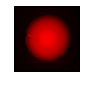

In [63]:
fig, ax = plt.subplots(figsize=(3*ipc,3*ipc));
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( w01.Image)
#ax.add_patch(patch.Circle( (511.5,511.5), m01.R, facecolor='none', edgecolor=(0., 1., 0.), linestyle='--' ))
fig.savefig('0630_fig1a1.svg', bbox_inches='tight')

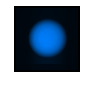

In [65]:
fig, ax = plt.subplots(figsize=(3*ipc,3*ipc));
ax.set_xticks([]); ax.set_yticks([]);
ax.imshow( m01.Image)
#ax.add_patch(patch.Circle( (511.5,511.5), w01.R, facecolor='none', edgecolor=(1., 0., 0.), linestyle='--' ))
fig.savefig('0630_fig1a2.svg', bbox_inches='tight')

### 1b+: time series (1015 - 1017)

In [200]:
## Use MONO1
## 1015: 1~8
## 1016: 1~2
## 1017: 1~2
rms = np.zeros((2, 6));
rws = np.zeros((2, 6));
ts = np.zeros(6);
for i in np.arange(6):
    t = 0;
    if(i<4):
        for j in np.arange(2):
            dm = dir0+'1015/MONO'+str(j+1)+'/M1_01_'+str(i*2+1)+'.tif';
            dw = dir0+'1015/MONO'+str(j+1)+'/W1_01_'+str(i*2+1)+'.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);  
    elif(i==4):
         for j in np.arange(2):
            dm = dir0+'1016/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1016/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    elif(i==5):
         for j in np.arange(2):
            dm = dir0+'1017/MONO'+str(j+1)+'/M1_01_1.tif';
            dw = dir0+'1017/MONO'+str(j+1)+'/W1_01_1.tif';
            m = Colony([dm]); rms[j,i]=m.R; t+= os.path.getmtime(dm); 
            w = Colony([dw]); rws[j,i]=w.R; t+= os.path.getmtime(dw);
    ts[i] = t/4/86400;

In [201]:
rms

array([[577.72985807, 180.38456557, 186.65894975, 192.85218101,
        242.66121271, 292.51420854],
       [577.72985807, 174.9378958 , 182.04536657, 188.25341826,
        237.51778407, 286.2538048 ]])

In [202]:
xs = ((ts-ts[0])*24)[1:];
ys1 = np.mean(rws*mpx, axis=0)[1:];
es1 = np.std(rws*mpx, axis=0)[1:];
ys2 = np.mean(rms*mpx, axis=0)[1:];
es2 = np.std(rms*mpx, axis=0)[1:];
sol1 = curve_fit(linf, xdata=xs, ydata=ys1, sigma=es1)
sol2 = curve_fit(linf, xdata=xs, ydata=ys2, sigma=es2)
yf1 = xs*sol1[0][0]+sol1[0][1];
yf2 = xs*sol2[0][0]+sol2[0][1];

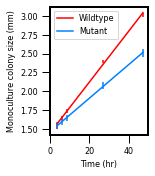

In [203]:
fig, ax = plt.subplots(figsize=(4.5*ipc,6*ipc))

ax.errorbar(xs, ys1, yerr=es1*2, linestyle='none', color=(1,0,0));
ax.errorbar(xs, ys2, yerr=es2*2, linestyle='none', color=(0,0.5,1));
ax.plot(xs, yf1, color=(1,0,0));
ax.plot(xs, yf2, color=(0,0.5,1));
ax.set_xlim( 0,50 )
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Monoculture colony size (mm)')
ax.legend(['Wildtype','Mutant'])
#ax.text(xs[0], ys1[3]+0.15, r'$v_{WT}=0.034 mm/hr$' )
#ax.text(20, ys1[1], r'$v_{M}=0.022 mm/hr$' )

#fig.savefig('0630_fig1a0.svg', bbox_inches='tight')

In [66]:
str1 = ['01','001','0001'];
str2 = ['WM91','WM11','WM19'];
comps = np.zeros([3,3,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(3):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

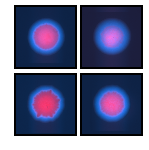

In [301]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'wspace':0.,'hspace':0.1}, figsize=(6*ipc,6*ipc) );
for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].imshow(comps[i*2,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('0630_fig1b.svg', bbox_inches='tight')

## Fig. 2 : Geometric framework

In [307]:
str1 = ['01','001','0001'];
str2 = ['WM991','WM91'];
comps = np.zeros([3,2,1024,1024,3]);
for i in np.arange(3):
    for j in np.arange(2):
        dest = dir0+'1017/COMP';
        dest = dest + str1[i] + '/' + str2[j];
        comps[i,j] = Colony([dest+'_1_1.tif',dest+'_2_1.tif']).Image;

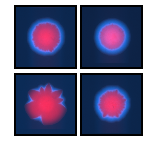

In [309]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'wspace':0.,'hspace':0.1}, figsize=(6*ipc,6*ipc) );
for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].imshow(comps[i*2,j]);
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
fig.savefig('0630_fig2a1.svg', bbox_inches='tight')

In [199]:
dest = '../../../../Dropbox (MIT)/MRE_photos/photos/0924/M2/B2.tif';
w01 = Colony([dest], center=False); w01.color(0);

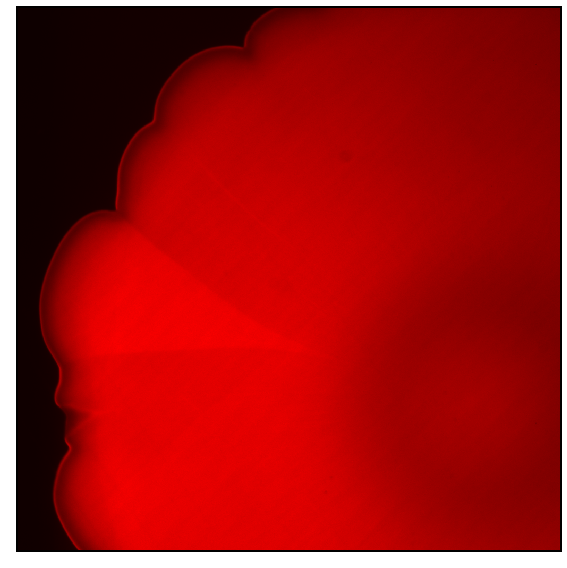

In [203]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(w01.Image**1.5)
ax.set_xticks([]);
ax.set_yticks([]);
fig.savefig('0616_fig2a1.svg', bbox_inches='tight')

In [284]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)

In [45]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.3,0.4); # Fig 2b3
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xym = np.zeros(((len(xps[xps>0]) + 100 ) * 2,2));
xym[:len(xps[xps>0]),0] = xps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),0] = np.flip(xb);
xym[-len(xps[xps>0]):,0] = -np.flip(xps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),0] = -xb;
xym[:len(xps[xps>0]),1] = yps[xps>0]; xym[len(xps[xps>0]):len(xps[xps>0])+len(xb),1] = np.flip(yb);
xym[-len(xps[xps>0]):,1] = np.flip(yps[xps>0]); xym[-len(xps[xps>0])-len(xb):-len(xps[xps>0]),1] = yb;
xym1 = np.copy(xym);
xywl = np.zeros((400,2));
xywl[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl[200:300,0] = np.linspace(0,-0.5,100); xywl[300:400,0]=np.ones(100)*(-0.5);
xywl[:100,1]=np.ones(100)*np.max(yb); xywl[100:200,1]=np.linspace(np.max(yb),0,100);
xywl[200:300,1] = np.zeros(100); xywl[300:400,1]=np.linspace(0,np.max(yb),100);
xywr = np.copy(xywl); xywr[:,0]=xywr[:,0]*(-1);

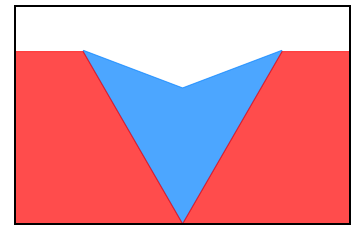

In [46]:
fig, ax = plt.subplots()
ax.add_patch(patch.Polygon(xym, color=(0,0.5,1), alpha=a) )
ax.add_patch(patch.Polygon(xywl, color=(1.0,0.,0.), alpha=a) )
ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=a) )
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0, 0.5)
ax.set_xticks([]); ax.set_yticks([]);

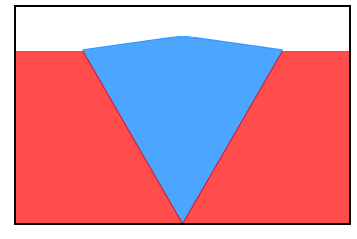

In [47]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.43,0.4);
xps, yps = xyp(1, np.arange(100)/100, param )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );


l1 = len(xps[xps>0]);  l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2+l3 ) * 2,2));
xym[:l2,0] = xr2[xr2<min(xps)]; xym[l2:l2+l1,0] = xps[xps>0]; xym[l2+l1:l2+l1+l3,0] = np.flip(xb);
xym[-l1-l2-l3:-l1-l2,0] = -xb; xym[-l2-l1:-l2,0] = -np.flip(xps[xps>0]); xym[-l2:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l2,1] = yr2[xr2<min(xps)]; xym[l2:l2+l1,1] = yps[xps>0]; xym[l2+l1:l2+l1+l3,1] = np.flip(yb);
xym[-l2:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l2,1] = np.flip(yps[xps>0]); xym[-l2-l1-l3:-l2-l1,1] = yb;
xym2 = np.copy(xym);

fig, ax = plt.subplots()
ax.add_patch(patch.Polygon(xym2, color=(0,0.5,1), alpha=a) )
ax.add_patch(patch.Polygon(xywl, color=(1.0,0.,0.), alpha=a) )
ax.add_patch(patch.Polygon(xywr, color=(1.0,0.,0.), alpha=a) )
ax.set_xlim(-0.5,0.5)
ax.set_ylim(0, 0.5)
ax.set_xticks([]); ax.set_yticks([]);

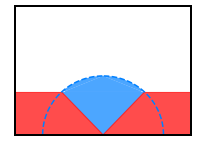

In [291]:
def xyp(t,t2, param):
    u, v1, v2 = param;
    theta = np.arcsin( (v2*np.sqrt(u**2+v2**2-v1**2)-u*v1)/(u**2+v2**2) );
    xp = u*t2-v1*(t-t2)*np.sin(  theta );
    yp = v2*t2+v1*(t-t2)*np.cos( theta );
    return (xp,yp)
param = (0.3,0.55,0.4);
param2 = ((0.55**2-0.4**2)**0.5,0.55,0.4);

xps, yps = xyp(1, np.arange(100)/100, param2 )
xr = param[0]*np.arange(100)/100*2;
yr = param[2]*np.ones(100);
xb = param2[0]*np.arange(100)/100; yb=param[2]*np.arange(100)/100;
xr2 = (param[1])*np.cos( np.linspace(0,1,100)*np.pi/2 );
yr2 = (param[1])*np.sin( np.linspace(0,1,100)*np.pi/2 );

l1 = len(xr2[xr2<min(xps)]);   l2=100; #l2 = len(xr2[xr2<min(xps)]); l3=100; 
xym = np.zeros(((l1+l2 ) * 2,2));
xym[:l1,0] = xr2[xr2<min(xps)]; xym[l1:l2+l1,0] = np.flip(xb);
xym[-l1-l2:-l1,0] = -xb; xym[-l1:,0] = -np.flip(xr2[xr2<min(xps)]);
xym[:l1,1] = yr2[xr2<min(xps)]; xym[l1:l2+l1,1] = np.flip(yb);
xym[-l1:,1] = np.flip(yr2[xr2<min(xps)]); xym[-l2-l1:-l1,1] = yb;
xym3a = np.copy(xym);
l=100;
xym = np.zeros(((l+l ) * 2,2));
xym[:l,0] = np.linspace(0,max(xb),l); xym[l:l*2,0] = np.linspace(max(xb),0,l);
xym[2*l:3*l,0] = -np.linspace(0,max(xb),l); xym[-l:,0] = -np.linspace(max(xb),0,l);
xym[:l,1] = np.linspace(max(yr2),max(yb),l); xym[l:l*2,1] = np.linspace(max(yb),max(yb),l)+0.006;
xym[2*l:3*l,1] = np.linspace(max(yb),max(yb),l)+0.006; xym[-l:,1] = np.linspace(max(yb),max(yr2),l);
xym3b = np.copy(xym);
xywl3 = np.zeros((400,2));
xywl3[:100,0]=np.linspace(-0.5,-np.max(xb),100); xywl3[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl3[200:300,0] = np.linspace(0,-0.5,100); xywl3[300:400,0]=np.ones(100)*(-0.5);
xywl3[:100,1]=np.ones(100)*np.max(yb); xywl3[100:200,1]=np.linspace(np.max(yb),0,100);
xywl3[200:300,1] = np.zeros(100); xywl3[300:400,1]=np.linspace(0,np.max(yb),100);
xywr3 = np.copy(xywl3); xywr3[:,0]=xywr3[:,0]*(-1);
xywl4 = np.zeros((400,2));
xywl4[:100,0]=np.linspace(-2.5,-np.max(xb),100); xywl4[100:200,0]=np.linspace(-np.max(xb),0,100);
xywl4[200:300,0] = np.linspace(0,-2.5,100); xywl4[300:400,0]=np.ones(100)*(-2.5);
xywl4[:100,1]=np.ones(100)*np.max(yb); xywl4[100:200,1]=np.linspace(np.max(yb),0,100);
xywl4[200:300,1] = np.zeros(100); xywl4[300:400,1]=np.linspace(0,np.max(yb),100);
xywr4 = np.copy(xywl4); xywr4[:,0]=xywr4[:,0]*(-1);

fig, ax = plt.subplots(figsize=(8*ipc,6*ipc)  )
ax.add_patch(patch.Polygon(xym3a, facecolor=(0,0.5,1), alpha=a, edgecolor='none') )
ax.add_patch(patch.Polygon(xym3b, facecolor=(0,0.5,1), alpha=a, edgecolor='none') )
ax.add_patch(patch.Polygon(xywl4, color=(1.0,0.,0.), alpha=a) )
ax.add_patch(patch.Polygon(xywr4, color=(1.0,0.,0.), alpha=a) )
ax.plot(xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.plot(-xr2,yr2, color=(0,0.5,1), linestyle='--')
ax.set_xlim(-0.8,0.8)
ax.set_ylim(0, 1.2)
ax.set_xticks([]); ax.set_yticks([]);

fig.savefig('0630_fig2b1.svg', bbox_inches='tight')

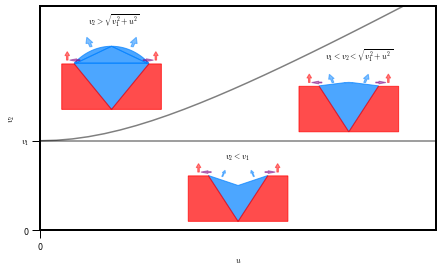

In [48]:
fig, ax = plt.subplots(figsize = (18*ipc,9.3*1.125*ipc) )
ax.set_xticks([0]); ax.set_yticks([0,1]); ax.set_yticklabels([0,r'$v_1$'])

xs = np.linspace(0,10,100);
ys1 = np.sqrt(1 + xs**2);
ax.plot(xs, ys1, color='k', alpha=0.5)
ax.plot(xs, xs*0+1, color='k', alpha=0.5)
ax.set_xlim(0,2.5)
ax.set_ylim(0,2.5)
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$v_2$')
#ax.text(1.1,0.5, 'Dented')
#ax.text(0.5,1.9, 'Bulged')
#ax.text(1.9,1.3, 'Mixed')
ax.text(1.17,0.8,r'$v_2 < v_1$')
ax.text(1.8,1.9,r'$ v_1 < v_2 < \sqrt{v_1^2+u^2}$')
ax.text(0.3,2.3,r'$ v_2 > \sqrt{v_1^2+u^2}$')

a = .7;
rs = np.array([16*ipc,9.3*ipc])*[0.1,0.35]; 
p0=[1.25,0.1];
ax.add_patch(patch.Polygon(xym1*rs+p0, color=(0,0.5,1), alpha=a) )
ax.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )

p0=[1.95,1.1];
ax.add_patch(patch.Polygon(xym2*rs+p0, color=(0,0.5,1), alpha=a) )
ax.add_patch(patch.Polygon(xywl*rs+p0, color=(1.0,0.,0.), alpha=a) )
ax.add_patch(patch.Polygon(xywr*rs+p0, color=(1.0,0.,0.), alpha=a) )

p0=[0.45,1.35];
ax.add_patch(patch.Polygon(xym3a*rs+p0, color=(0,0.5,1), alpha=a) )
ax.add_patch(patch.Polygon(xym3b*rs+p0, color=(0,0.5,1), alpha=a) )
ax.add_patch(patch.Polygon(xywl3*rs+p0, color=(1.0,0.,0.), alpha=a) )
ax.add_patch(patch.Polygon(xywr3*rs+p0, color=(1.0,0.,0.), alpha=a) )

ax.arrow(1,0.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
ax.arrow(1.5,0.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
ax.arrow(1.7,1.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
ax.arrow(2.2,1.65,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
ax.arrow(0.17,1.9,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)
ax.arrow(0.73,1.9,0.,0.05, color=(1,0,0), alpha=0.5, width=0.01)

ax.arrow(1.08,0.65,-0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
ax.arrow(1.42,0.65,0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
ax.arrow(1.78,1.65,-0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
ax.arrow(2.12,1.65,0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
ax.arrow(0.25,1.9,-0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)
ax.arrow(0.65,1.9,0.02,0.0, color=(0.5,0,0.5), alpha=0.5, width=0.01)

ax.arrow(1.15,0.6,0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.007)
ax.arrow(1.35,0.6,-0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.007)
ax.arrow(1.85,1.65,-0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.012)
ax.arrow(2.05,1.65,0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.012)
ax.arrow(0.32,2.05,-0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.015)
ax.arrow(0.58,2.05,0.01,0.04, color=(0,0.5,1), alpha=0.5, width=0.015)

#ax.scatter(uv2, v1v2)
#fig.savefig('0630_fig2c1.svg', bbox_inches='tight')

In [441]:
ax.arrow?

In [49]:
dest1 = dir0+'1017/COMP0001/WM991_1_1.tif';
dest2 = dir0+'1017/COMP0001/WM991_2_1.tif';
comp = Colony([dest1,dest2]);

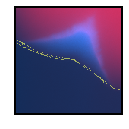

In [58]:
fig, ax = plt.subplots(1,1, figsize=(5*ipc,5*ipc))
img = np.copy(np.flip(comp.Image, axis=0));
img[:,:,1] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
img[:,:,0] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)*0.5
#img[:,:,2] += np.flip( (comp.Edge>np.max(comp.Edge)*0.15)*(comp.ImageBW<np.max(comp.ImageBW)*0.38), axis=0)*np.max(comp.Image)
ax.imshow( img )
#ax.imshow(np.flip(comp.Edge*(comp.ImageBW<0.1), axis=0))
ax.set_xticks([]);
ax.set_yticks([]);
s = 250;
ax.set_xlim(250,250+s); ax.set_ylim(100,100+s);
fig.savefig('0630_fig2a3.svg', bbox_inches='tight')

## WT - mutant experiment

### Expansion rates

In [331]:
# first focus on front locations for OD=0.1 monoculture
# 4 species (W1,W2,M1,M2) x 3 level choices x 12 timepoints
# load
loaded = np.load('1015_mono_tp.npz');
monos_r_tp = loaded['monos_r_tp'][:,0,:,:] # only interested in OD=0.1
monos_r_inv_tp=loaded['monos_r_inv_tp'][:,0,:,:] # only interested in OD=0.1
tps = np.array([ 2.5, 4.5, 6.5, 7.5, 9, 10, 11.5, 12.5 ])

0 0.04786408571252419 1.2538048942447286
1 0.044923629919115526 1.3409022834772417
2 0.028097688472926374 1.383865610281551
3 0.027607612639154455 1.3582183004186532


Text(0, 0.5, 'Front (mm)')

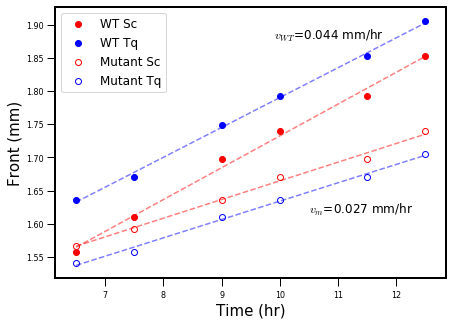

In [503]:
fig, ax = plt.subplots(1,1, figsize=(7,5), sharey=True);
cs1=['r','b','w','w']
cs2=['r','b']
ls=['-','--']
ms=['o','s']
for s in np.arange(4):             
    ax.scatter(tps[2:],monos_r_inv_tp[s,2:,10]*mpx, color=cs1[s], edgecolors=cs2[int(s%2)], marker='o' );
ax.set_xlabel('Time (hr)',fontsize=15)
lgd = ['WT Sc','WT Tq','Mutant Sc','Mutant Tq'];
ax.legend(lgd,fontsize=12)
for s in np.arange(4):
    r, ys, y0 = linfit(tps[2:], monos_r_inv_tp[s,2:,10]*mpx);
    print(s, r, y0)
    if(s==0):
        ws = monos_r_inv_tp[s,2:,10]*mpx-y0;
    elif(s==3):
        ms = monos_r_inv_tp[s,2:,10]*mpx-y0;
    lgd[s] = lgd[s]+':'+str(r)[:5]+'mm/hr'
    ax.plot(tps[2:], ys, color=cs1[s%2], linestyle='--', alpha=0.5);
    if(s==1):
        ax.text(tps[6]-1.6, ys[4]+0.02, '$v_{WT}$='+str(r)[:5]+' mm/hr', fontsize=12)
    if(s==3):
        ax.text(tps[6]-1., ys[4]-0.06, '$v_{m}$='+str(r)[:5]+' mm/hr', fontsize=12)
ax.set_ylabel('Front (mm)',fontsize=15)
#fig.savefig('0224GM/mono_expansion.svg')